### 1. Read MonthsDF

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import dateutil
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose


%matplotlib inline
warnings.filterwarnings("ignore")

df = pd.read_csv('MonthsDF.csv').drop_duplicates()

In [2]:
df.shape

(346915, 92)

In [3]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
df = df.sort_values(by = 'date')
df.set_index('date', inplace=True)

### 2. Plot variables - Data Visualization

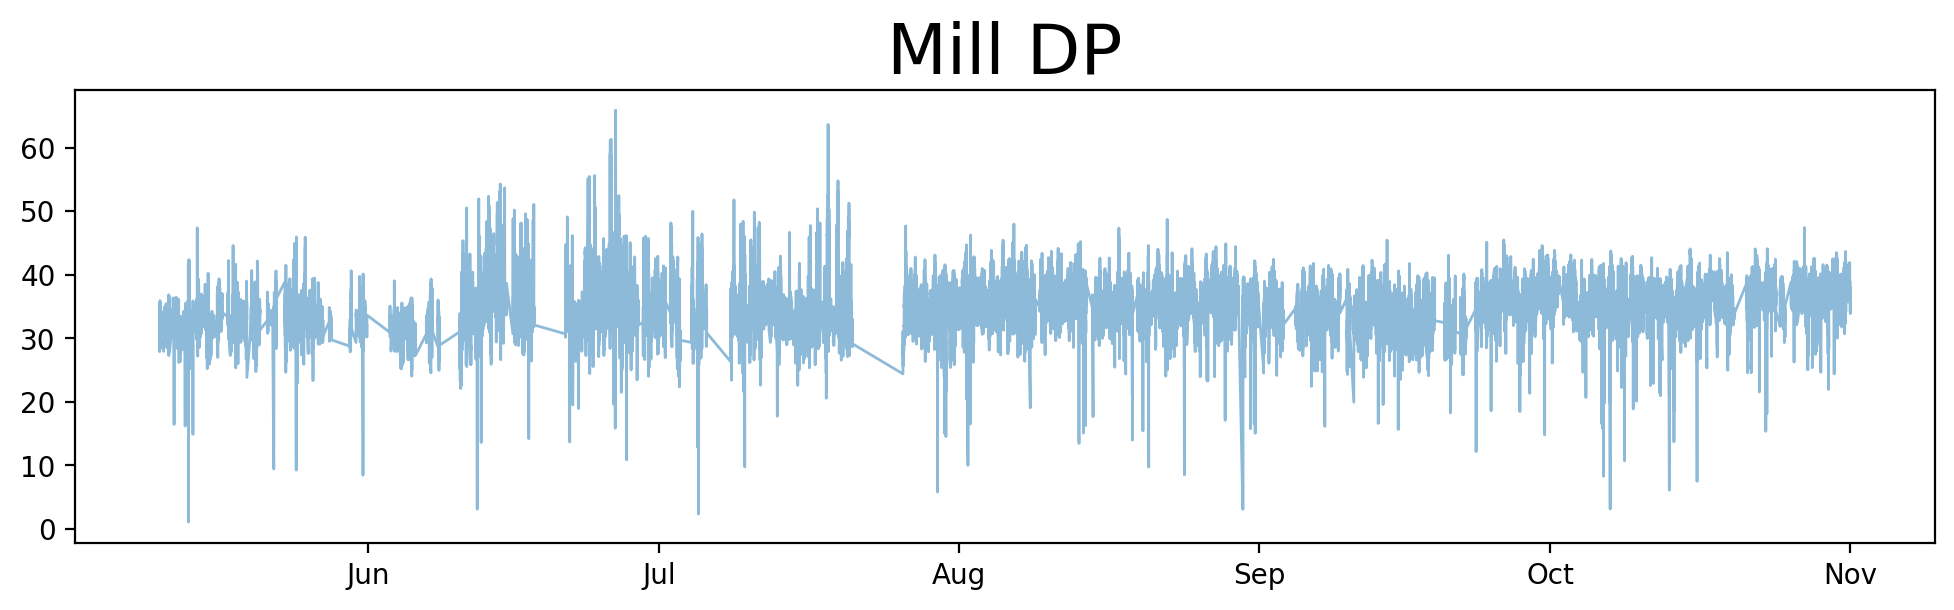

In [48]:
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig, ax = plt.subplots(figsize = (12, 3), dpi=200)

#create the plot
ax.plot(df.index, df['mill_dp_mbar_pv'], lw = 1, alpha = 0.5,)

#custumize plots
ax.set_title("Mill DP", size = 25)
#ax.set_xlabel("Monthly data", size = 15)
#ax.set_xlabel("", size = 15)
#ax.set_ylim(54,59)

#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval = 2))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

#rotate the minor ticks and change the label size
#for text in ax.get_xmajorticklabels():
 #   text.set_rotation(45)
  #  text.set_size(10)

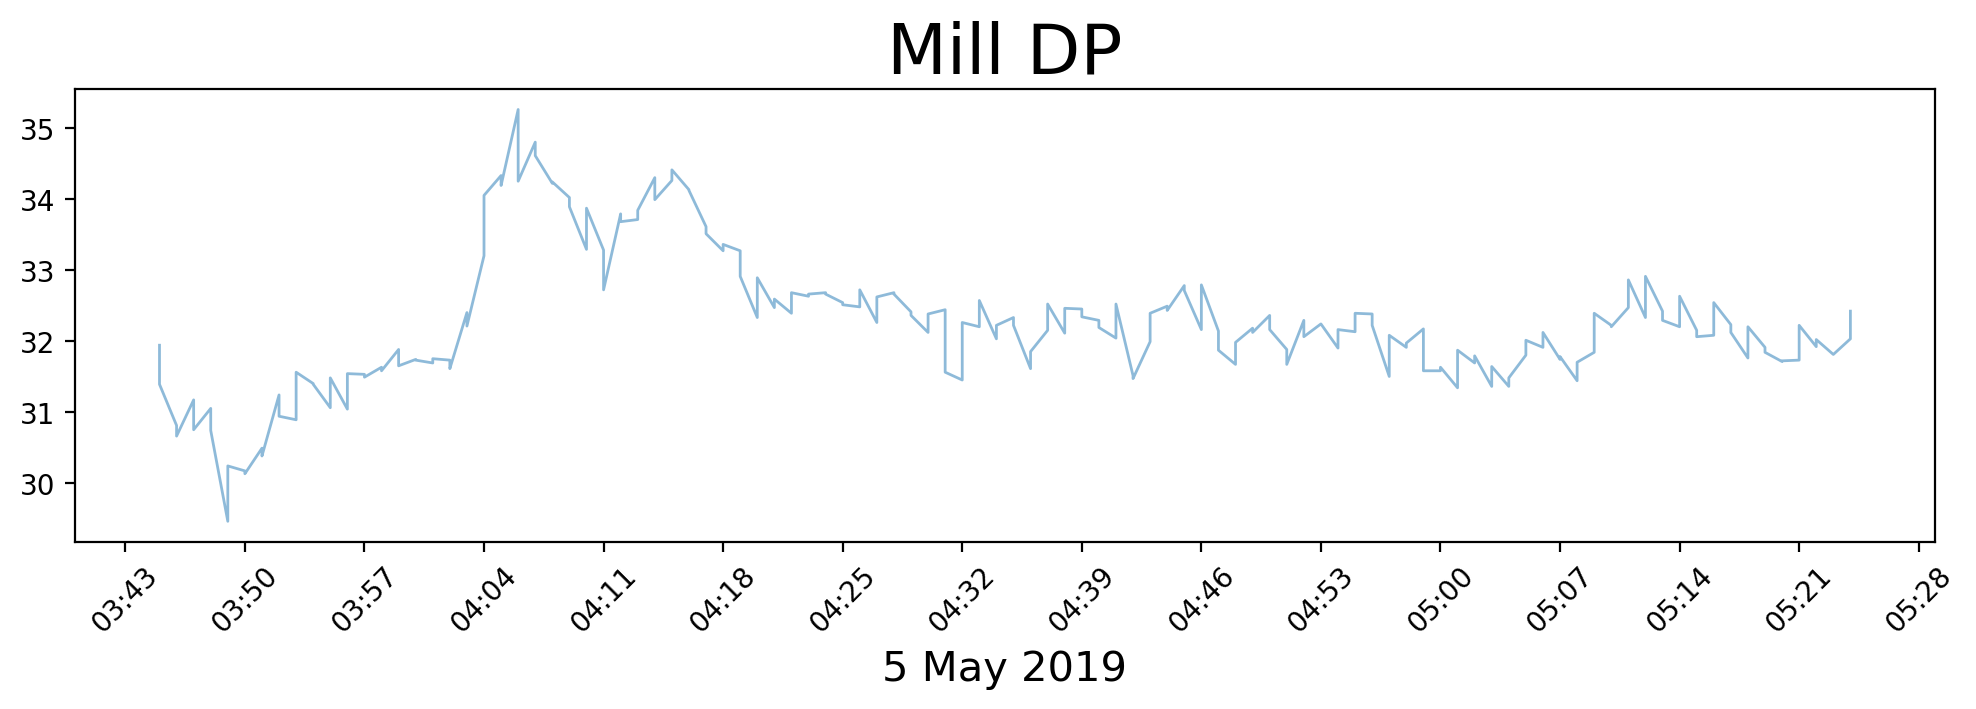

In [4]:
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig, ax = plt.subplots(figsize = (12, 3), dpi=200)

#create the plot
ax.plot(df.index[900:1100], df['mill_dp_mbar_pv'][900:1100], lw = 1, alpha = 0.5,)

#custumize plots
ax.set_title("Mill DP", size = 25)
#ax.set_xlabel("Monthly data", size = 15)
ax.set_xlabel("5 May 2019", size = 15)
#ax.set_ylim(54,59)

#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval = 7))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval = 2))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

### 3. Mask for outliers

In [5]:

def search(df, s):
    return list(df[pd.Series(df.columns)[pd.Series(df.columns).apply(lambda e: s in e)]].columns)

def totnans(df):
    return pd.DataFrame({'cols': df.isna().sum().index, 'nans' : df.isna().sum().values})

def plotting(df, columns, figx=20, figy=10):
    fig, ax = plt.subplots(figsize=(figx, figy))
    df[columns].plot(subplots=True, ax=ax)
    plt.tight_layout()
    
def normed(df):
    return (df-df.mean())/df.std()

'''
new_index = df.index.values
for i in range (len(df)-2):
    if (df.index[i]==df.index[i+1]) and (df.index[i+1] != df.index[i+2]):
        new_index[i+1] = df.index[i+1] + relativedelta(seconds = 30)
    elif (df.index[i]==df.index[i+1]) and (df.index[i+1] == df.index[i+2]):
        new_index[i+1] = df.index[i] + relativedelta(seconds = 30)
        new_index[i+2] = df.index[i+1] + relativedelta(seconds = 30)
new_index

df['new_date'] = pd.to_datetime(new_index, errors='coerce')
df.set_index('new_date', inplace = True)
'''
#df = df.resample('60s').mean()

#df.describe()

#αν θελω να δω το full df
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df)

#----------------------------------------------------------------------------------------------------------------------------

df = df[['cement_type_cpii_bool_pv', 
         'cement_type_cpiv_bool_pv', 
         'total_feed_ton/h_pv', 
         'mill_motor_pwr_kw_pv', 
         'main_fan_pwr_kw_pv', 
         'bucket_elv_mtr_pwr_kw_pv', 
         'separator_pwr_kw_pv', 
         'separator_speed_rpm_pv', 
         'mill_dp_mbar_pv', 
         'fly_ash_1_ton/h_pv', 
         'fly_ash_2_ton/h_pv', 
         'main_fan_speed_rpm_pv', 
         'grinding_pressure_bar_pv','mill_injection_water_m3/h_pv', 'slag_ton/h_pv', 'slag_perc_pv']]

df['fly_ash_ton/h_pv'] = df['fly_ash_1_ton/h_pv']+df['fly_ash_2_ton/h_pv']
#df.drop(columns=['fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv'], inplace=True)

def qmask(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask=(df[col] > Q1-1.5*IQR ) & (df[col] < Q3+1.5*IQR)
    return mask

#----------------------------------------------------------------------------------------------------

df['cement_type_cpiv_bool_pv'].fillna(method = 'ffill', inplace=True)

df1 = df[df['cement_type_cpiv_bool_pv']==0]
df2 = df[df['cement_type_cpiv_bool_pv']==1]

df1.drop(columns = ['cement_type_cpii_bool_pv', 'cement_type_cpiv_bool_pv'], inplace=True)
df2.drop(columns = ['cement_type_cpii_bool_pv', 'cement_type_cpiv_bool_pv'], inplace=True)

#df1.dropna(inplace=True)
#df2.dropna(inplace=True)
    
n1 = normed(df1['total_feed_ton/h_pv']).abs()
n2 = normed(df1['mill_motor_pwr_kw_pv']).abs()
n3 = normed(df1['main_fan_pwr_kw_pv']).abs()
n4 = normed(df1['bucket_elv_mtr_pwr_kw_pv']).abs()
n5 = normed(df1['mill_dp_mbar_pv']).abs()
n6 = normed(df1['slag_ton/h_pv']).abs()
n7 = normed(df1['slag_perc_pv']).abs()
n8 = normed(df1['fly_ash_ton/h_pv']).abs()
df1 = df1[(n1<1)&(n2<2)&(n3<2)&(n4<1)&(n5<2)&(n6<1)&(n7<1)&(n8<1)]

m1 = normed(df2['total_feed_ton/h_pv']).abs()
m2 = normed(df2['mill_motor_pwr_kw_pv']).abs()
m3 = normed(df2['main_fan_pwr_kw_pv']).abs()
m4 = normed(df2['bucket_elv_mtr_pwr_kw_pv']).abs()
m5 = normed(df2['mill_dp_mbar_pv']).abs()
m6 = normed(df2['slag_ton/h_pv']).abs()
m7 = normed(df2['slag_perc_pv']).abs()
m8 = normed(df2['fly_ash_ton/h_pv']).abs()
df2 = df2[(m1<1.5)&(m2<1)&(m3<2)&(m4<1)&(m5<2)&(m6<1)&(m7<1)&(m8<1)]

noc = ['total_feed_ton/h_pv','mill_motor_pwr_kw_pv','main_fan_pwr_kw_pv','bucket_elv_mtr_pwr_kw_pv','separator_pwr_kw_pv','separator_speed_rpm_pv','mill_dp_mbar_pv']
for col in noc:
    df1 = df1[qmask(df1, col)]
    df2 = df2[qmask(df2, col)]

#---------------------------------------------------------------------------------------------------------------------------
task1 = ['separator_pwr_kw_pv','separator_speed_rpm_pv','mill_dp_mbar_pv']
task2 = ['total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv', 'main_fan_speed_rpm_pv', 
         'separator_speed_rpm_pv', 'grinding_pressure_bar_pv','mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 
         'mill_dp_mbar_pv']

#for col in task1:
 #   dfc1 = dfc1[qmask(dfc1, col)]
  #  dfc2 = dfc2[qmask(dfc2, col)]

In [6]:
df1.shape, df2.shape

((67790, 15), (112941, 15))

In [8]:
dfc1_b1 = df1[task1]
dfc2_b1 = df2[task1]

dfc1_b2 = df1[task2]
dfc2_b2 = df2[task2]

#### Cement 1 Block 1 Correlation

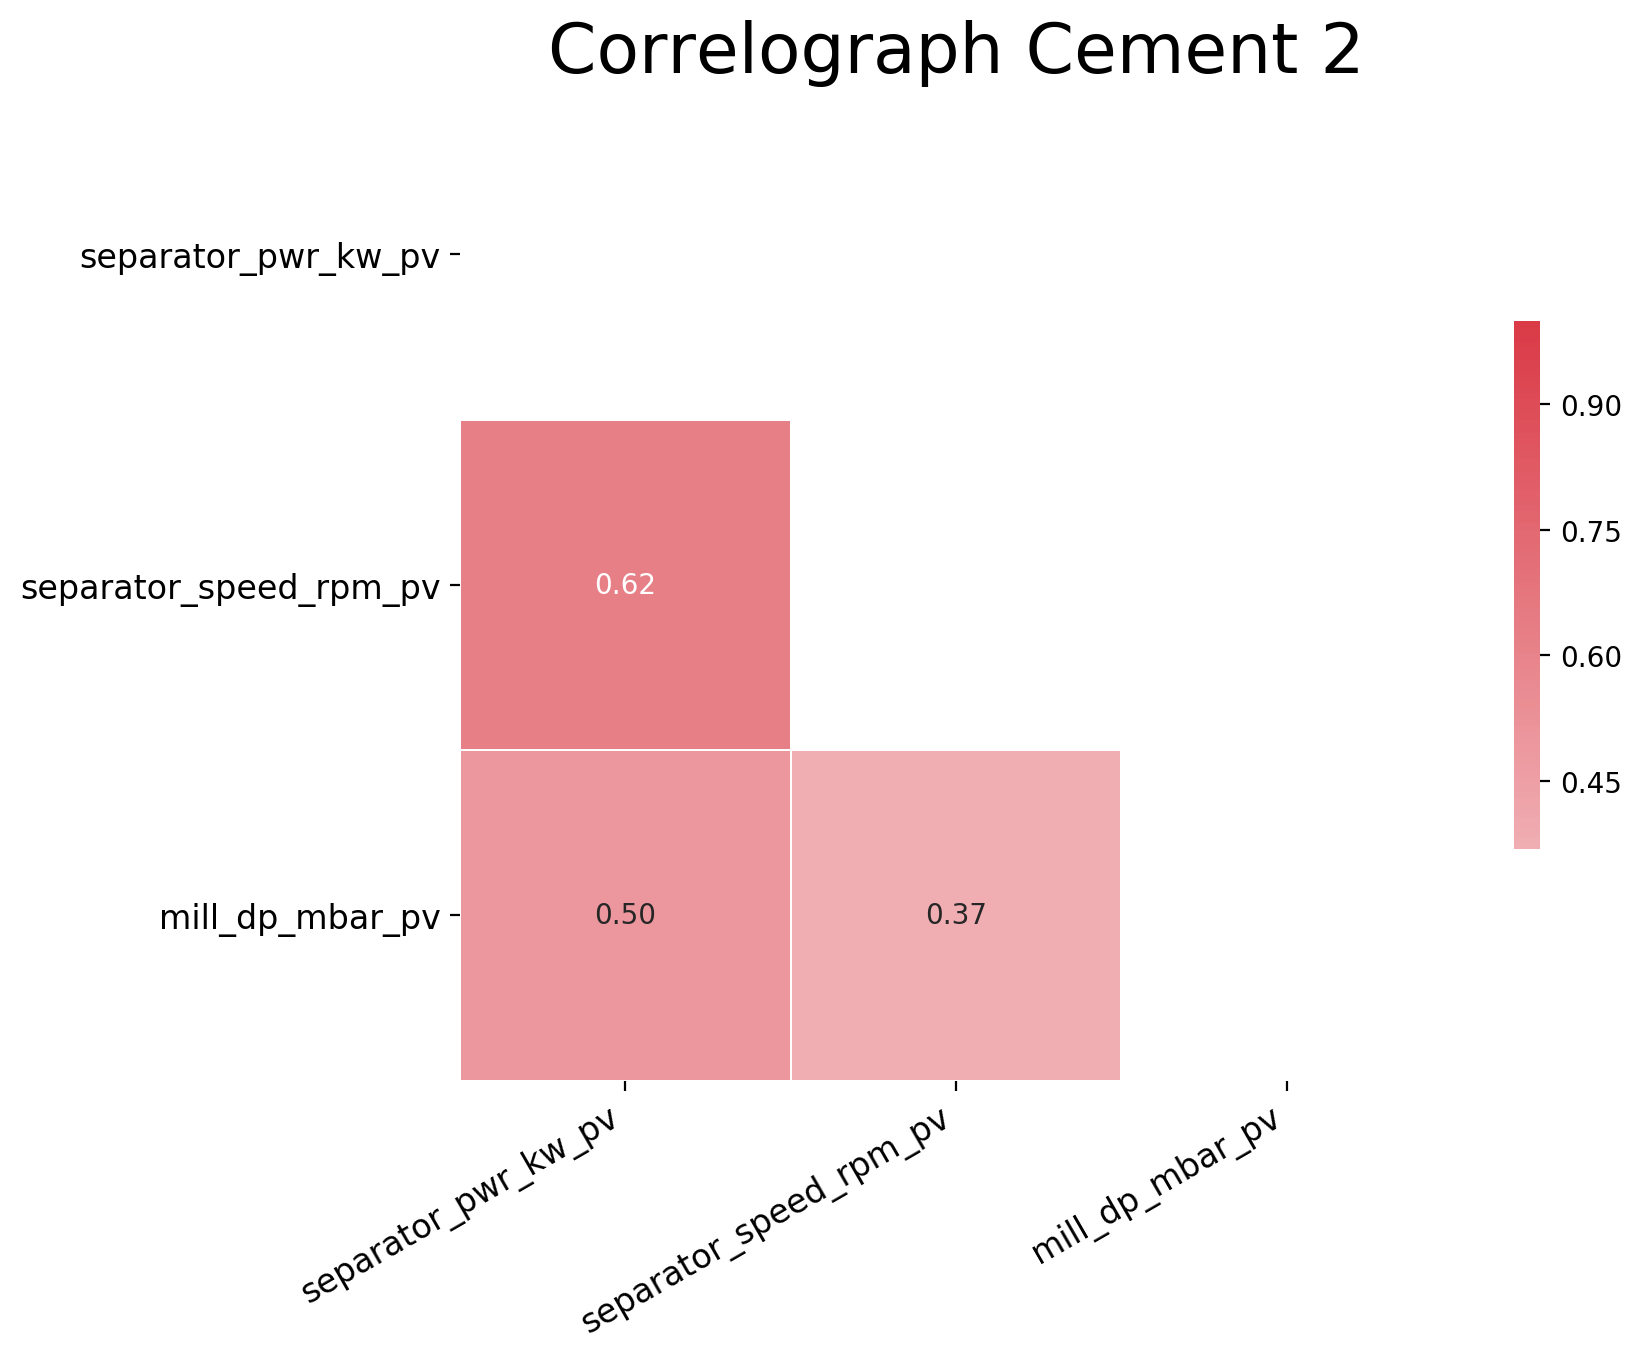

In [9]:
# Compute the correlation matrix
corr = dfc2_b1.iloc[:, :].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 7), dpi=200)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.title('Correlograph Cement 2', size = 25)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize=12)

#### Cement 1 Block 2 correlation

[Text(0.5, 0, 'total_feed_ton/h_pv'),
 Text(1.5, 0, 'fly_ash_1_ton/h_pv'),
 Text(2.5, 0, 'fly_ash_2_ton/h_pv'),
 Text(3.5, 0, 'main_fan_speed_rpm_pv'),
 Text(4.5, 0, 'separator_speed_rpm_pv'),
 Text(5.5, 0, 'grinding_pressure_bar_pv'),
 Text(6.5, 0, 'mill_injection_water_m3/h_pv'),
 Text(7.5, 0, 'bucket_elv_mtr_pwr_kw_pv'),
 Text(8.5, 0, 'mill_dp_mbar_pv')]

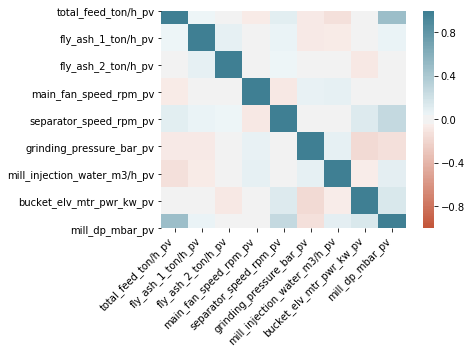

In [7]:
corr = dfc1_b2.corr()
ax = sns.heatmap(
   corr,
   vmin=-1, vmax=1, center=0,
   cmap=sns.diverging_palette(20, 220, n=200),
   square=True
)
ax.set_xticklabels(
   ax.get_xticklabels(),
   rotation=45,
   horizontalalignment='right'
)

### 4. Resampling (60s)

In [7]:
dfc1r=df1.resample('60s').mean()

dfc2r=df2.resample('60s').mean()
print(dfc1r.shape,dfc2r.shape)

(246455, 15) (251324, 15)


### 5. Delete NaN rows (if more than 5 are consecutive)

#### Cement 1

In [43]:
#Find indices of rows where all elements are NaNs
nan_dates = dfc1r[pd.isnull(dfc1r).all(axis=1)].index

def time_dist(s, i, i_2):
    x = abs(s[i_2] - s[i]).seconds
    return x

list1 = pd.Series([])   # Stores ποσα νανς ειναι σερι
list_index = 0

sum1 = 1                # Counts nans που ειναι σερι
total=0
dates = pd.Series([])   # Stores two kinds of data: 1. the index of the date that is the last one in each bundle of NaNs 
                                                  # 2. how many NaNs ειναι σερι (the length of the bundle of NaNs)
dates_index = 0
for i in range(len(nan_dates)-1):
    if time_dist(nan_dates, i, i+1) == 60 :
        sum1= sum1+1
    else:
        if sum1 > 5:
            dates[dates_index] = nan_dates[i]   # We want to store indices only when the bundle's length is > 2
            dates[dates_index+1] = sum1         # We will use this Series when deleting NaNs bundles (with length>2) from dataframes
            dates_index = dates_index+2 
            total = total+sum1
        list1[list_index]=sum1
        sum1=1
        list_index= list_index+1
print(list1)

0        58
1        40
2        13
3        12
4         4
       ... 
1914     15
1915      1
1916    939
1917      1
1918      1
Length: 1919, dtype: int64


In [44]:
# Here, we delete bundles of NaNs if their length is > 5
# First, we want to find where the indices stored in "dates" Series are in dfc1r
first_el = 0
for i in range (0,len(dates),2):  
    flag = True
    j=first_el
    while (flag ==True and j<len(dfc1r)):   
        if dfc1r.index[j] == dates[i]:
            first_el = j - dates[i+1] + 1  # the index of the first row to be deleted
            last_el = j+1                  # the index of the last row to be deleted
            ind_to_drop = list(range(first_el,last_el))  # these are the indices to be dropped
            ind_to_keep = set(range(dfc1r.shape[0])) - set(ind_to_drop)
            dfc1r = dfc1r.take(list(ind_to_keep))  
            print(i,'/1540 dropped')
            flag = False                   # We need this flag because otherwise j would continue searching in df
        j = j+1

0 /1540 dropped
2 /1540 dropped
4 /1540 dropped
6 /1540 dropped
8 /1540 dropped
10 /1540 dropped
12 /1540 dropped
14 /1540 dropped
16 /1540 dropped
18 /1540 dropped
20 /1540 dropped
22 /1540 dropped
24 /1540 dropped
26 /1540 dropped
28 /1540 dropped
30 /1540 dropped
32 /1540 dropped
34 /1540 dropped
36 /1540 dropped
38 /1540 dropped
40 /1540 dropped
42 /1540 dropped
44 /1540 dropped
46 /1540 dropped
48 /1540 dropped
50 /1540 dropped
52 /1540 dropped
54 /1540 dropped
56 /1540 dropped
58 /1540 dropped
60 /1540 dropped
62 /1540 dropped
64 /1540 dropped
66 /1540 dropped
68 /1540 dropped
70 /1540 dropped
72 /1540 dropped
74 /1540 dropped
76 /1540 dropped
78 /1540 dropped
80 /1540 dropped
82 /1540 dropped
84 /1540 dropped
86 /1540 dropped
88 /1540 dropped
90 /1540 dropped
92 /1540 dropped
94 /1540 dropped
96 /1540 dropped
98 /1540 dropped
100 /1540 dropped
102 /1540 dropped
104 /1540 dropped
106 /1540 dropped
108 /1540 dropped
110 /1540 dropped
112 /1540 dropped
114 /1540 dropped
116 /1540 d

In [45]:
246455 - total, dfc1r.shape

(39430, (39430, 15))

#### Cement 2

In [46]:
#Find indices of rows where all elements are NaNs
nan_dates = dfc2r[pd.isnull(dfc2r).all(axis=1)].index

def time_dist(s, i, i_2):
    x = abs(s[i_2] - s[i]).seconds
    return x

list1 = pd.Series([])   # Stores ποσα νανς ειναι σερι
list_index = 0

sum1 = 1                # Counts nans που ειναι σερι
total=0
dates = pd.Series([])   # Stores two kinds of data: 1. the index of the date that is the last one in each bundle of NaNs 
                                                  # 2. how many NaNs ειναι σερι (the length of the bundle of NaNs)
dates_index = 0
for i in range(len(nan_dates)-1):
    if time_dist(nan_dates, i, i+1) == 60 :
        sum1= sum1+1
    else:
        if sum1 > 5:
            dates[dates_index] = nan_dates[i]   # We want to store indices only when the bundle's length is > 5
            dates[dates_index+1] = sum1         # We will use this Series when deleting NaNs bundles (with length>5) from dataframes
            dates_index = dates_index+2 
            total = total+sum1
        list1[list_index]=sum1
        sum1=1
        list_index= list_index+1
print(list1)

0        45
1         1
2        13
3       520
4         2
       ... 
6093      1
6094      1
6095      1
6096      1
6097      1
Length: 6098, dtype: int64


In [47]:
# Here, we delete bundles of NaNs if their length is > 5
# First, we want to find where the indices stored in "dates" Series are in dfc2r
first_el = 0
for i in range (0,len(dates),2):  
    flag = True
    j=first_el
    while (flag ==True and j<len(dfc2r)):   
        if dfc2r.index[j] == dates[i]:
            first_el = j - dates[i+1] + 1  # the index of the first row to be deleted
            last_el = j+1                  # the index of the last row to be deleted
            ind_to_drop = list(range(first_el,last_el))  # these are the indices to be dropped
            ind_to_keep = set(range(dfc2r.shape[0])) - set(ind_to_drop)
            dfc2r = dfc2r.take(list(ind_to_keep))  
            print(i,'/3192 dropped')
            flag = False                   # We need this flag because otherwise j would continue searching in dfc2r
        j = j+1

0 /3192 dropped
2 /3192 dropped
4 /3192 dropped
6 /3192 dropped
8 /3192 dropped
10 /3192 dropped
12 /3192 dropped
14 /3192 dropped
16 /3192 dropped
18 /3192 dropped
20 /3192 dropped
22 /3192 dropped
24 /3192 dropped
26 /3192 dropped
28 /3192 dropped
30 /3192 dropped
32 /3192 dropped
34 /3192 dropped
36 /3192 dropped
38 /3192 dropped
40 /3192 dropped
42 /3192 dropped
44 /3192 dropped
46 /3192 dropped
48 /3192 dropped
50 /3192 dropped
52 /3192 dropped
54 /3192 dropped
56 /3192 dropped
58 /3192 dropped
60 /3192 dropped
62 /3192 dropped
64 /3192 dropped
66 /3192 dropped
68 /3192 dropped
70 /3192 dropped
72 /3192 dropped
74 /3192 dropped
76 /3192 dropped
78 /3192 dropped
80 /3192 dropped
82 /3192 dropped
84 /3192 dropped
86 /3192 dropped
88 /3192 dropped
90 /3192 dropped
92 /3192 dropped
94 /3192 dropped
96 /3192 dropped
98 /3192 dropped
100 /3192 dropped
102 /3192 dropped
104 /3192 dropped
106 /3192 dropped
108 /3192 dropped
110 /3192 dropped
112 /3192 dropped
114 /3192 dropped
116 /3192 d

922 /3192 dropped
924 /3192 dropped
926 /3192 dropped
928 /3192 dropped
930 /3192 dropped
932 /3192 dropped
934 /3192 dropped
936 /3192 dropped
938 /3192 dropped
940 /3192 dropped
942 /3192 dropped
944 /3192 dropped
946 /3192 dropped
948 /3192 dropped
950 /3192 dropped
952 /3192 dropped
954 /3192 dropped
956 /3192 dropped
958 /3192 dropped
960 /3192 dropped
962 /3192 dropped
964 /3192 dropped
966 /3192 dropped
968 /3192 dropped
970 /3192 dropped
972 /3192 dropped
974 /3192 dropped
976 /3192 dropped
978 /3192 dropped
980 /3192 dropped
982 /3192 dropped
984 /3192 dropped
986 /3192 dropped
988 /3192 dropped
990 /3192 dropped
992 /3192 dropped
994 /3192 dropped
996 /3192 dropped
998 /3192 dropped
1000 /3192 dropped
1002 /3192 dropped
1004 /3192 dropped
1006 /3192 dropped
1008 /3192 dropped
1010 /3192 dropped
1012 /3192 dropped
1014 /3192 dropped
1016 /3192 dropped
1018 /3192 dropped
1020 /3192 dropped
1022 /3192 dropped
1024 /3192 dropped
1026 /3192 dropped
1028 /3192 dropped
1030 /3192 dr

1796 /3192 dropped
1798 /3192 dropped
1800 /3192 dropped
1802 /3192 dropped
1804 /3192 dropped
1806 /3192 dropped
1808 /3192 dropped
1810 /3192 dropped
1812 /3192 dropped
1814 /3192 dropped
1816 /3192 dropped
1818 /3192 dropped
1820 /3192 dropped
1822 /3192 dropped
1824 /3192 dropped
1826 /3192 dropped
1828 /3192 dropped
1830 /3192 dropped
1832 /3192 dropped
1834 /3192 dropped
1836 /3192 dropped
1838 /3192 dropped
1840 /3192 dropped
1842 /3192 dropped
1844 /3192 dropped
1846 /3192 dropped
1848 /3192 dropped
1850 /3192 dropped
1852 /3192 dropped
1854 /3192 dropped
1856 /3192 dropped
1858 /3192 dropped
1860 /3192 dropped
1862 /3192 dropped
1864 /3192 dropped
1866 /3192 dropped
1868 /3192 dropped
1870 /3192 dropped
1872 /3192 dropped
1874 /3192 dropped
1876 /3192 dropped
1878 /3192 dropped
1880 /3192 dropped
1882 /3192 dropped
1884 /3192 dropped
1886 /3192 dropped
1888 /3192 dropped
1890 /3192 dropped
1892 /3192 dropped
1894 /3192 dropped
1896 /3192 dropped
1898 /3192 dropped
1900 /3192 d

In [48]:
251324 - total, dfc2r.shape

(73368, (73368, 15))

### 6. Delete NaN rows in 'main_fan_speed_rpm_pv' column (if more than 5 are consecutive)

#### Cement 1

In [49]:
# Find the indices with NaNs
nan_ind = pd.Series([])
j = 0

for i in range(len(dfc1r)):
    if np.isnan(dfc1r['main_fan_speed_rpm_pv'][i]):
        nan_ind[j] = i
        j=j+1
print(nan_ind)

0         604
1         605
2         606
3         607
4         609
        ...  
2442    38616
2443    38765
2444    39015
2445    39019
2446    39192
Length: 2447, dtype: int64


In [50]:
from itertools import groupby
from operator import itemgetter
ind_to_erase=[]                  #store the indices of nans if they are more than 2 in a row
for k, g in groupby(enumerate(nan_ind), lambda x : x[0] - x[1]):
    x = list(map(itemgetter(1), g))
    print(x)
    if len(x)>5:
        ind_to_erase.append(x)

# Convert the list of lists to a list. We will use this flat_list to define the rows we want to keep.
flat_list = [item for sublist in ind_to_erase for item in sublist]
print(flat_list)

ind_to_keep = set(range(dfc1r.shape[0])) - set(flat_list)
dfc1r = dfc1r.take(list(ind_to_keep))

[604, 605, 606, 607]
[609, 610]
[624]
[626, 627]
[643]
[650, 651]
[657, 658, 659]
[681]
[748, 749, 750]
[762]
[776]
[786]
[839]
[843, 844]
[851, 852]
[861, 862]
[865, 866]
[868]
[872]
[875]
[879]
[882]
[888]
[890]
[894, 895]
[900]
[904]
[910]
[912]
[915]
[922]
[1107]
[1305]
[1456]
[1463]
[1465]
[1478]
[1501]
[1566]
[1577, 1578]
[1585]
[1608]
[1628]
[1700]
[1704]
[1768]
[1771]
[1773]
[1808]
[1821]
[1828]
[1831, 1832, 1833]
[1843]
[1848, 1849, 1850]
[1863]
[1890]
[1895]
[1898]
[1905, 1906, 1907]
[1931]
[1937, 1938, 1939, 1940]
[1966]
[1972]
[1989]
[1996]
[2023]
[2048]
[2051]
[2128]
[2130, 2131]
[2202, 2203]
[2226]
[2329, 2330, 2331]
[2366]
[2407]
[2960, 2961, 2962, 2963, 2964]
[2987, 2988, 2989, 2990]
[2992]
[3145, 3146, 3147]
[3152, 3153]
[3157, 3158, 3159, 3160, 3161]
[3184, 3185, 3186]
[3203, 3204, 3205]
[3491, 3492, 3493, 3494]
[3550]
[3571]
[3591, 3592, 3593, 3594, 3595]
[3865, 3866, 3867, 3868]
[3974]
[4019, 4020]
[4059]
[4097]
[4244]
[4277]
[4367]
[4408]
[4489]
[4492]
[4496]
[4498

[27245]
[27258, 27259]
[27261, 27262]
[27268, 27269]
[27273]
[27275, 27276]
[27278, 27279, 27280, 27281]
[27283]
[27291]
[27303]
[27316, 27317]
[27319]
[27499, 27500, 27501, 27502]
[27553, 27554]
[27558]
[27585, 27586, 27587]
[27596]
[27604, 27605]
[27607]
[27625]
[27629]
[27661]
[27707]
[27739]
[27758]
[27766]
[27775]
[27781]
[27785]
[27806]
[27856, 27857, 27858, 27859, 27860]
[27868]
[27880, 27881, 27882, 27883, 27884]
[27902, 27903, 27904, 27905]
[27907, 27908]
[27911]
[27921]
[27936, 27937]
[27954]
[27956]
[27958, 27959]
[27962]
[27968, 27969, 27970, 27971]
[27975, 27976, 27977]
[27979]
[28050]
[28061]
[28085]
[28092, 28093]
[28102]
[28104]
[28107]
[28112]
[28126]
[28133, 28134, 28135]
[28144]
[28148, 28149]
[28154]
[28156]
[28168, 28169, 28170]
[28189]
[28212]
[28220, 28221, 28222, 28223]
[28236]
[28255, 28256, 28257, 28258]
[28261, 28262]
[28270]
[28424]
[28452]
[28477]
[28487]
[28502]
[28535]
[28564]
[28598, 28599]
[28617]
[28647]
[28713]
[28805]
[28817]
[28839, 28840, 28841, 28

In [51]:
dfc1r.shape

(39163, 15)

#### Cement 2

In [52]:
# Find the indices with NaNs
nan_ind = pd.Series([])
j = 0

for i in range(len(dfc2r)):
    if np.isnan(dfc2r['main_fan_speed_rpm_pv'][i]):
        nan_ind[j] = i
        j=j+1
print(nan_ind)

0           7
1         170
2         171
3         223
4         367
        ...  
8343    73334
8344    73340
8345    73344
8346    73354
8347    73365
Length: 8348, dtype: int64


In [53]:
from itertools import groupby
from operator import itemgetter
ind_to_erase=[]                  #store the indices of nans if they are more than 2 in a row
for k, g in groupby(enumerate(nan_ind), lambda x : x[0] - x[1]):
    x = list(map(itemgetter(1), g))
    print(x)
    if len(x)>5:
        ind_to_erase.append(x)

# Convert the list of lists to a list. We will use this flat_list to define the rows we want to keep.
flat_list = [item for sublist in ind_to_erase for item in sublist]
print(flat_list)

ind_to_keep = set(range(dfc2r.shape[0])) - set(flat_list)
dfc2r = dfc2r.take(list(ind_to_keep))

[7]
[170, 171]
[223]
[367]
[393, 394]
[538]
[636, 637, 638, 639]
[775, 776]
[806, 807]
[847, 848]
[922]
[1466, 1467, 1468]
[1554]
[1669]
[1697, 1698]
[1779]
[1786, 1787]
[1814]
[1818]
[1826]
[1829]
[1845]
[1849, 1850]
[1857]
[1859, 1860, 1861, 1862]
[1865]
[1868]
[1874]
[1879]
[1882]
[1886]
[1891, 1892, 1893]
[1895, 1896]
[1901]
[1934]
[1937]
[1954]
[1968]
[1971]
[2037, 2038]
[2228]
[2400]
[2422]
[2441]
[2615]
[2888]
[3181]
[3239]
[3262, 3263, 3264, 3265, 3266]
[3286]
[3309, 3310, 3311]
[3331, 3332]
[3335, 3336, 3337]
[3349, 3350]
[3352, 3353, 3354, 3355, 3356]
[3358, 3359, 3360, 3361]
[3368]
[3455, 3456]
[3484]
[3487]
[3490]
[3568, 3569]
[3587, 3588, 3589, 3590, 3591]
[3757, 3758]
[3780]
[3783]
[3795]
[3804, 3805]
[3814]
[3819, 3820]
[3932]
[3942]
[3949]
[3964, 3965]
[3971]
[4024, 4025]
[4039]
[4086]
[4251]
[4323]
[4407]
[4411]
[4414]
[4421]
[4424]
[4443, 4444, 4445, 4446, 4447]
[4551]
[4746, 4747]
[4754, 4755]
[4759]
[4762]
[4771]
[4773]
[4775]
[4781]
[4783, 4784]
[4786]
[4794, 4795]

[24763]
[24765, 24766, 24767, 24768, 24769]
[24773]
[24775]
[24810]
[24812]
[24880]
[24882]
[24886, 24887]
[24889, 24890]
[24892]
[24897, 24898]
[24915]
[24934, 24935]
[24993]
[24998, 24999]
[25001, 25002, 25003]
[25006]
[25009]
[25012, 25013]
[25091]
[25096]
[25098, 25099]
[25102]
[25108]
[25148]
[25258]
[25312]
[25486, 25487]
[25489, 25490]
[25649]
[25652, 25653]
[25662]
[25771]
[25798, 25799]
[25801]
[25825]
[25827, 25828, 25829]
[25831]
[25833, 25834, 25835]
[25838]
[25860]
[25870, 25871]
[25880]
[25883, 25884, 25885, 25886, 25887]
[25889]
[25891, 25892]
[25895, 25896]
[25899, 25900, 25901]
[25904]
[25929]
[25939]
[25951, 25952, 25953]
[25989]
[26025, 26026]
[26037, 26038, 26039]
[26087, 26088]
[26116]
[26152]
[26184]
[26190]
[26203]
[26222]
[26224]
[26235]
[26262]
[26276]
[26285]
[26287]
[26298]
[26379]
[26382]
[26384]
[26433, 26434]
[26441]
[26446]
[26473, 26474, 26475]
[26482, 26483, 26484, 26485, 26486]
[26495]
[26498]
[26637, 26638]
[26661, 26662]
[26804]
[26808]
[26811]
[2681

[39658]
[39660]
[39662]
[39670]
[39672, 39673]
[39684]
[39687, 39688, 39689]
[39691, 39692]
[39694, 39695]
[39701, 39702, 39703, 39704]
[39707, 39708, 39709]
[39711, 39712, 39713]
[39715, 39716, 39717]
[39719, 39720, 39721]
[39725]
[39775]
[39833, 39834]
[39851]
[39878, 39879, 39880]
[39889]
[39895]
[40100]
[40111]
[40116]
[40122]
[40129]
[40131, 40132]
[40135]
[40139]
[40143, 40144]
[40147, 40148]
[40150]
[40161]
[40186]
[40229, 40230]
[40246, 40247]
[40249, 40250]
[40254]
[40260, 40261, 40262]
[40265, 40266]
[40270]
[40282]
[40286, 40287]
[40289, 40290]
[40293]
[40297]
[40302, 40303]
[40305, 40306, 40307]
[40309]
[40395]
[40400]
[40429]
[40446, 40447]
[40451]
[40454]
[40456, 40457]
[40460, 40461, 40462, 40463, 40464]
[40467, 40468]
[40471]
[40474]
[40476, 40477, 40478, 40479]
[40483, 40484, 40485, 40486, 40487]
[40493]
[40498, 40499, 40500, 40501, 40502]
[40504]
[40514, 40515, 40516]
[40519, 40520]
[40524, 40525]
[40527, 40528]
[40530, 40531]
[40545, 40546, 40547]
[40553]
[40578]
[40

[54739, 54740, 54741]
[54758]
[54771]
[54775]
[54888]
[54902]
[54904]
[54906]
[54911]
[54917]
[54920, 54921]
[54923, 54924]
[54926]
[54928, 54929]
[54931]
[54934, 54935, 54936, 54937]
[54939]
[54957, 54958]
[54962]
[54969]
[54971]
[54979]
[54982, 54983, 54984]
[55051]
[55056]
[55062]
[55066]
[55070, 55071]
[55074]
[55080, 55081]
[55084]
[55125, 55126, 55127]
[55190]
[55207]
[55217]
[55229, 55230]
[55232]
[55238, 55239]
[55241, 55242, 55243, 55244]
[55247, 55248, 55249, 55250, 55251]
[55271]
[55273, 55274, 55275, 55276]
[55278, 55279, 55280]
[55282]
[55285, 55286]
[55288, 55289]
[55294, 55295]
[55397, 55398]
[55422]
[55461]
[55467]
[55472, 55473]
[55477]
[55479, 55480]
[55490]
[55497]
[55517, 55518, 55519, 55520]
[55551]
[55558]
[55567]
[55570, 55571, 55572]
[55574, 55575]
[55577, 55578, 55579]
[55581, 55582]
[55585, 55586, 55587]
[55590, 55591, 55592]
[55734]
[55736]
[55741]
[55749]
[55751]
[55812]
[55817]
[55828]
[55891, 55892]
[55902]
[55904]
[55911]
[55946]
[55967]
[55972]
[56034]
[

[62941, 62942, 62943, 62944]
[62947, 62948]
[62951, 62952]
[62955]
[62957]
[62966]
[62975]
[62977]
[62981, 62982, 62983, 62984]
[62989]
[62991]
[62994, 62995]
[62998]
[63001]
[63006]
[63012]
[63015]
[63027, 63028, 63029]
[63039, 63040]
[63049]
[63054, 63055]
[63061, 63062]
[63064]
[63066, 63067, 63068, 63069]
[63071, 63072]
[63076]
[63078]
[63099]
[63105, 63106, 63107, 63108]
[63113]
[63116]
[63121]
[63173]
[63186]
[63188, 63189, 63190, 63191]
[63195]
[63200, 63201]
[63207, 63208]
[63215]
[63218]
[63220]
[63222, 63223, 63224]
[63229]
[63232]
[63235, 63236, 63237, 63238, 63239]
[63241, 63242]
[63245]
[63247, 63248, 63249, 63250]
[63254, 63255, 63256]
[63258, 63259]
[63262]
[63264]
[63276, 63277]
[63279]
[63289]
[63293]
[63299, 63300]
[63311]
[63337]
[63368, 63369]
[63376]
[63405, 63406]
[63409]
[63411]
[63420]
[63429, 63430, 63431, 63432, 63433]
[63442]
[63445]
[63457]
[63464]
[63493, 63494, 63495]
[63498, 63499]
[63538, 63539, 63540]
[63544]
[63557]
[63562]
[63627]
[63629]
[63732]
[637

In [54]:
dfc2r.shape

(73368, 15)

### 7. Interpolate

In [55]:
dfc1r.interpolate(inplace = True, limit = 6)
dfc2r.interpolate(inplace = True, limit = 6)

### 8. Find periods with consecutive dates

#### Cement 1

In [65]:
m1=[]
sum1 = 1                

for i in range(len(dfc1r)-1):
    if time_dist(dfc1r.index, i, i+1) == 60 :
        sum1= sum1+1
    else:
        m1.append([sum1, i])
        sum1=1
    print(i, '/ 32429')

0 / 32429
1 / 32429
2 / 32429
3 / 32429
4 / 32429
5 / 32429
6 / 32429
7 / 32429
8 / 32429
9 / 32429
10 / 32429
11 / 32429
12 / 32429
13 / 32429
14 / 32429
15 / 32429
16 / 32429
17 / 32429
18 / 32429
19 / 32429
20 / 32429
21 / 32429
22 / 32429
23 / 32429
24 / 32429
25 / 32429
26 / 32429
27 / 32429
28 / 32429
29 / 32429
30 / 32429
31 / 32429
32 / 32429
33 / 32429
34 / 32429
35 / 32429
36 / 32429
37 / 32429
38 / 32429
39 / 32429
40 / 32429
41 / 32429
42 / 32429
43 / 32429
44 / 32429
45 / 32429
46 / 32429
47 / 32429
48 / 32429
49 / 32429
50 / 32429
51 / 32429
52 / 32429
53 / 32429
54 / 32429
55 / 32429
56 / 32429
57 / 32429
58 / 32429
59 / 32429
60 / 32429
61 / 32429
62 / 32429
63 / 32429
64 / 32429
65 / 32429
66 / 32429
67 / 32429
68 / 32429
69 / 32429
70 / 32429
71 / 32429
72 / 32429
73 / 32429
74 / 32429
75 / 32429
76 / 32429
77 / 32429
78 / 32429
79 / 32429
80 / 32429
81 / 32429
82 / 32429
83 / 32429
84 / 32429
85 / 32429
86 / 32429
87 / 32429
88 / 32429
89 / 32429
90 / 32429
91 / 3242

902 / 32429
903 / 32429
904 / 32429
905 / 32429
906 / 32429
907 / 32429
908 / 32429
909 / 32429
910 / 32429
911 / 32429
912 / 32429
913 / 32429
914 / 32429
915 / 32429
916 / 32429
917 / 32429
918 / 32429
919 / 32429
920 / 32429
921 / 32429
922 / 32429
923 / 32429
924 / 32429
925 / 32429
926 / 32429
927 / 32429
928 / 32429
929 / 32429
930 / 32429
931 / 32429
932 / 32429
933 / 32429
934 / 32429
935 / 32429
936 / 32429
937 / 32429
938 / 32429
939 / 32429
940 / 32429
941 / 32429
942 / 32429
943 / 32429
944 / 32429
945 / 32429
946 / 32429
947 / 32429
948 / 32429
949 / 32429
950 / 32429
951 / 32429
952 / 32429
953 / 32429
954 / 32429
955 / 32429
956 / 32429
957 / 32429
958 / 32429
959 / 32429
960 / 32429
961 / 32429
962 / 32429
963 / 32429
964 / 32429
965 / 32429
966 / 32429
967 / 32429
968 / 32429
969 / 32429
970 / 32429
971 / 32429
972 / 32429
973 / 32429
974 / 32429
975 / 32429
976 / 32429
977 / 32429
978 / 32429
979 / 32429
980 / 32429
981 / 32429
982 / 32429
983 / 32429
984 / 32429
985 

1578 / 32429
1579 / 32429
1580 / 32429
1581 / 32429
1582 / 32429
1583 / 32429
1584 / 32429
1585 / 32429
1586 / 32429
1587 / 32429
1588 / 32429
1589 / 32429
1590 / 32429
1591 / 32429
1592 / 32429
1593 / 32429
1594 / 32429
1595 / 32429
1596 / 32429
1597 / 32429
1598 / 32429
1599 / 32429
1600 / 32429
1601 / 32429
1602 / 32429
1603 / 32429
1604 / 32429
1605 / 32429
1606 / 32429
1607 / 32429
1608 / 32429
1609 / 32429
1610 / 32429
1611 / 32429
1612 / 32429
1613 / 32429
1614 / 32429
1615 / 32429
1616 / 32429
1617 / 32429
1618 / 32429
1619 / 32429
1620 / 32429
1621 / 32429
1622 / 32429
1623 / 32429
1624 / 32429
1625 / 32429
1626 / 32429
1627 / 32429
1628 / 32429
1629 / 32429
1630 / 32429
1631 / 32429
1632 / 32429
1633 / 32429
1634 / 32429
1635 / 32429
1636 / 32429
1637 / 32429
1638 / 32429
1639 / 32429
1640 / 32429
1641 / 32429
1642 / 32429
1643 / 32429
1644 / 32429
1645 / 32429
1646 / 32429
1647 / 32429
1648 / 32429
1649 / 32429
1650 / 32429
1651 / 32429
1652 / 32429
1653 / 32429
1654 / 32429

2433 / 32429
2434 / 32429
2435 / 32429
2436 / 32429
2437 / 32429
2438 / 32429
2439 / 32429
2440 / 32429
2441 / 32429
2442 / 32429
2443 / 32429
2444 / 32429
2445 / 32429
2446 / 32429
2447 / 32429
2448 / 32429
2449 / 32429
2450 / 32429
2451 / 32429
2452 / 32429
2453 / 32429
2454 / 32429
2455 / 32429
2456 / 32429
2457 / 32429
2458 / 32429
2459 / 32429
2460 / 32429
2461 / 32429
2462 / 32429
2463 / 32429
2464 / 32429
2465 / 32429
2466 / 32429
2467 / 32429
2468 / 32429
2469 / 32429
2470 / 32429
2471 / 32429
2472 / 32429
2473 / 32429
2474 / 32429
2475 / 32429
2476 / 32429
2477 / 32429
2478 / 32429
2479 / 32429
2480 / 32429
2481 / 32429
2482 / 32429
2483 / 32429
2484 / 32429
2485 / 32429
2486 / 32429
2487 / 32429
2488 / 32429
2489 / 32429
2490 / 32429
2491 / 32429
2492 / 32429
2493 / 32429
2494 / 32429
2495 / 32429
2496 / 32429
2497 / 32429
2498 / 32429
2499 / 32429
2500 / 32429
2501 / 32429
2502 / 32429
2503 / 32429
2504 / 32429
2505 / 32429
2506 / 32429
2507 / 32429
2508 / 32429
2509 / 32429

3446 / 32429
3447 / 32429
3448 / 32429
3449 / 32429
3450 / 32429
3451 / 32429
3452 / 32429
3453 / 32429
3454 / 32429
3455 / 32429
3456 / 32429
3457 / 32429
3458 / 32429
3459 / 32429
3460 / 32429
3461 / 32429
3462 / 32429
3463 / 32429
3464 / 32429
3465 / 32429
3466 / 32429
3467 / 32429
3468 / 32429
3469 / 32429
3470 / 32429
3471 / 32429
3472 / 32429
3473 / 32429
3474 / 32429
3475 / 32429
3476 / 32429
3477 / 32429
3478 / 32429
3479 / 32429
3480 / 32429
3481 / 32429
3482 / 32429
3483 / 32429
3484 / 32429
3485 / 32429
3486 / 32429
3487 / 32429
3488 / 32429
3489 / 32429
3490 / 32429
3491 / 32429
3492 / 32429
3493 / 32429
3494 / 32429
3495 / 32429
3496 / 32429
3497 / 32429
3498 / 32429
3499 / 32429
3500 / 32429
3501 / 32429
3502 / 32429
3503 / 32429
3504 / 32429
3505 / 32429
3506 / 32429
3507 / 32429
3508 / 32429
3509 / 32429
3510 / 32429
3511 / 32429
3512 / 32429
3513 / 32429
3514 / 32429
3515 / 32429
3516 / 32429
3517 / 32429
3518 / 32429
3519 / 32429
3520 / 32429
3521 / 32429
3522 / 32429

4296 / 32429
4297 / 32429
4298 / 32429
4299 / 32429
4300 / 32429
4301 / 32429
4302 / 32429
4303 / 32429
4304 / 32429
4305 / 32429
4306 / 32429
4307 / 32429
4308 / 32429
4309 / 32429
4310 / 32429
4311 / 32429
4312 / 32429
4313 / 32429
4314 / 32429
4315 / 32429
4316 / 32429
4317 / 32429
4318 / 32429
4319 / 32429
4320 / 32429
4321 / 32429
4322 / 32429
4323 / 32429
4324 / 32429
4325 / 32429
4326 / 32429
4327 / 32429
4328 / 32429
4329 / 32429
4330 / 32429
4331 / 32429
4332 / 32429
4333 / 32429
4334 / 32429
4335 / 32429
4336 / 32429
4337 / 32429
4338 / 32429
4339 / 32429
4340 / 32429
4341 / 32429
4342 / 32429
4343 / 32429
4344 / 32429
4345 / 32429
4346 / 32429
4347 / 32429
4348 / 32429
4349 / 32429
4350 / 32429
4351 / 32429
4352 / 32429
4353 / 32429
4354 / 32429
4355 / 32429
4356 / 32429
4357 / 32429
4358 / 32429
4359 / 32429
4360 / 32429
4361 / 32429
4362 / 32429
4363 / 32429
4364 / 32429
4365 / 32429
4366 / 32429
4367 / 32429
4368 / 32429
4369 / 32429
4370 / 32429
4371 / 32429
4372 / 32429

5147 / 32429
5148 / 32429
5149 / 32429
5150 / 32429
5151 / 32429
5152 / 32429
5153 / 32429
5154 / 32429
5155 / 32429
5156 / 32429
5157 / 32429
5158 / 32429
5159 / 32429
5160 / 32429
5161 / 32429
5162 / 32429
5163 / 32429
5164 / 32429
5165 / 32429
5166 / 32429
5167 / 32429
5168 / 32429
5169 / 32429
5170 / 32429
5171 / 32429
5172 / 32429
5173 / 32429
5174 / 32429
5175 / 32429
5176 / 32429
5177 / 32429
5178 / 32429
5179 / 32429
5180 / 32429
5181 / 32429
5182 / 32429
5183 / 32429
5184 / 32429
5185 / 32429
5186 / 32429
5187 / 32429
5188 / 32429
5189 / 32429
5190 / 32429
5191 / 32429
5192 / 32429
5193 / 32429
5194 / 32429
5195 / 32429
5196 / 32429
5197 / 32429
5198 / 32429
5199 / 32429
5200 / 32429
5201 / 32429
5202 / 32429
5203 / 32429
5204 / 32429
5205 / 32429
5206 / 32429
5207 / 32429
5208 / 32429
5209 / 32429
5210 / 32429
5211 / 32429
5212 / 32429
5213 / 32429
5214 / 32429
5215 / 32429
5216 / 32429
5217 / 32429
5218 / 32429
5219 / 32429
5220 / 32429
5221 / 32429
5222 / 32429
5223 / 32429

5792 / 32429
5793 / 32429
5794 / 32429
5795 / 32429
5796 / 32429
5797 / 32429
5798 / 32429
5799 / 32429
5800 / 32429
5801 / 32429
5802 / 32429
5803 / 32429
5804 / 32429
5805 / 32429
5806 / 32429
5807 / 32429
5808 / 32429
5809 / 32429
5810 / 32429
5811 / 32429
5812 / 32429
5813 / 32429
5814 / 32429
5815 / 32429
5816 / 32429
5817 / 32429
5818 / 32429
5819 / 32429
5820 / 32429
5821 / 32429
5822 / 32429
5823 / 32429
5824 / 32429
5825 / 32429
5826 / 32429
5827 / 32429
5828 / 32429
5829 / 32429
5830 / 32429
5831 / 32429
5832 / 32429
5833 / 32429
5834 / 32429
5835 / 32429
5836 / 32429
5837 / 32429
5838 / 32429
5839 / 32429
5840 / 32429
5841 / 32429
5842 / 32429
5843 / 32429
5844 / 32429
5845 / 32429
5846 / 32429
5847 / 32429
5848 / 32429
5849 / 32429
5850 / 32429
5851 / 32429
5852 / 32429
5853 / 32429
5854 / 32429
5855 / 32429
5856 / 32429
5857 / 32429
5858 / 32429
5859 / 32429
5860 / 32429
5861 / 32429
5862 / 32429
5863 / 32429
5864 / 32429
5865 / 32429
5866 / 32429
5867 / 32429
5868 / 32429

6751 / 32429
6752 / 32429
6753 / 32429
6754 / 32429
6755 / 32429
6756 / 32429
6757 / 32429
6758 / 32429
6759 / 32429
6760 / 32429
6761 / 32429
6762 / 32429
6763 / 32429
6764 / 32429
6765 / 32429
6766 / 32429
6767 / 32429
6768 / 32429
6769 / 32429
6770 / 32429
6771 / 32429
6772 / 32429
6773 / 32429
6774 / 32429
6775 / 32429
6776 / 32429
6777 / 32429
6778 / 32429
6779 / 32429
6780 / 32429
6781 / 32429
6782 / 32429
6783 / 32429
6784 / 32429
6785 / 32429
6786 / 32429
6787 / 32429
6788 / 32429
6789 / 32429
6790 / 32429
6791 / 32429
6792 / 32429
6793 / 32429
6794 / 32429
6795 / 32429
6796 / 32429
6797 / 32429
6798 / 32429
6799 / 32429
6800 / 32429
6801 / 32429
6802 / 32429
6803 / 32429
6804 / 32429
6805 / 32429
6806 / 32429
6807 / 32429
6808 / 32429
6809 / 32429
6810 / 32429
6811 / 32429
6812 / 32429
6813 / 32429
6814 / 32429
6815 / 32429
6816 / 32429
6817 / 32429
6818 / 32429
6819 / 32429
6820 / 32429
6821 / 32429
6822 / 32429
6823 / 32429
6824 / 32429
6825 / 32429
6826 / 32429
6827 / 32429

7815 / 32429
7816 / 32429
7817 / 32429
7818 / 32429
7819 / 32429
7820 / 32429
7821 / 32429
7822 / 32429
7823 / 32429
7824 / 32429
7825 / 32429
7826 / 32429
7827 / 32429
7828 / 32429
7829 / 32429
7830 / 32429
7831 / 32429
7832 / 32429
7833 / 32429
7834 / 32429
7835 / 32429
7836 / 32429
7837 / 32429
7838 / 32429
7839 / 32429
7840 / 32429
7841 / 32429
7842 / 32429
7843 / 32429
7844 / 32429
7845 / 32429
7846 / 32429
7847 / 32429
7848 / 32429
7849 / 32429
7850 / 32429
7851 / 32429
7852 / 32429
7853 / 32429
7854 / 32429
7855 / 32429
7856 / 32429
7857 / 32429
7858 / 32429
7859 / 32429
7860 / 32429
7861 / 32429
7862 / 32429
7863 / 32429
7864 / 32429
7865 / 32429
7866 / 32429
7867 / 32429
7868 / 32429
7869 / 32429
7870 / 32429
7871 / 32429
7872 / 32429
7873 / 32429
7874 / 32429
7875 / 32429
7876 / 32429
7877 / 32429
7878 / 32429
7879 / 32429
7880 / 32429
7881 / 32429
7882 / 32429
7883 / 32429
7884 / 32429
7885 / 32429
7886 / 32429
7887 / 32429
7888 / 32429
7889 / 32429
7890 / 32429
7891 / 32429

8651 / 32429
8652 / 32429
8653 / 32429
8654 / 32429
8655 / 32429
8656 / 32429
8657 / 32429
8658 / 32429
8659 / 32429
8660 / 32429
8661 / 32429
8662 / 32429
8663 / 32429
8664 / 32429
8665 / 32429
8666 / 32429
8667 / 32429
8668 / 32429
8669 / 32429
8670 / 32429
8671 / 32429
8672 / 32429
8673 / 32429
8674 / 32429
8675 / 32429
8676 / 32429
8677 / 32429
8678 / 32429
8679 / 32429
8680 / 32429
8681 / 32429
8682 / 32429
8683 / 32429
8684 / 32429
8685 / 32429
8686 / 32429
8687 / 32429
8688 / 32429
8689 / 32429
8690 / 32429
8691 / 32429
8692 / 32429
8693 / 32429
8694 / 32429
8695 / 32429
8696 / 32429
8697 / 32429
8698 / 32429
8699 / 32429
8700 / 32429
8701 / 32429
8702 / 32429
8703 / 32429
8704 / 32429
8705 / 32429
8706 / 32429
8707 / 32429
8708 / 32429
8709 / 32429
8710 / 32429
8711 / 32429
8712 / 32429
8713 / 32429
8714 / 32429
8715 / 32429
8716 / 32429
8717 / 32429
8718 / 32429
8719 / 32429
8720 / 32429
8721 / 32429
8722 / 32429
8723 / 32429
8724 / 32429
8725 / 32429
8726 / 32429
8727 / 32429

9314 / 32429
9315 / 32429
9316 / 32429
9317 / 32429
9318 / 32429
9319 / 32429
9320 / 32429
9321 / 32429
9322 / 32429
9323 / 32429
9324 / 32429
9325 / 32429
9326 / 32429
9327 / 32429
9328 / 32429
9329 / 32429
9330 / 32429
9331 / 32429
9332 / 32429
9333 / 32429
9334 / 32429
9335 / 32429
9336 / 32429
9337 / 32429
9338 / 32429
9339 / 32429
9340 / 32429
9341 / 32429
9342 / 32429
9343 / 32429
9344 / 32429
9345 / 32429
9346 / 32429
9347 / 32429
9348 / 32429
9349 / 32429
9350 / 32429
9351 / 32429
9352 / 32429
9353 / 32429
9354 / 32429
9355 / 32429
9356 / 32429
9357 / 32429
9358 / 32429
9359 / 32429
9360 / 32429
9361 / 32429
9362 / 32429
9363 / 32429
9364 / 32429
9365 / 32429
9366 / 32429
9367 / 32429
9368 / 32429
9369 / 32429
9370 / 32429
9371 / 32429
9372 / 32429
9373 / 32429
9374 / 32429
9375 / 32429
9376 / 32429
9377 / 32429
9378 / 32429
9379 / 32429
9380 / 32429
9381 / 32429
9382 / 32429
9383 / 32429
9384 / 32429
9385 / 32429
9386 / 32429
9387 / 32429
9388 / 32429
9389 / 32429
9390 / 32429

10221 / 32429
10222 / 32429
10223 / 32429
10224 / 32429
10225 / 32429
10226 / 32429
10227 / 32429
10228 / 32429
10229 / 32429
10230 / 32429
10231 / 32429
10232 / 32429
10233 / 32429
10234 / 32429
10235 / 32429
10236 / 32429
10237 / 32429
10238 / 32429
10239 / 32429
10240 / 32429
10241 / 32429
10242 / 32429
10243 / 32429
10244 / 32429
10245 / 32429
10246 / 32429
10247 / 32429
10248 / 32429
10249 / 32429
10250 / 32429
10251 / 32429
10252 / 32429
10253 / 32429
10254 / 32429
10255 / 32429
10256 / 32429
10257 / 32429
10258 / 32429
10259 / 32429
10260 / 32429
10261 / 32429
10262 / 32429
10263 / 32429
10264 / 32429
10265 / 32429
10266 / 32429
10267 / 32429
10268 / 32429
10269 / 32429
10270 / 32429
10271 / 32429
10272 / 32429
10273 / 32429
10274 / 32429
10275 / 32429
10276 / 32429
10277 / 32429
10278 / 32429
10279 / 32429
10280 / 32429
10281 / 32429
10282 / 32429
10283 / 32429
10284 / 32429
10285 / 32429
10286 / 32429
10287 / 32429
10288 / 32429
10289 / 32429
10290 / 32429
10291 / 32429
10292 

11033 / 32429
11034 / 32429
11035 / 32429
11036 / 32429
11037 / 32429
11038 / 32429
11039 / 32429
11040 / 32429
11041 / 32429
11042 / 32429
11043 / 32429
11044 / 32429
11045 / 32429
11046 / 32429
11047 / 32429
11048 / 32429
11049 / 32429
11050 / 32429
11051 / 32429
11052 / 32429
11053 / 32429
11054 / 32429
11055 / 32429
11056 / 32429
11057 / 32429
11058 / 32429
11059 / 32429
11060 / 32429
11061 / 32429
11062 / 32429
11063 / 32429
11064 / 32429
11065 / 32429
11066 / 32429
11067 / 32429
11068 / 32429
11069 / 32429
11070 / 32429
11071 / 32429
11072 / 32429
11073 / 32429
11074 / 32429
11075 / 32429
11076 / 32429
11077 / 32429
11078 / 32429
11079 / 32429
11080 / 32429
11081 / 32429
11082 / 32429
11083 / 32429
11084 / 32429
11085 / 32429
11086 / 32429
11087 / 32429
11088 / 32429
11089 / 32429
11090 / 32429
11091 / 32429
11092 / 32429
11093 / 32429
11094 / 32429
11095 / 32429
11096 / 32429
11097 / 32429
11098 / 32429
11099 / 32429
11100 / 32429
11101 / 32429
11102 / 32429
11103 / 32429
11104 

11955 / 32429
11956 / 32429
11957 / 32429
11958 / 32429
11959 / 32429
11960 / 32429
11961 / 32429
11962 / 32429
11963 / 32429
11964 / 32429
11965 / 32429
11966 / 32429
11967 / 32429
11968 / 32429
11969 / 32429
11970 / 32429
11971 / 32429
11972 / 32429
11973 / 32429
11974 / 32429
11975 / 32429
11976 / 32429
11977 / 32429
11978 / 32429
11979 / 32429
11980 / 32429
11981 / 32429
11982 / 32429
11983 / 32429
11984 / 32429
11985 / 32429
11986 / 32429
11987 / 32429
11988 / 32429
11989 / 32429
11990 / 32429
11991 / 32429
11992 / 32429
11993 / 32429
11994 / 32429
11995 / 32429
11996 / 32429
11997 / 32429
11998 / 32429
11999 / 32429
12000 / 32429
12001 / 32429
12002 / 32429
12003 / 32429
12004 / 32429
12005 / 32429
12006 / 32429
12007 / 32429
12008 / 32429
12009 / 32429
12010 / 32429
12011 / 32429
12012 / 32429
12013 / 32429
12014 / 32429
12015 / 32429
12016 / 32429
12017 / 32429
12018 / 32429
12019 / 32429
12020 / 32429
12021 / 32429
12022 / 32429
12023 / 32429
12024 / 32429
12025 / 32429
12026 

12684 / 32429
12685 / 32429
12686 / 32429
12687 / 32429
12688 / 32429
12689 / 32429
12690 / 32429
12691 / 32429
12692 / 32429
12693 / 32429
12694 / 32429
12695 / 32429
12696 / 32429
12697 / 32429
12698 / 32429
12699 / 32429
12700 / 32429
12701 / 32429
12702 / 32429
12703 / 32429
12704 / 32429
12705 / 32429
12706 / 32429
12707 / 32429
12708 / 32429
12709 / 32429
12710 / 32429
12711 / 32429
12712 / 32429
12713 / 32429
12714 / 32429
12715 / 32429
12716 / 32429
12717 / 32429
12718 / 32429
12719 / 32429
12720 / 32429
12721 / 32429
12722 / 32429
12723 / 32429
12724 / 32429
12725 / 32429
12726 / 32429
12727 / 32429
12728 / 32429
12729 / 32429
12730 / 32429
12731 / 32429
12732 / 32429
12733 / 32429
12734 / 32429
12735 / 32429
12736 / 32429
12737 / 32429
12738 / 32429
12739 / 32429
12740 / 32429
12741 / 32429
12742 / 32429
12743 / 32429
12744 / 32429
12745 / 32429
12746 / 32429
12747 / 32429
12748 / 32429
12749 / 32429
12750 / 32429
12751 / 32429
12752 / 32429
12753 / 32429
12754 / 32429
12755 

13665 / 32429
13666 / 32429
13667 / 32429
13668 / 32429
13669 / 32429
13670 / 32429
13671 / 32429
13672 / 32429
13673 / 32429
13674 / 32429
13675 / 32429
13676 / 32429
13677 / 32429
13678 / 32429
13679 / 32429
13680 / 32429
13681 / 32429
13682 / 32429
13683 / 32429
13684 / 32429
13685 / 32429
13686 / 32429
13687 / 32429
13688 / 32429
13689 / 32429
13690 / 32429
13691 / 32429
13692 / 32429
13693 / 32429
13694 / 32429
13695 / 32429
13696 / 32429
13697 / 32429
13698 / 32429
13699 / 32429
13700 / 32429
13701 / 32429
13702 / 32429
13703 / 32429
13704 / 32429
13705 / 32429
13706 / 32429
13707 / 32429
13708 / 32429
13709 / 32429
13710 / 32429
13711 / 32429
13712 / 32429
13713 / 32429
13714 / 32429
13715 / 32429
13716 / 32429
13717 / 32429
13718 / 32429
13719 / 32429
13720 / 32429
13721 / 32429
13722 / 32429
13723 / 32429
13724 / 32429
13725 / 32429
13726 / 32429
13727 / 32429
13728 / 32429
13729 / 32429
13730 / 32429
13731 / 32429
13732 / 32429
13733 / 32429
13734 / 32429
13735 / 32429
13736 

14362 / 32429
14363 / 32429
14364 / 32429
14365 / 32429
14366 / 32429
14367 / 32429
14368 / 32429
14369 / 32429
14370 / 32429
14371 / 32429
14372 / 32429
14373 / 32429
14374 / 32429
14375 / 32429
14376 / 32429
14377 / 32429
14378 / 32429
14379 / 32429
14380 / 32429
14381 / 32429
14382 / 32429
14383 / 32429
14384 / 32429
14385 / 32429
14386 / 32429
14387 / 32429
14388 / 32429
14389 / 32429
14390 / 32429
14391 / 32429
14392 / 32429
14393 / 32429
14394 / 32429
14395 / 32429
14396 / 32429
14397 / 32429
14398 / 32429
14399 / 32429
14400 / 32429
14401 / 32429
14402 / 32429
14403 / 32429
14404 / 32429
14405 / 32429
14406 / 32429
14407 / 32429
14408 / 32429
14409 / 32429
14410 / 32429
14411 / 32429
14412 / 32429
14413 / 32429
14414 / 32429
14415 / 32429
14416 / 32429
14417 / 32429
14418 / 32429
14419 / 32429
14420 / 32429
14421 / 32429
14422 / 32429
14423 / 32429
14424 / 32429
14425 / 32429
14426 / 32429
14427 / 32429
14428 / 32429
14429 / 32429
14430 / 32429
14431 / 32429
14432 / 32429
14433 

15044 / 32429
15045 / 32429
15046 / 32429
15047 / 32429
15048 / 32429
15049 / 32429
15050 / 32429
15051 / 32429
15052 / 32429
15053 / 32429
15054 / 32429
15055 / 32429
15056 / 32429
15057 / 32429
15058 / 32429
15059 / 32429
15060 / 32429
15061 / 32429
15062 / 32429
15063 / 32429
15064 / 32429
15065 / 32429
15066 / 32429
15067 / 32429
15068 / 32429
15069 / 32429
15070 / 32429
15071 / 32429
15072 / 32429
15073 / 32429
15074 / 32429
15075 / 32429
15076 / 32429
15077 / 32429
15078 / 32429
15079 / 32429
15080 / 32429
15081 / 32429
15082 / 32429
15083 / 32429
15084 / 32429
15085 / 32429
15086 / 32429
15087 / 32429
15088 / 32429
15089 / 32429
15090 / 32429
15091 / 32429
15092 / 32429
15093 / 32429
15094 / 32429
15095 / 32429
15096 / 32429
15097 / 32429
15098 / 32429
15099 / 32429
15100 / 32429
15101 / 32429
15102 / 32429
15103 / 32429
15104 / 32429
15105 / 32429
15106 / 32429
15107 / 32429
15108 / 32429
15109 / 32429
15110 / 32429
15111 / 32429
15112 / 32429
15113 / 32429
15114 / 32429
15115 

15766 / 32429
15767 / 32429
15768 / 32429
15769 / 32429
15770 / 32429
15771 / 32429
15772 / 32429
15773 / 32429
15774 / 32429
15775 / 32429
15776 / 32429
15777 / 32429
15778 / 32429
15779 / 32429
15780 / 32429
15781 / 32429
15782 / 32429
15783 / 32429
15784 / 32429
15785 / 32429
15786 / 32429
15787 / 32429
15788 / 32429
15789 / 32429
15790 / 32429
15791 / 32429
15792 / 32429
15793 / 32429
15794 / 32429
15795 / 32429
15796 / 32429
15797 / 32429
15798 / 32429
15799 / 32429
15800 / 32429
15801 / 32429
15802 / 32429
15803 / 32429
15804 / 32429
15805 / 32429
15806 / 32429
15807 / 32429
15808 / 32429
15809 / 32429
15810 / 32429
15811 / 32429
15812 / 32429
15813 / 32429
15814 / 32429
15815 / 32429
15816 / 32429
15817 / 32429
15818 / 32429
15819 / 32429
15820 / 32429
15821 / 32429
15822 / 32429
15823 / 32429
15824 / 32429
15825 / 32429
15826 / 32429
15827 / 32429
15828 / 32429
15829 / 32429
15830 / 32429
15831 / 32429
15832 / 32429
15833 / 32429
15834 / 32429
15835 / 32429
15836 / 32429
15837 

16591 / 32429
16592 / 32429
16593 / 32429
16594 / 32429
16595 / 32429
16596 / 32429
16597 / 32429
16598 / 32429
16599 / 32429
16600 / 32429
16601 / 32429
16602 / 32429
16603 / 32429
16604 / 32429
16605 / 32429
16606 / 32429
16607 / 32429
16608 / 32429
16609 / 32429
16610 / 32429
16611 / 32429
16612 / 32429
16613 / 32429
16614 / 32429
16615 / 32429
16616 / 32429
16617 / 32429
16618 / 32429
16619 / 32429
16620 / 32429
16621 / 32429
16622 / 32429
16623 / 32429
16624 / 32429
16625 / 32429
16626 / 32429
16627 / 32429
16628 / 32429
16629 / 32429
16630 / 32429
16631 / 32429
16632 / 32429
16633 / 32429
16634 / 32429
16635 / 32429
16636 / 32429
16637 / 32429
16638 / 32429
16639 / 32429
16640 / 32429
16641 / 32429
16642 / 32429
16643 / 32429
16644 / 32429
16645 / 32429
16646 / 32429
16647 / 32429
16648 / 32429
16649 / 32429
16650 / 32429
16651 / 32429
16652 / 32429
16653 / 32429
16654 / 32429
16655 / 32429
16656 / 32429
16657 / 32429
16658 / 32429
16659 / 32429
16660 / 32429
16661 / 32429
16662 

17711 / 32429
17712 / 32429
17713 / 32429
17714 / 32429
17715 / 32429
17716 / 32429
17717 / 32429
17718 / 32429
17719 / 32429
17720 / 32429
17721 / 32429
17722 / 32429
17723 / 32429
17724 / 32429
17725 / 32429
17726 / 32429
17727 / 32429
17728 / 32429
17729 / 32429
17730 / 32429
17731 / 32429
17732 / 32429
17733 / 32429
17734 / 32429
17735 / 32429
17736 / 32429
17737 / 32429
17738 / 32429
17739 / 32429
17740 / 32429
17741 / 32429
17742 / 32429
17743 / 32429
17744 / 32429
17745 / 32429
17746 / 32429
17747 / 32429
17748 / 32429
17749 / 32429
17750 / 32429
17751 / 32429
17752 / 32429
17753 / 32429
17754 / 32429
17755 / 32429
17756 / 32429
17757 / 32429
17758 / 32429
17759 / 32429
17760 / 32429
17761 / 32429
17762 / 32429
17763 / 32429
17764 / 32429
17765 / 32429
17766 / 32429
17767 / 32429
17768 / 32429
17769 / 32429
17770 / 32429
17771 / 32429
17772 / 32429
17773 / 32429
17774 / 32429
17775 / 32429
17776 / 32429
17777 / 32429
17778 / 32429
17779 / 32429
17780 / 32429
17781 / 32429
17782 

18670 / 32429
18671 / 32429
18672 / 32429
18673 / 32429
18674 / 32429
18675 / 32429
18676 / 32429
18677 / 32429
18678 / 32429
18679 / 32429
18680 / 32429
18681 / 32429
18682 / 32429
18683 / 32429
18684 / 32429
18685 / 32429
18686 / 32429
18687 / 32429
18688 / 32429
18689 / 32429
18690 / 32429
18691 / 32429
18692 / 32429
18693 / 32429
18694 / 32429
18695 / 32429
18696 / 32429
18697 / 32429
18698 / 32429
18699 / 32429
18700 / 32429
18701 / 32429
18702 / 32429
18703 / 32429
18704 / 32429
18705 / 32429
18706 / 32429
18707 / 32429
18708 / 32429
18709 / 32429
18710 / 32429
18711 / 32429
18712 / 32429
18713 / 32429
18714 / 32429
18715 / 32429
18716 / 32429
18717 / 32429
18718 / 32429
18719 / 32429
18720 / 32429
18721 / 32429
18722 / 32429
18723 / 32429
18724 / 32429
18725 / 32429
18726 / 32429
18727 / 32429
18728 / 32429
18729 / 32429
18730 / 32429
18731 / 32429
18732 / 32429
18733 / 32429
18734 / 32429
18735 / 32429
18736 / 32429
18737 / 32429
18738 / 32429
18739 / 32429
18740 / 32429
18741 

19296 / 32429
19297 / 32429
19298 / 32429
19299 / 32429
19300 / 32429
19301 / 32429
19302 / 32429
19303 / 32429
19304 / 32429
19305 / 32429
19306 / 32429
19307 / 32429
19308 / 32429
19309 / 32429
19310 / 32429
19311 / 32429
19312 / 32429
19313 / 32429
19314 / 32429
19315 / 32429
19316 / 32429
19317 / 32429
19318 / 32429
19319 / 32429
19320 / 32429
19321 / 32429
19322 / 32429
19323 / 32429
19324 / 32429
19325 / 32429
19326 / 32429
19327 / 32429
19328 / 32429
19329 / 32429
19330 / 32429
19331 / 32429
19332 / 32429
19333 / 32429
19334 / 32429
19335 / 32429
19336 / 32429
19337 / 32429
19338 / 32429
19339 / 32429
19340 / 32429
19341 / 32429
19342 / 32429
19343 / 32429
19344 / 32429
19345 / 32429
19346 / 32429
19347 / 32429
19348 / 32429
19349 / 32429
19350 / 32429
19351 / 32429
19352 / 32429
19353 / 32429
19354 / 32429
19355 / 32429
19356 / 32429
19357 / 32429
19358 / 32429
19359 / 32429
19360 / 32429
19361 / 32429
19362 / 32429
19363 / 32429
19364 / 32429
19365 / 32429
19366 / 32429
19367 

20120 / 32429
20121 / 32429
20122 / 32429
20123 / 32429
20124 / 32429
20125 / 32429
20126 / 32429
20127 / 32429
20128 / 32429
20129 / 32429
20130 / 32429
20131 / 32429
20132 / 32429
20133 / 32429
20134 / 32429
20135 / 32429
20136 / 32429
20137 / 32429
20138 / 32429
20139 / 32429
20140 / 32429
20141 / 32429
20142 / 32429
20143 / 32429
20144 / 32429
20145 / 32429
20146 / 32429
20147 / 32429
20148 / 32429
20149 / 32429
20150 / 32429
20151 / 32429
20152 / 32429
20153 / 32429
20154 / 32429
20155 / 32429
20156 / 32429
20157 / 32429
20158 / 32429
20159 / 32429
20160 / 32429
20161 / 32429
20162 / 32429
20163 / 32429
20164 / 32429
20165 / 32429
20166 / 32429
20167 / 32429
20168 / 32429
20169 / 32429
20170 / 32429
20171 / 32429
20172 / 32429
20173 / 32429
20174 / 32429
20175 / 32429
20176 / 32429
20177 / 32429
20178 / 32429
20179 / 32429
20180 / 32429
20181 / 32429
20182 / 32429
20183 / 32429
20184 / 32429
20185 / 32429
20186 / 32429
20187 / 32429
20188 / 32429
20189 / 32429
20190 / 32429
20191 

20923 / 32429
20924 / 32429
20925 / 32429
20926 / 32429
20927 / 32429
20928 / 32429
20929 / 32429
20930 / 32429
20931 / 32429
20932 / 32429
20933 / 32429
20934 / 32429
20935 / 32429
20936 / 32429
20937 / 32429
20938 / 32429
20939 / 32429
20940 / 32429
20941 / 32429
20942 / 32429
20943 / 32429
20944 / 32429
20945 / 32429
20946 / 32429
20947 / 32429
20948 / 32429
20949 / 32429
20950 / 32429
20951 / 32429
20952 / 32429
20953 / 32429
20954 / 32429
20955 / 32429
20956 / 32429
20957 / 32429
20958 / 32429
20959 / 32429
20960 / 32429
20961 / 32429
20962 / 32429
20963 / 32429
20964 / 32429
20965 / 32429
20966 / 32429
20967 / 32429
20968 / 32429
20969 / 32429
20970 / 32429
20971 / 32429
20972 / 32429
20973 / 32429
20974 / 32429
20975 / 32429
20976 / 32429
20977 / 32429
20978 / 32429
20979 / 32429
20980 / 32429
20981 / 32429
20982 / 32429
20983 / 32429
20984 / 32429
20985 / 32429
20986 / 32429
20987 / 32429
20988 / 32429
20989 / 32429
20990 / 32429
20991 / 32429
20992 / 32429
20993 / 32429
20994 

21723 / 32429
21724 / 32429
21725 / 32429
21726 / 32429
21727 / 32429
21728 / 32429
21729 / 32429
21730 / 32429
21731 / 32429
21732 / 32429
21733 / 32429
21734 / 32429
21735 / 32429
21736 / 32429
21737 / 32429
21738 / 32429
21739 / 32429
21740 / 32429
21741 / 32429
21742 / 32429
21743 / 32429
21744 / 32429
21745 / 32429
21746 / 32429
21747 / 32429
21748 / 32429
21749 / 32429
21750 / 32429
21751 / 32429
21752 / 32429
21753 / 32429
21754 / 32429
21755 / 32429
21756 / 32429
21757 / 32429
21758 / 32429
21759 / 32429
21760 / 32429
21761 / 32429
21762 / 32429
21763 / 32429
21764 / 32429
21765 / 32429
21766 / 32429
21767 / 32429
21768 / 32429
21769 / 32429
21770 / 32429
21771 / 32429
21772 / 32429
21773 / 32429
21774 / 32429
21775 / 32429
21776 / 32429
21777 / 32429
21778 / 32429
21779 / 32429
21780 / 32429
21781 / 32429
21782 / 32429
21783 / 32429
21784 / 32429
21785 / 32429
21786 / 32429
21787 / 32429
21788 / 32429
21789 / 32429
21790 / 32429
21791 / 32429
21792 / 32429
21793 / 32429
21794 

22450 / 32429
22451 / 32429
22452 / 32429
22453 / 32429
22454 / 32429
22455 / 32429
22456 / 32429
22457 / 32429
22458 / 32429
22459 / 32429
22460 / 32429
22461 / 32429
22462 / 32429
22463 / 32429
22464 / 32429
22465 / 32429
22466 / 32429
22467 / 32429
22468 / 32429
22469 / 32429
22470 / 32429
22471 / 32429
22472 / 32429
22473 / 32429
22474 / 32429
22475 / 32429
22476 / 32429
22477 / 32429
22478 / 32429
22479 / 32429
22480 / 32429
22481 / 32429
22482 / 32429
22483 / 32429
22484 / 32429
22485 / 32429
22486 / 32429
22487 / 32429
22488 / 32429
22489 / 32429
22490 / 32429
22491 / 32429
22492 / 32429
22493 / 32429
22494 / 32429
22495 / 32429
22496 / 32429
22497 / 32429
22498 / 32429
22499 / 32429
22500 / 32429
22501 / 32429
22502 / 32429
22503 / 32429
22504 / 32429
22505 / 32429
22506 / 32429
22507 / 32429
22508 / 32429
22509 / 32429
22510 / 32429
22511 / 32429
22512 / 32429
22513 / 32429
22514 / 32429
22515 / 32429
22516 / 32429
22517 / 32429
22518 / 32429
22519 / 32429
22520 / 32429
22521 

23258 / 32429
23259 / 32429
23260 / 32429
23261 / 32429
23262 / 32429
23263 / 32429
23264 / 32429
23265 / 32429
23266 / 32429
23267 / 32429
23268 / 32429
23269 / 32429
23270 / 32429
23271 / 32429
23272 / 32429
23273 / 32429
23274 / 32429
23275 / 32429
23276 / 32429
23277 / 32429
23278 / 32429
23279 / 32429
23280 / 32429
23281 / 32429
23282 / 32429
23283 / 32429
23284 / 32429
23285 / 32429
23286 / 32429
23287 / 32429
23288 / 32429
23289 / 32429
23290 / 32429
23291 / 32429
23292 / 32429
23293 / 32429
23294 / 32429
23295 / 32429
23296 / 32429
23297 / 32429
23298 / 32429
23299 / 32429
23300 / 32429
23301 / 32429
23302 / 32429
23303 / 32429
23304 / 32429
23305 / 32429
23306 / 32429
23307 / 32429
23308 / 32429
23309 / 32429
23310 / 32429
23311 / 32429
23312 / 32429
23313 / 32429
23314 / 32429
23315 / 32429
23316 / 32429
23317 / 32429
23318 / 32429
23319 / 32429
23320 / 32429
23321 / 32429
23322 / 32429
23323 / 32429
23324 / 32429
23325 / 32429
23326 / 32429
23327 / 32429
23328 / 32429
23329 

24080 / 32429
24081 / 32429
24082 / 32429
24083 / 32429
24084 / 32429
24085 / 32429
24086 / 32429
24087 / 32429
24088 / 32429
24089 / 32429
24090 / 32429
24091 / 32429
24092 / 32429
24093 / 32429
24094 / 32429
24095 / 32429
24096 / 32429
24097 / 32429
24098 / 32429
24099 / 32429
24100 / 32429
24101 / 32429
24102 / 32429
24103 / 32429
24104 / 32429
24105 / 32429
24106 / 32429
24107 / 32429
24108 / 32429
24109 / 32429
24110 / 32429
24111 / 32429
24112 / 32429
24113 / 32429
24114 / 32429
24115 / 32429
24116 / 32429
24117 / 32429
24118 / 32429
24119 / 32429
24120 / 32429
24121 / 32429
24122 / 32429
24123 / 32429
24124 / 32429
24125 / 32429
24126 / 32429
24127 / 32429
24128 / 32429
24129 / 32429
24130 / 32429
24131 / 32429
24132 / 32429
24133 / 32429
24134 / 32429
24135 / 32429
24136 / 32429
24137 / 32429
24138 / 32429
24139 / 32429
24140 / 32429
24141 / 32429
24142 / 32429
24143 / 32429
24144 / 32429
24145 / 32429
24146 / 32429
24147 / 32429
24148 / 32429
24149 / 32429
24150 / 32429
24151 

24762 / 32429
24763 / 32429
24764 / 32429
24765 / 32429
24766 / 32429
24767 / 32429
24768 / 32429
24769 / 32429
24770 / 32429
24771 / 32429
24772 / 32429
24773 / 32429
24774 / 32429
24775 / 32429
24776 / 32429
24777 / 32429
24778 / 32429
24779 / 32429
24780 / 32429
24781 / 32429
24782 / 32429
24783 / 32429
24784 / 32429
24785 / 32429
24786 / 32429
24787 / 32429
24788 / 32429
24789 / 32429
24790 / 32429
24791 / 32429
24792 / 32429
24793 / 32429
24794 / 32429
24795 / 32429
24796 / 32429
24797 / 32429
24798 / 32429
24799 / 32429
24800 / 32429
24801 / 32429
24802 / 32429
24803 / 32429
24804 / 32429
24805 / 32429
24806 / 32429
24807 / 32429
24808 / 32429
24809 / 32429
24810 / 32429
24811 / 32429
24812 / 32429
24813 / 32429
24814 / 32429
24815 / 32429
24816 / 32429
24817 / 32429
24818 / 32429
24819 / 32429
24820 / 32429
24821 / 32429
24822 / 32429
24823 / 32429
24824 / 32429
24825 / 32429
24826 / 32429
24827 / 32429
24828 / 32429
24829 / 32429
24830 / 32429
24831 / 32429
24832 / 32429
24833 

25478 / 32429
25479 / 32429
25480 / 32429
25481 / 32429
25482 / 32429
25483 / 32429
25484 / 32429
25485 / 32429
25486 / 32429
25487 / 32429
25488 / 32429
25489 / 32429
25490 / 32429
25491 / 32429
25492 / 32429
25493 / 32429
25494 / 32429
25495 / 32429
25496 / 32429
25497 / 32429
25498 / 32429
25499 / 32429
25500 / 32429
25501 / 32429
25502 / 32429
25503 / 32429
25504 / 32429
25505 / 32429
25506 / 32429
25507 / 32429
25508 / 32429
25509 / 32429
25510 / 32429
25511 / 32429
25512 / 32429
25513 / 32429
25514 / 32429
25515 / 32429
25516 / 32429
25517 / 32429
25518 / 32429
25519 / 32429
25520 / 32429
25521 / 32429
25522 / 32429
25523 / 32429
25524 / 32429
25525 / 32429
25526 / 32429
25527 / 32429
25528 / 32429
25529 / 32429
25530 / 32429
25531 / 32429
25532 / 32429
25533 / 32429
25534 / 32429
25535 / 32429
25536 / 32429
25537 / 32429
25538 / 32429
25539 / 32429
25540 / 32429
25541 / 32429
25542 / 32429
25543 / 32429
25544 / 32429
25545 / 32429
25546 / 32429
25547 / 32429
25548 / 32429
25549 

26228 / 32429
26229 / 32429
26230 / 32429
26231 / 32429
26232 / 32429
26233 / 32429
26234 / 32429
26235 / 32429
26236 / 32429
26237 / 32429
26238 / 32429
26239 / 32429
26240 / 32429
26241 / 32429
26242 / 32429
26243 / 32429
26244 / 32429
26245 / 32429
26246 / 32429
26247 / 32429
26248 / 32429
26249 / 32429
26250 / 32429
26251 / 32429
26252 / 32429
26253 / 32429
26254 / 32429
26255 / 32429
26256 / 32429
26257 / 32429
26258 / 32429
26259 / 32429
26260 / 32429
26261 / 32429
26262 / 32429
26263 / 32429
26264 / 32429
26265 / 32429
26266 / 32429
26267 / 32429
26268 / 32429
26269 / 32429
26270 / 32429
26271 / 32429
26272 / 32429
26273 / 32429
26274 / 32429
26275 / 32429
26276 / 32429
26277 / 32429
26278 / 32429
26279 / 32429
26280 / 32429
26281 / 32429
26282 / 32429
26283 / 32429
26284 / 32429
26285 / 32429
26286 / 32429
26287 / 32429
26288 / 32429
26289 / 32429
26290 / 32429
26291 / 32429
26292 / 32429
26293 / 32429
26294 / 32429
26295 / 32429
26296 / 32429
26297 / 32429
26298 / 32429
26299 

26842 / 32429
26843 / 32429
26844 / 32429
26845 / 32429
26846 / 32429
26847 / 32429
26848 / 32429
26849 / 32429
26850 / 32429
26851 / 32429
26852 / 32429
26853 / 32429
26854 / 32429
26855 / 32429
26856 / 32429
26857 / 32429
26858 / 32429
26859 / 32429
26860 / 32429
26861 / 32429
26862 / 32429
26863 / 32429
26864 / 32429
26865 / 32429
26866 / 32429
26867 / 32429
26868 / 32429
26869 / 32429
26870 / 32429
26871 / 32429
26872 / 32429
26873 / 32429
26874 / 32429
26875 / 32429
26876 / 32429
26877 / 32429
26878 / 32429
26879 / 32429
26880 / 32429
26881 / 32429
26882 / 32429
26883 / 32429
26884 / 32429
26885 / 32429
26886 / 32429
26887 / 32429
26888 / 32429
26889 / 32429
26890 / 32429
26891 / 32429
26892 / 32429
26893 / 32429
26894 / 32429
26895 / 32429
26896 / 32429
26897 / 32429
26898 / 32429
26899 / 32429
26900 / 32429
26901 / 32429
26902 / 32429
26903 / 32429
26904 / 32429
26905 / 32429
26906 / 32429
26907 / 32429
26908 / 32429
26909 / 32429
26910 / 32429
26911 / 32429
26912 / 32429
26913 

27663 / 32429
27664 / 32429
27665 / 32429
27666 / 32429
27667 / 32429
27668 / 32429
27669 / 32429
27670 / 32429
27671 / 32429
27672 / 32429
27673 / 32429
27674 / 32429
27675 / 32429
27676 / 32429
27677 / 32429
27678 / 32429
27679 / 32429
27680 / 32429
27681 / 32429
27682 / 32429
27683 / 32429
27684 / 32429
27685 / 32429
27686 / 32429
27687 / 32429
27688 / 32429
27689 / 32429
27690 / 32429
27691 / 32429
27692 / 32429
27693 / 32429
27694 / 32429
27695 / 32429
27696 / 32429
27697 / 32429
27698 / 32429
27699 / 32429
27700 / 32429
27701 / 32429
27702 / 32429
27703 / 32429
27704 / 32429
27705 / 32429
27706 / 32429
27707 / 32429
27708 / 32429
27709 / 32429
27710 / 32429
27711 / 32429
27712 / 32429
27713 / 32429
27714 / 32429
27715 / 32429
27716 / 32429
27717 / 32429
27718 / 32429
27719 / 32429
27720 / 32429
27721 / 32429
27722 / 32429
27723 / 32429
27724 / 32429
27725 / 32429
27726 / 32429
27727 / 32429
27728 / 32429
27729 / 32429
27730 / 32429
27731 / 32429
27732 / 32429
27733 / 32429
27734 

28543 / 32429
28544 / 32429
28545 / 32429
28546 / 32429
28547 / 32429
28548 / 32429
28549 / 32429
28550 / 32429
28551 / 32429
28552 / 32429
28553 / 32429
28554 / 32429
28555 / 32429
28556 / 32429
28557 / 32429
28558 / 32429
28559 / 32429
28560 / 32429
28561 / 32429
28562 / 32429
28563 / 32429
28564 / 32429
28565 / 32429
28566 / 32429
28567 / 32429
28568 / 32429
28569 / 32429
28570 / 32429
28571 / 32429
28572 / 32429
28573 / 32429
28574 / 32429
28575 / 32429
28576 / 32429
28577 / 32429
28578 / 32429
28579 / 32429
28580 / 32429
28581 / 32429
28582 / 32429
28583 / 32429
28584 / 32429
28585 / 32429
28586 / 32429
28587 / 32429
28588 / 32429
28589 / 32429
28590 / 32429
28591 / 32429
28592 / 32429
28593 / 32429
28594 / 32429
28595 / 32429
28596 / 32429
28597 / 32429
28598 / 32429
28599 / 32429
28600 / 32429
28601 / 32429
28602 / 32429
28603 / 32429
28604 / 32429
28605 / 32429
28606 / 32429
28607 / 32429
28608 / 32429
28609 / 32429
28610 / 32429
28611 / 32429
28612 / 32429
28613 / 32429
28614 

29250 / 32429
29251 / 32429
29252 / 32429
29253 / 32429
29254 / 32429
29255 / 32429
29256 / 32429
29257 / 32429
29258 / 32429
29259 / 32429
29260 / 32429
29261 / 32429
29262 / 32429
29263 / 32429
29264 / 32429
29265 / 32429
29266 / 32429
29267 / 32429
29268 / 32429
29269 / 32429
29270 / 32429
29271 / 32429
29272 / 32429
29273 / 32429
29274 / 32429
29275 / 32429
29276 / 32429
29277 / 32429
29278 / 32429
29279 / 32429
29280 / 32429
29281 / 32429
29282 / 32429
29283 / 32429
29284 / 32429
29285 / 32429
29286 / 32429
29287 / 32429
29288 / 32429
29289 / 32429
29290 / 32429
29291 / 32429
29292 / 32429
29293 / 32429
29294 / 32429
29295 / 32429
29296 / 32429
29297 / 32429
29298 / 32429
29299 / 32429
29300 / 32429
29301 / 32429
29302 / 32429
29303 / 32429
29304 / 32429
29305 / 32429
29306 / 32429
29307 / 32429
29308 / 32429
29309 / 32429
29310 / 32429
29311 / 32429
29312 / 32429
29313 / 32429
29314 / 32429
29315 / 32429
29316 / 32429
29317 / 32429
29318 / 32429
29319 / 32429
29320 / 32429
29321 

29875 / 32429
29876 / 32429
29877 / 32429
29878 / 32429
29879 / 32429
29880 / 32429
29881 / 32429
29882 / 32429
29883 / 32429
29884 / 32429
29885 / 32429
29886 / 32429
29887 / 32429
29888 / 32429
29889 / 32429
29890 / 32429
29891 / 32429
29892 / 32429
29893 / 32429
29894 / 32429
29895 / 32429
29896 / 32429
29897 / 32429
29898 / 32429
29899 / 32429
29900 / 32429
29901 / 32429
29902 / 32429
29903 / 32429
29904 / 32429
29905 / 32429
29906 / 32429
29907 / 32429
29908 / 32429
29909 / 32429
29910 / 32429
29911 / 32429
29912 / 32429
29913 / 32429
29914 / 32429
29915 / 32429
29916 / 32429
29917 / 32429
29918 / 32429
29919 / 32429
29920 / 32429
29921 / 32429
29922 / 32429
29923 / 32429
29924 / 32429
29925 / 32429
29926 / 32429
29927 / 32429
29928 / 32429
29929 / 32429
29930 / 32429
29931 / 32429
29932 / 32429
29933 / 32429
29934 / 32429
29935 / 32429
29936 / 32429
29937 / 32429
29938 / 32429
29939 / 32429
29940 / 32429
29941 / 32429
29942 / 32429
29943 / 32429
29944 / 32429
29945 / 32429
29946 

30863 / 32429
30864 / 32429
30865 / 32429
30866 / 32429
30867 / 32429
30868 / 32429
30869 / 32429
30870 / 32429
30871 / 32429
30872 / 32429
30873 / 32429
30874 / 32429
30875 / 32429
30876 / 32429
30877 / 32429
30878 / 32429
30879 / 32429
30880 / 32429
30881 / 32429
30882 / 32429
30883 / 32429
30884 / 32429
30885 / 32429
30886 / 32429
30887 / 32429
30888 / 32429
30889 / 32429
30890 / 32429
30891 / 32429
30892 / 32429
30893 / 32429
30894 / 32429
30895 / 32429
30896 / 32429
30897 / 32429
30898 / 32429
30899 / 32429
30900 / 32429
30901 / 32429
30902 / 32429
30903 / 32429
30904 / 32429
30905 / 32429
30906 / 32429
30907 / 32429
30908 / 32429
30909 / 32429
30910 / 32429
30911 / 32429
30912 / 32429
30913 / 32429
30914 / 32429
30915 / 32429
30916 / 32429
30917 / 32429
30918 / 32429
30919 / 32429
30920 / 32429
30921 / 32429
30922 / 32429
30923 / 32429
30924 / 32429
30925 / 32429
30926 / 32429
30927 / 32429
30928 / 32429
30929 / 32429
30930 / 32429
30931 / 32429
30932 / 32429
30933 / 32429
30934 

31663 / 32429
31664 / 32429
31665 / 32429
31666 / 32429
31667 / 32429
31668 / 32429
31669 / 32429
31670 / 32429
31671 / 32429
31672 / 32429
31673 / 32429
31674 / 32429
31675 / 32429
31676 / 32429
31677 / 32429
31678 / 32429
31679 / 32429
31680 / 32429
31681 / 32429
31682 / 32429
31683 / 32429
31684 / 32429
31685 / 32429
31686 / 32429
31687 / 32429
31688 / 32429
31689 / 32429
31690 / 32429
31691 / 32429
31692 / 32429
31693 / 32429
31694 / 32429
31695 / 32429
31696 / 32429
31697 / 32429
31698 / 32429
31699 / 32429
31700 / 32429
31701 / 32429
31702 / 32429
31703 / 32429
31704 / 32429
31705 / 32429
31706 / 32429
31707 / 32429
31708 / 32429
31709 / 32429
31710 / 32429
31711 / 32429
31712 / 32429
31713 / 32429
31714 / 32429
31715 / 32429
31716 / 32429
31717 / 32429
31718 / 32429
31719 / 32429
31720 / 32429
31721 / 32429
31722 / 32429
31723 / 32429
31724 / 32429
31725 / 32429
31726 / 32429
31727 / 32429
31728 / 32429
31729 / 32429
31730 / 32429
31731 / 32429
31732 / 32429
31733 / 32429
31734 

32622 / 32429
32623 / 32429
32624 / 32429
32625 / 32429
32626 / 32429
32627 / 32429
32628 / 32429
32629 / 32429
32630 / 32429
32631 / 32429
32632 / 32429
32633 / 32429
32634 / 32429
32635 / 32429
32636 / 32429
32637 / 32429
32638 / 32429
32639 / 32429
32640 / 32429
32641 / 32429
32642 / 32429
32643 / 32429
32644 / 32429
32645 / 32429
32646 / 32429
32647 / 32429
32648 / 32429
32649 / 32429
32650 / 32429
32651 / 32429
32652 / 32429
32653 / 32429
32654 / 32429
32655 / 32429
32656 / 32429
32657 / 32429
32658 / 32429
32659 / 32429
32660 / 32429
32661 / 32429
32662 / 32429
32663 / 32429
32664 / 32429
32665 / 32429
32666 / 32429
32667 / 32429
32668 / 32429
32669 / 32429
32670 / 32429
32671 / 32429
32672 / 32429
32673 / 32429
32674 / 32429
32675 / 32429
32676 / 32429
32677 / 32429
32678 / 32429
32679 / 32429
32680 / 32429
32681 / 32429
32682 / 32429
32683 / 32429
32684 / 32429
32685 / 32429
32686 / 32429
32687 / 32429
32688 / 32429
32689 / 32429
32690 / 32429
32691 / 32429
32692 / 32429
32693 

33259 / 32429
33260 / 32429
33261 / 32429
33262 / 32429
33263 / 32429
33264 / 32429
33265 / 32429
33266 / 32429
33267 / 32429
33268 / 32429
33269 / 32429
33270 / 32429
33271 / 32429
33272 / 32429
33273 / 32429
33274 / 32429
33275 / 32429
33276 / 32429
33277 / 32429
33278 / 32429
33279 / 32429
33280 / 32429
33281 / 32429
33282 / 32429
33283 / 32429
33284 / 32429
33285 / 32429
33286 / 32429
33287 / 32429
33288 / 32429
33289 / 32429
33290 / 32429
33291 / 32429
33292 / 32429
33293 / 32429
33294 / 32429
33295 / 32429
33296 / 32429
33297 / 32429
33298 / 32429
33299 / 32429
33300 / 32429
33301 / 32429
33302 / 32429
33303 / 32429
33304 / 32429
33305 / 32429
33306 / 32429
33307 / 32429
33308 / 32429
33309 / 32429
33310 / 32429
33311 / 32429
33312 / 32429
33313 / 32429
33314 / 32429
33315 / 32429
33316 / 32429
33317 / 32429
33318 / 32429
33319 / 32429
33320 / 32429
33321 / 32429
33322 / 32429
33323 / 32429
33324 / 32429
33325 / 32429
33326 / 32429
33327 / 32429
33328 / 32429
33329 / 32429
33330 

34114 / 32429
34115 / 32429
34116 / 32429
34117 / 32429
34118 / 32429
34119 / 32429
34120 / 32429
34121 / 32429
34122 / 32429
34123 / 32429
34124 / 32429
34125 / 32429
34126 / 32429
34127 / 32429
34128 / 32429
34129 / 32429
34130 / 32429
34131 / 32429
34132 / 32429
34133 / 32429
34134 / 32429
34135 / 32429
34136 / 32429
34137 / 32429
34138 / 32429
34139 / 32429
34140 / 32429
34141 / 32429
34142 / 32429
34143 / 32429
34144 / 32429
34145 / 32429
34146 / 32429
34147 / 32429
34148 / 32429
34149 / 32429
34150 / 32429
34151 / 32429
34152 / 32429
34153 / 32429
34154 / 32429
34155 / 32429
34156 / 32429
34157 / 32429
34158 / 32429
34159 / 32429
34160 / 32429
34161 / 32429
34162 / 32429
34163 / 32429
34164 / 32429
34165 / 32429
34166 / 32429
34167 / 32429
34168 / 32429
34169 / 32429
34170 / 32429
34171 / 32429
34172 / 32429
34173 / 32429
34174 / 32429
34175 / 32429
34176 / 32429
34177 / 32429
34178 / 32429
34179 / 32429
34180 / 32429
34181 / 32429
34182 / 32429
34183 / 32429
34184 / 32429
34185 

34846 / 32429
34847 / 32429
34848 / 32429
34849 / 32429
34850 / 32429
34851 / 32429
34852 / 32429
34853 / 32429
34854 / 32429
34855 / 32429
34856 / 32429
34857 / 32429
34858 / 32429
34859 / 32429
34860 / 32429
34861 / 32429
34862 / 32429
34863 / 32429
34864 / 32429
34865 / 32429
34866 / 32429
34867 / 32429
34868 / 32429
34869 / 32429
34870 / 32429
34871 / 32429
34872 / 32429
34873 / 32429
34874 / 32429
34875 / 32429
34876 / 32429
34877 / 32429
34878 / 32429
34879 / 32429
34880 / 32429
34881 / 32429
34882 / 32429
34883 / 32429
34884 / 32429
34885 / 32429
34886 / 32429
34887 / 32429
34888 / 32429
34889 / 32429
34890 / 32429
34891 / 32429
34892 / 32429
34893 / 32429
34894 / 32429
34895 / 32429
34896 / 32429
34897 / 32429
34898 / 32429
34899 / 32429
34900 / 32429
34901 / 32429
34902 / 32429
34903 / 32429
34904 / 32429
34905 / 32429
34906 / 32429
34907 / 32429
34908 / 32429
34909 / 32429
34910 / 32429
34911 / 32429
34912 / 32429
34913 / 32429
34914 / 32429
34915 / 32429
34916 / 32429
34917 

35734 / 32429
35735 / 32429
35736 / 32429
35737 / 32429
35738 / 32429
35739 / 32429
35740 / 32429
35741 / 32429
35742 / 32429
35743 / 32429
35744 / 32429
35745 / 32429
35746 / 32429
35747 / 32429
35748 / 32429
35749 / 32429
35750 / 32429
35751 / 32429
35752 / 32429
35753 / 32429
35754 / 32429
35755 / 32429
35756 / 32429
35757 / 32429
35758 / 32429
35759 / 32429
35760 / 32429
35761 / 32429
35762 / 32429
35763 / 32429
35764 / 32429
35765 / 32429
35766 / 32429
35767 / 32429
35768 / 32429
35769 / 32429
35770 / 32429
35771 / 32429
35772 / 32429
35773 / 32429
35774 / 32429
35775 / 32429
35776 / 32429
35777 / 32429
35778 / 32429
35779 / 32429
35780 / 32429
35781 / 32429
35782 / 32429
35783 / 32429
35784 / 32429
35785 / 32429
35786 / 32429
35787 / 32429
35788 / 32429
35789 / 32429
35790 / 32429
35791 / 32429
35792 / 32429
35793 / 32429
35794 / 32429
35795 / 32429
35796 / 32429
35797 / 32429
35798 / 32429
35799 / 32429
35800 / 32429
35801 / 32429
35802 / 32429
35803 / 32429
35804 / 32429
35805 

36510 / 32429
36511 / 32429
36512 / 32429
36513 / 32429
36514 / 32429
36515 / 32429
36516 / 32429
36517 / 32429
36518 / 32429
36519 / 32429
36520 / 32429
36521 / 32429
36522 / 32429
36523 / 32429
36524 / 32429
36525 / 32429
36526 / 32429
36527 / 32429
36528 / 32429
36529 / 32429
36530 / 32429
36531 / 32429
36532 / 32429
36533 / 32429
36534 / 32429
36535 / 32429
36536 / 32429
36537 / 32429
36538 / 32429
36539 / 32429
36540 / 32429
36541 / 32429
36542 / 32429
36543 / 32429
36544 / 32429
36545 / 32429
36546 / 32429
36547 / 32429
36548 / 32429
36549 / 32429
36550 / 32429
36551 / 32429
36552 / 32429
36553 / 32429
36554 / 32429
36555 / 32429
36556 / 32429
36557 / 32429
36558 / 32429
36559 / 32429
36560 / 32429
36561 / 32429
36562 / 32429
36563 / 32429
36564 / 32429
36565 / 32429
36566 / 32429
36567 / 32429
36568 / 32429
36569 / 32429
36570 / 32429
36571 / 32429
36572 / 32429
36573 / 32429
36574 / 32429
36575 / 32429
36576 / 32429
36577 / 32429
36578 / 32429
36579 / 32429
36580 / 32429
36581 

37362 / 32429
37363 / 32429
37364 / 32429
37365 / 32429
37366 / 32429
37367 / 32429
37368 / 32429
37369 / 32429
37370 / 32429
37371 / 32429
37372 / 32429
37373 / 32429
37374 / 32429
37375 / 32429
37376 / 32429
37377 / 32429
37378 / 32429
37379 / 32429
37380 / 32429
37381 / 32429
37382 / 32429
37383 / 32429
37384 / 32429
37385 / 32429
37386 / 32429
37387 / 32429
37388 / 32429
37389 / 32429
37390 / 32429
37391 / 32429
37392 / 32429
37393 / 32429
37394 / 32429
37395 / 32429
37396 / 32429
37397 / 32429
37398 / 32429
37399 / 32429
37400 / 32429
37401 / 32429
37402 / 32429
37403 / 32429
37404 / 32429
37405 / 32429
37406 / 32429
37407 / 32429
37408 / 32429
37409 / 32429
37410 / 32429
37411 / 32429
37412 / 32429
37413 / 32429
37414 / 32429
37415 / 32429
37416 / 32429
37417 / 32429
37418 / 32429
37419 / 32429
37420 / 32429
37421 / 32429
37422 / 32429
37423 / 32429
37424 / 32429
37425 / 32429
37426 / 32429
37427 / 32429
37428 / 32429
37429 / 32429
37430 / 32429
37431 / 32429
37432 / 32429
37433 

38120 / 32429
38121 / 32429
38122 / 32429
38123 / 32429
38124 / 32429
38125 / 32429
38126 / 32429
38127 / 32429
38128 / 32429
38129 / 32429
38130 / 32429
38131 / 32429
38132 / 32429
38133 / 32429
38134 / 32429
38135 / 32429
38136 / 32429
38137 / 32429
38138 / 32429
38139 / 32429
38140 / 32429
38141 / 32429
38142 / 32429
38143 / 32429
38144 / 32429
38145 / 32429
38146 / 32429
38147 / 32429
38148 / 32429
38149 / 32429
38150 / 32429
38151 / 32429
38152 / 32429
38153 / 32429
38154 / 32429
38155 / 32429
38156 / 32429
38157 / 32429
38158 / 32429
38159 / 32429
38160 / 32429
38161 / 32429
38162 / 32429
38163 / 32429
38164 / 32429
38165 / 32429
38166 / 32429
38167 / 32429
38168 / 32429
38169 / 32429
38170 / 32429
38171 / 32429
38172 / 32429
38173 / 32429
38174 / 32429
38175 / 32429
38176 / 32429
38177 / 32429
38178 / 32429
38179 / 32429
38180 / 32429
38181 / 32429
38182 / 32429
38183 / 32429
38184 / 32429
38185 / 32429
38186 / 32429
38187 / 32429
38188 / 32429
38189 / 32429
38190 / 32429
38191 

38835 / 32429
38836 / 32429
38837 / 32429
38838 / 32429
38839 / 32429
38840 / 32429
38841 / 32429
38842 / 32429
38843 / 32429
38844 / 32429
38845 / 32429
38846 / 32429
38847 / 32429
38848 / 32429
38849 / 32429
38850 / 32429
38851 / 32429
38852 / 32429
38853 / 32429
38854 / 32429
38855 / 32429
38856 / 32429
38857 / 32429
38858 / 32429
38859 / 32429
38860 / 32429
38861 / 32429
38862 / 32429
38863 / 32429
38864 / 32429
38865 / 32429
38866 / 32429
38867 / 32429
38868 / 32429
38869 / 32429
38870 / 32429
38871 / 32429
38872 / 32429
38873 / 32429
38874 / 32429
38875 / 32429
38876 / 32429
38877 / 32429
38878 / 32429
38879 / 32429
38880 / 32429
38881 / 32429
38882 / 32429
38883 / 32429
38884 / 32429
38885 / 32429
38886 / 32429
38887 / 32429
38888 / 32429
38889 / 32429
38890 / 32429
38891 / 32429
38892 / 32429
38893 / 32429
38894 / 32429
38895 / 32429
38896 / 32429
38897 / 32429
38898 / 32429
38899 / 32429
38900 / 32429
38901 / 32429
38902 / 32429
38903 / 32429
38904 / 32429
38905 / 32429
38906 

In [57]:
import operator
#m1_sorted = m1.sort(key = operator.itemgetter(0), reverse = True)

In [58]:
#m1_sorted[301]

TypeError: 'NoneType' object is not subscriptable

In [66]:
# Store first and last date for periods with length > 19
c1_last_idx =[]
c1_first_idx = []
c1_length = []

for i in range(len(m1)):
    if m1[i][0]>=20:
        c1_last_idx.append(m1[i][1] + 1)
        c1_first_idx.append(m1[i][1] + 1 - m1[i][0])
        c1_length.append(m1[i][0])

In [22]:
c1_first_idx[-1]

11660

In [67]:
#check
for i in range(len(c1_first_idx)):
    if (abs(dfc1r.index[c1_last_idx[i]-1] - dfc1r.index[c1_first_idx[i]]).seconds)!= (60*(c1_length[i]-1)):
        print(i)

In [68]:
print('CEMENT 1')
print('Index of first element in final test:', c1_first_idx[-1], c1_last_idx[-1])
print('Date of first element in final test :', dfc1r.index[c1_first_idx[-1]])
print('Length of final test dataframe      :', c1_length[-1], 'rows')      

CEMENT 1
Index of first element in final test: 38485 38660
Date of first element in final test : 2019-10-29 20:59:00
Length of final test dataframe      : 175 rows


#### Cement 2

In [69]:
m2=[]
sum1 = 1                

for i in range(len(dfc2r)-1):
    if time_dist(dfc2r.index, i, i+1) == 60 :
        sum1= sum1+1
    else:
        m2.append([sum1, i])
        sum1=1
    print(i, '/ 52071')

0 / 52071
1 / 52071
2 / 52071
3 / 52071
4 / 52071
5 / 52071
6 / 52071
7 / 52071
8 / 52071
9 / 52071
10 / 52071
11 / 52071
12 / 52071
13 / 52071
14 / 52071
15 / 52071
16 / 52071
17 / 52071
18 / 52071
19 / 52071
20 / 52071
21 / 52071
22 / 52071
23 / 52071
24 / 52071
25 / 52071
26 / 52071
27 / 52071
28 / 52071
29 / 52071
30 / 52071
31 / 52071
32 / 52071
33 / 52071
34 / 52071
35 / 52071
36 / 52071
37 / 52071
38 / 52071
39 / 52071
40 / 52071
41 / 52071
42 / 52071
43 / 52071
44 / 52071
45 / 52071
46 / 52071
47 / 52071
48 / 52071
49 / 52071
50 / 52071
51 / 52071
52 / 52071
53 / 52071
54 / 52071
55 / 52071
56 / 52071
57 / 52071
58 / 52071
59 / 52071
60 / 52071
61 / 52071
62 / 52071
63 / 52071
64 / 52071
65 / 52071
66 / 52071
67 / 52071
68 / 52071
69 / 52071
70 / 52071
71 / 52071
72 / 52071
73 / 52071
74 / 52071
75 / 52071
76 / 52071
77 / 52071
78 / 52071
79 / 52071
80 / 52071
81 / 52071
82 / 52071
83 / 52071
84 / 52071
85 / 52071
86 / 52071
87 / 52071
88 / 52071
89 / 52071
90 / 52071
91 / 5207

887 / 52071
888 / 52071
889 / 52071
890 / 52071
891 / 52071
892 / 52071
893 / 52071
894 / 52071
895 / 52071
896 / 52071
897 / 52071
898 / 52071
899 / 52071
900 / 52071
901 / 52071
902 / 52071
903 / 52071
904 / 52071
905 / 52071
906 / 52071
907 / 52071
908 / 52071
909 / 52071
910 / 52071
911 / 52071
912 / 52071
913 / 52071
914 / 52071
915 / 52071
916 / 52071
917 / 52071
918 / 52071
919 / 52071
920 / 52071
921 / 52071
922 / 52071
923 / 52071
924 / 52071
925 / 52071
926 / 52071
927 / 52071
928 / 52071
929 / 52071
930 / 52071
931 / 52071
932 / 52071
933 / 52071
934 / 52071
935 / 52071
936 / 52071
937 / 52071
938 / 52071
939 / 52071
940 / 52071
941 / 52071
942 / 52071
943 / 52071
944 / 52071
945 / 52071
946 / 52071
947 / 52071
948 / 52071
949 / 52071
950 / 52071
951 / 52071
952 / 52071
953 / 52071
954 / 52071
955 / 52071
956 / 52071
957 / 52071
958 / 52071
959 / 52071
960 / 52071
961 / 52071
962 / 52071
963 / 52071
964 / 52071
965 / 52071
966 / 52071
967 / 52071
968 / 52071
969 / 52071
970 

1816 / 52071
1817 / 52071
1818 / 52071
1819 / 52071
1820 / 52071
1821 / 52071
1822 / 52071
1823 / 52071
1824 / 52071
1825 / 52071
1826 / 52071
1827 / 52071
1828 / 52071
1829 / 52071
1830 / 52071
1831 / 52071
1832 / 52071
1833 / 52071
1834 / 52071
1835 / 52071
1836 / 52071
1837 / 52071
1838 / 52071
1839 / 52071
1840 / 52071
1841 / 52071
1842 / 52071
1843 / 52071
1844 / 52071
1845 / 52071
1846 / 52071
1847 / 52071
1848 / 52071
1849 / 52071
1850 / 52071
1851 / 52071
1852 / 52071
1853 / 52071
1854 / 52071
1855 / 52071
1856 / 52071
1857 / 52071
1858 / 52071
1859 / 52071
1860 / 52071
1861 / 52071
1862 / 52071
1863 / 52071
1864 / 52071
1865 / 52071
1866 / 52071
1867 / 52071
1868 / 52071
1869 / 52071
1870 / 52071
1871 / 52071
1872 / 52071
1873 / 52071
1874 / 52071
1875 / 52071
1876 / 52071
1877 / 52071
1878 / 52071
1879 / 52071
1880 / 52071
1881 / 52071
1882 / 52071
1883 / 52071
1884 / 52071
1885 / 52071
1886 / 52071
1887 / 52071
1888 / 52071
1889 / 52071
1890 / 52071
1891 / 52071
1892 / 52071

2520 / 52071
2521 / 52071
2522 / 52071
2523 / 52071
2524 / 52071
2525 / 52071
2526 / 52071
2527 / 52071
2528 / 52071
2529 / 52071
2530 / 52071
2531 / 52071
2532 / 52071
2533 / 52071
2534 / 52071
2535 / 52071
2536 / 52071
2537 / 52071
2538 / 52071
2539 / 52071
2540 / 52071
2541 / 52071
2542 / 52071
2543 / 52071
2544 / 52071
2545 / 52071
2546 / 52071
2547 / 52071
2548 / 52071
2549 / 52071
2550 / 52071
2551 / 52071
2552 / 52071
2553 / 52071
2554 / 52071
2555 / 52071
2556 / 52071
2557 / 52071
2558 / 52071
2559 / 52071
2560 / 52071
2561 / 52071
2562 / 52071
2563 / 52071
2564 / 52071
2565 / 52071
2566 / 52071
2567 / 52071
2568 / 52071
2569 / 52071
2570 / 52071
2571 / 52071
2572 / 52071
2573 / 52071
2574 / 52071
2575 / 52071
2576 / 52071
2577 / 52071
2578 / 52071
2579 / 52071
2580 / 52071
2581 / 52071
2582 / 52071
2583 / 52071
2584 / 52071
2585 / 52071
2586 / 52071
2587 / 52071
2588 / 52071
2589 / 52071
2590 / 52071
2591 / 52071
2592 / 52071
2593 / 52071
2594 / 52071
2595 / 52071
2596 / 52071

3426 / 52071
3427 / 52071
3428 / 52071
3429 / 52071
3430 / 52071
3431 / 52071
3432 / 52071
3433 / 52071
3434 / 52071
3435 / 52071
3436 / 52071
3437 / 52071
3438 / 52071
3439 / 52071
3440 / 52071
3441 / 52071
3442 / 52071
3443 / 52071
3444 / 52071
3445 / 52071
3446 / 52071
3447 / 52071
3448 / 52071
3449 / 52071
3450 / 52071
3451 / 52071
3452 / 52071
3453 / 52071
3454 / 52071
3455 / 52071
3456 / 52071
3457 / 52071
3458 / 52071
3459 / 52071
3460 / 52071
3461 / 52071
3462 / 52071
3463 / 52071
3464 / 52071
3465 / 52071
3466 / 52071
3467 / 52071
3468 / 52071
3469 / 52071
3470 / 52071
3471 / 52071
3472 / 52071
3473 / 52071
3474 / 52071
3475 / 52071
3476 / 52071
3477 / 52071
3478 / 52071
3479 / 52071
3480 / 52071
3481 / 52071
3482 / 52071
3483 / 52071
3484 / 52071
3485 / 52071
3486 / 52071
3487 / 52071
3488 / 52071
3489 / 52071
3490 / 52071
3491 / 52071
3492 / 52071
3493 / 52071
3494 / 52071
3495 / 52071
3496 / 52071
3497 / 52071
3498 / 52071
3499 / 52071
3500 / 52071
3501 / 52071
3502 / 52071

4156 / 52071
4157 / 52071
4158 / 52071
4159 / 52071
4160 / 52071
4161 / 52071
4162 / 52071
4163 / 52071
4164 / 52071
4165 / 52071
4166 / 52071
4167 / 52071
4168 / 52071
4169 / 52071
4170 / 52071
4171 / 52071
4172 / 52071
4173 / 52071
4174 / 52071
4175 / 52071
4176 / 52071
4177 / 52071
4178 / 52071
4179 / 52071
4180 / 52071
4181 / 52071
4182 / 52071
4183 / 52071
4184 / 52071
4185 / 52071
4186 / 52071
4187 / 52071
4188 / 52071
4189 / 52071
4190 / 52071
4191 / 52071
4192 / 52071
4193 / 52071
4194 / 52071
4195 / 52071
4196 / 52071
4197 / 52071
4198 / 52071
4199 / 52071
4200 / 52071
4201 / 52071
4202 / 52071
4203 / 52071
4204 / 52071
4205 / 52071
4206 / 52071
4207 / 52071
4208 / 52071
4209 / 52071
4210 / 52071
4211 / 52071
4212 / 52071
4213 / 52071
4214 / 52071
4215 / 52071
4216 / 52071
4217 / 52071
4218 / 52071
4219 / 52071
4220 / 52071
4221 / 52071
4222 / 52071
4223 / 52071
4224 / 52071
4225 / 52071
4226 / 52071
4227 / 52071
4228 / 52071
4229 / 52071
4230 / 52071
4231 / 52071
4232 / 52071

5015 / 52071
5016 / 52071
5017 / 52071
5018 / 52071
5019 / 52071
5020 / 52071
5021 / 52071
5022 / 52071
5023 / 52071
5024 / 52071
5025 / 52071
5026 / 52071
5027 / 52071
5028 / 52071
5029 / 52071
5030 / 52071
5031 / 52071
5032 / 52071
5033 / 52071
5034 / 52071
5035 / 52071
5036 / 52071
5037 / 52071
5038 / 52071
5039 / 52071
5040 / 52071
5041 / 52071
5042 / 52071
5043 / 52071
5044 / 52071
5045 / 52071
5046 / 52071
5047 / 52071
5048 / 52071
5049 / 52071
5050 / 52071
5051 / 52071
5052 / 52071
5053 / 52071
5054 / 52071
5055 / 52071
5056 / 52071
5057 / 52071
5058 / 52071
5059 / 52071
5060 / 52071
5061 / 52071
5062 / 52071
5063 / 52071
5064 / 52071
5065 / 52071
5066 / 52071
5067 / 52071
5068 / 52071
5069 / 52071
5070 / 52071
5071 / 52071
5072 / 52071
5073 / 52071
5074 / 52071
5075 / 52071
5076 / 52071
5077 / 52071
5078 / 52071
5079 / 52071
5080 / 52071
5081 / 52071
5082 / 52071
5083 / 52071
5084 / 52071
5085 / 52071
5086 / 52071
5087 / 52071
5088 / 52071
5089 / 52071
5090 / 52071
5091 / 52071

5790 / 52071
5791 / 52071
5792 / 52071
5793 / 52071
5794 / 52071
5795 / 52071
5796 / 52071
5797 / 52071
5798 / 52071
5799 / 52071
5800 / 52071
5801 / 52071
5802 / 52071
5803 / 52071
5804 / 52071
5805 / 52071
5806 / 52071
5807 / 52071
5808 / 52071
5809 / 52071
5810 / 52071
5811 / 52071
5812 / 52071
5813 / 52071
5814 / 52071
5815 / 52071
5816 / 52071
5817 / 52071
5818 / 52071
5819 / 52071
5820 / 52071
5821 / 52071
5822 / 52071
5823 / 52071
5824 / 52071
5825 / 52071
5826 / 52071
5827 / 52071
5828 / 52071
5829 / 52071
5830 / 52071
5831 / 52071
5832 / 52071
5833 / 52071
5834 / 52071
5835 / 52071
5836 / 52071
5837 / 52071
5838 / 52071
5839 / 52071
5840 / 52071
5841 / 52071
5842 / 52071
5843 / 52071
5844 / 52071
5845 / 52071
5846 / 52071
5847 / 52071
5848 / 52071
5849 / 52071
5850 / 52071
5851 / 52071
5852 / 52071
5853 / 52071
5854 / 52071
5855 / 52071
5856 / 52071
5857 / 52071
5858 / 52071
5859 / 52071
5860 / 52071
5861 / 52071
5862 / 52071
5863 / 52071
5864 / 52071
5865 / 52071
5866 / 52071

6527 / 52071
6528 / 52071
6529 / 52071
6530 / 52071
6531 / 52071
6532 / 52071
6533 / 52071
6534 / 52071
6535 / 52071
6536 / 52071
6537 / 52071
6538 / 52071
6539 / 52071
6540 / 52071
6541 / 52071
6542 / 52071
6543 / 52071
6544 / 52071
6545 / 52071
6546 / 52071
6547 / 52071
6548 / 52071
6549 / 52071
6550 / 52071
6551 / 52071
6552 / 52071
6553 / 52071
6554 / 52071
6555 / 52071
6556 / 52071
6557 / 52071
6558 / 52071
6559 / 52071
6560 / 52071
6561 / 52071
6562 / 52071
6563 / 52071
6564 / 52071
6565 / 52071
6566 / 52071
6567 / 52071
6568 / 52071
6569 / 52071
6570 / 52071
6571 / 52071
6572 / 52071
6573 / 52071
6574 / 52071
6575 / 52071
6576 / 52071
6577 / 52071
6578 / 52071
6579 / 52071
6580 / 52071
6581 / 52071
6582 / 52071
6583 / 52071
6584 / 52071
6585 / 52071
6586 / 52071
6587 / 52071
6588 / 52071
6589 / 52071
6590 / 52071
6591 / 52071
6592 / 52071
6593 / 52071
6594 / 52071
6595 / 52071
6596 / 52071
6597 / 52071
6598 / 52071
6599 / 52071
6600 / 52071
6601 / 52071
6602 / 52071
6603 / 52071

7388 / 52071
7389 / 52071
7390 / 52071
7391 / 52071
7392 / 52071
7393 / 52071
7394 / 52071
7395 / 52071
7396 / 52071
7397 / 52071
7398 / 52071
7399 / 52071
7400 / 52071
7401 / 52071
7402 / 52071
7403 / 52071
7404 / 52071
7405 / 52071
7406 / 52071
7407 / 52071
7408 / 52071
7409 / 52071
7410 / 52071
7411 / 52071
7412 / 52071
7413 / 52071
7414 / 52071
7415 / 52071
7416 / 52071
7417 / 52071
7418 / 52071
7419 / 52071
7420 / 52071
7421 / 52071
7422 / 52071
7423 / 52071
7424 / 52071
7425 / 52071
7426 / 52071
7427 / 52071
7428 / 52071
7429 / 52071
7430 / 52071
7431 / 52071
7432 / 52071
7433 / 52071
7434 / 52071
7435 / 52071
7436 / 52071
7437 / 52071
7438 / 52071
7439 / 52071
7440 / 52071
7441 / 52071
7442 / 52071
7443 / 52071
7444 / 52071
7445 / 52071
7446 / 52071
7447 / 52071
7448 / 52071
7449 / 52071
7450 / 52071
7451 / 52071
7452 / 52071
7453 / 52071
7454 / 52071
7455 / 52071
7456 / 52071
7457 / 52071
7458 / 52071
7459 / 52071
7460 / 52071
7461 / 52071
7462 / 52071
7463 / 52071
7464 / 52071

8121 / 52071
8122 / 52071
8123 / 52071
8124 / 52071
8125 / 52071
8126 / 52071
8127 / 52071
8128 / 52071
8129 / 52071
8130 / 52071
8131 / 52071
8132 / 52071
8133 / 52071
8134 / 52071
8135 / 52071
8136 / 52071
8137 / 52071
8138 / 52071
8139 / 52071
8140 / 52071
8141 / 52071
8142 / 52071
8143 / 52071
8144 / 52071
8145 / 52071
8146 / 52071
8147 / 52071
8148 / 52071
8149 / 52071
8150 / 52071
8151 / 52071
8152 / 52071
8153 / 52071
8154 / 52071
8155 / 52071
8156 / 52071
8157 / 52071
8158 / 52071
8159 / 52071
8160 / 52071
8161 / 52071
8162 / 52071
8163 / 52071
8164 / 52071
8165 / 52071
8166 / 52071
8167 / 52071
8168 / 52071
8169 / 52071
8170 / 52071
8171 / 52071
8172 / 52071
8173 / 52071
8174 / 52071
8175 / 52071
8176 / 52071
8177 / 52071
8178 / 52071
8179 / 52071
8180 / 52071
8181 / 52071
8182 / 52071
8183 / 52071
8184 / 52071
8185 / 52071
8186 / 52071
8187 / 52071
8188 / 52071
8189 / 52071
8190 / 52071
8191 / 52071
8192 / 52071
8193 / 52071
8194 / 52071
8195 / 52071
8196 / 52071
8197 / 52071

9019 / 52071
9020 / 52071
9021 / 52071
9022 / 52071
9023 / 52071
9024 / 52071
9025 / 52071
9026 / 52071
9027 / 52071
9028 / 52071
9029 / 52071
9030 / 52071
9031 / 52071
9032 / 52071
9033 / 52071
9034 / 52071
9035 / 52071
9036 / 52071
9037 / 52071
9038 / 52071
9039 / 52071
9040 / 52071
9041 / 52071
9042 / 52071
9043 / 52071
9044 / 52071
9045 / 52071
9046 / 52071
9047 / 52071
9048 / 52071
9049 / 52071
9050 / 52071
9051 / 52071
9052 / 52071
9053 / 52071
9054 / 52071
9055 / 52071
9056 / 52071
9057 / 52071
9058 / 52071
9059 / 52071
9060 / 52071
9061 / 52071
9062 / 52071
9063 / 52071
9064 / 52071
9065 / 52071
9066 / 52071
9067 / 52071
9068 / 52071
9069 / 52071
9070 / 52071
9071 / 52071
9072 / 52071
9073 / 52071
9074 / 52071
9075 / 52071
9076 / 52071
9077 / 52071
9078 / 52071
9079 / 52071
9080 / 52071
9081 / 52071
9082 / 52071
9083 / 52071
9084 / 52071
9085 / 52071
9086 / 52071
9087 / 52071
9088 / 52071
9089 / 52071
9090 / 52071
9091 / 52071
9092 / 52071
9093 / 52071
9094 / 52071
9095 / 52071

9674 / 52071
9675 / 52071
9676 / 52071
9677 / 52071
9678 / 52071
9679 / 52071
9680 / 52071
9681 / 52071
9682 / 52071
9683 / 52071
9684 / 52071
9685 / 52071
9686 / 52071
9687 / 52071
9688 / 52071
9689 / 52071
9690 / 52071
9691 / 52071
9692 / 52071
9693 / 52071
9694 / 52071
9695 / 52071
9696 / 52071
9697 / 52071
9698 / 52071
9699 / 52071
9700 / 52071
9701 / 52071
9702 / 52071
9703 / 52071
9704 / 52071
9705 / 52071
9706 / 52071
9707 / 52071
9708 / 52071
9709 / 52071
9710 / 52071
9711 / 52071
9712 / 52071
9713 / 52071
9714 / 52071
9715 / 52071
9716 / 52071
9717 / 52071
9718 / 52071
9719 / 52071
9720 / 52071
9721 / 52071
9722 / 52071
9723 / 52071
9724 / 52071
9725 / 52071
9726 / 52071
9727 / 52071
9728 / 52071
9729 / 52071
9730 / 52071
9731 / 52071
9732 / 52071
9733 / 52071
9734 / 52071
9735 / 52071
9736 / 52071
9737 / 52071
9738 / 52071
9739 / 52071
9740 / 52071
9741 / 52071
9742 / 52071
9743 / 52071
9744 / 52071
9745 / 52071
9746 / 52071
9747 / 52071
9748 / 52071
9749 / 52071
9750 / 52071

10507 / 52071
10508 / 52071
10509 / 52071
10510 / 52071
10511 / 52071
10512 / 52071
10513 / 52071
10514 / 52071
10515 / 52071
10516 / 52071
10517 / 52071
10518 / 52071
10519 / 52071
10520 / 52071
10521 / 52071
10522 / 52071
10523 / 52071
10524 / 52071
10525 / 52071
10526 / 52071
10527 / 52071
10528 / 52071
10529 / 52071
10530 / 52071
10531 / 52071
10532 / 52071
10533 / 52071
10534 / 52071
10535 / 52071
10536 / 52071
10537 / 52071
10538 / 52071
10539 / 52071
10540 / 52071
10541 / 52071
10542 / 52071
10543 / 52071
10544 / 52071
10545 / 52071
10546 / 52071
10547 / 52071
10548 / 52071
10549 / 52071
10550 / 52071
10551 / 52071
10552 / 52071
10553 / 52071
10554 / 52071
10555 / 52071
10556 / 52071
10557 / 52071
10558 / 52071
10559 / 52071
10560 / 52071
10561 / 52071
10562 / 52071
10563 / 52071
10564 / 52071
10565 / 52071
10566 / 52071
10567 / 52071
10568 / 52071
10569 / 52071
10570 / 52071
10571 / 52071
10572 / 52071
10573 / 52071
10574 / 52071
10575 / 52071
10576 / 52071
10577 / 52071
10578 

11320 / 52071
11321 / 52071
11322 / 52071
11323 / 52071
11324 / 52071
11325 / 52071
11326 / 52071
11327 / 52071
11328 / 52071
11329 / 52071
11330 / 52071
11331 / 52071
11332 / 52071
11333 / 52071
11334 / 52071
11335 / 52071
11336 / 52071
11337 / 52071
11338 / 52071
11339 / 52071
11340 / 52071
11341 / 52071
11342 / 52071
11343 / 52071
11344 / 52071
11345 / 52071
11346 / 52071
11347 / 52071
11348 / 52071
11349 / 52071
11350 / 52071
11351 / 52071
11352 / 52071
11353 / 52071
11354 / 52071
11355 / 52071
11356 / 52071
11357 / 52071
11358 / 52071
11359 / 52071
11360 / 52071
11361 / 52071
11362 / 52071
11363 / 52071
11364 / 52071
11365 / 52071
11366 / 52071
11367 / 52071
11368 / 52071
11369 / 52071
11370 / 52071
11371 / 52071
11372 / 52071
11373 / 52071
11374 / 52071
11375 / 52071
11376 / 52071
11377 / 52071
11378 / 52071
11379 / 52071
11380 / 52071
11381 / 52071
11382 / 52071
11383 / 52071
11384 / 52071
11385 / 52071
11386 / 52071
11387 / 52071
11388 / 52071
11389 / 52071
11390 / 52071
11391 

12145 / 52071
12146 / 52071
12147 / 52071
12148 / 52071
12149 / 52071
12150 / 52071
12151 / 52071
12152 / 52071
12153 / 52071
12154 / 52071
12155 / 52071
12156 / 52071
12157 / 52071
12158 / 52071
12159 / 52071
12160 / 52071
12161 / 52071
12162 / 52071
12163 / 52071
12164 / 52071
12165 / 52071
12166 / 52071
12167 / 52071
12168 / 52071
12169 / 52071
12170 / 52071
12171 / 52071
12172 / 52071
12173 / 52071
12174 / 52071
12175 / 52071
12176 / 52071
12177 / 52071
12178 / 52071
12179 / 52071
12180 / 52071
12181 / 52071
12182 / 52071
12183 / 52071
12184 / 52071
12185 / 52071
12186 / 52071
12187 / 52071
12188 / 52071
12189 / 52071
12190 / 52071
12191 / 52071
12192 / 52071
12193 / 52071
12194 / 52071
12195 / 52071
12196 / 52071
12197 / 52071
12198 / 52071
12199 / 52071
12200 / 52071
12201 / 52071
12202 / 52071
12203 / 52071
12204 / 52071
12205 / 52071
12206 / 52071
12207 / 52071
12208 / 52071
12209 / 52071
12210 / 52071
12211 / 52071
12212 / 52071
12213 / 52071
12214 / 52071
12215 / 52071
12216 

12807 / 52071
12808 / 52071
12809 / 52071
12810 / 52071
12811 / 52071
12812 / 52071
12813 / 52071
12814 / 52071
12815 / 52071
12816 / 52071
12817 / 52071
12818 / 52071
12819 / 52071
12820 / 52071
12821 / 52071
12822 / 52071
12823 / 52071
12824 / 52071
12825 / 52071
12826 / 52071
12827 / 52071
12828 / 52071
12829 / 52071
12830 / 52071
12831 / 52071
12832 / 52071
12833 / 52071
12834 / 52071
12835 / 52071
12836 / 52071
12837 / 52071
12838 / 52071
12839 / 52071
12840 / 52071
12841 / 52071
12842 / 52071
12843 / 52071
12844 / 52071
12845 / 52071
12846 / 52071
12847 / 52071
12848 / 52071
12849 / 52071
12850 / 52071
12851 / 52071
12852 / 52071
12853 / 52071
12854 / 52071
12855 / 52071
12856 / 52071
12857 / 52071
12858 / 52071
12859 / 52071
12860 / 52071
12861 / 52071
12862 / 52071
12863 / 52071
12864 / 52071
12865 / 52071
12866 / 52071
12867 / 52071
12868 / 52071
12869 / 52071
12870 / 52071
12871 / 52071
12872 / 52071
12873 / 52071
12874 / 52071
12875 / 52071
12876 / 52071
12877 / 52071
12878 

13732 / 52071
13733 / 52071
13734 / 52071
13735 / 52071
13736 / 52071
13737 / 52071
13738 / 52071
13739 / 52071
13740 / 52071
13741 / 52071
13742 / 52071
13743 / 52071
13744 / 52071
13745 / 52071
13746 / 52071
13747 / 52071
13748 / 52071
13749 / 52071
13750 / 52071
13751 / 52071
13752 / 52071
13753 / 52071
13754 / 52071
13755 / 52071
13756 / 52071
13757 / 52071
13758 / 52071
13759 / 52071
13760 / 52071
13761 / 52071
13762 / 52071
13763 / 52071
13764 / 52071
13765 / 52071
13766 / 52071
13767 / 52071
13768 / 52071
13769 / 52071
13770 / 52071
13771 / 52071
13772 / 52071
13773 / 52071
13774 / 52071
13775 / 52071
13776 / 52071
13777 / 52071
13778 / 52071
13779 / 52071
13780 / 52071
13781 / 52071
13782 / 52071
13783 / 52071
13784 / 52071
13785 / 52071
13786 / 52071
13787 / 52071
13788 / 52071
13789 / 52071
13790 / 52071
13791 / 52071
13792 / 52071
13793 / 52071
13794 / 52071
13795 / 52071
13796 / 52071
13797 / 52071
13798 / 52071
13799 / 52071
13800 / 52071
13801 / 52071
13802 / 52071
13803 

14393 / 52071
14394 / 52071
14395 / 52071
14396 / 52071
14397 / 52071
14398 / 52071
14399 / 52071
14400 / 52071
14401 / 52071
14402 / 52071
14403 / 52071
14404 / 52071
14405 / 52071
14406 / 52071
14407 / 52071
14408 / 52071
14409 / 52071
14410 / 52071
14411 / 52071
14412 / 52071
14413 / 52071
14414 / 52071
14415 / 52071
14416 / 52071
14417 / 52071
14418 / 52071
14419 / 52071
14420 / 52071
14421 / 52071
14422 / 52071
14423 / 52071
14424 / 52071
14425 / 52071
14426 / 52071
14427 / 52071
14428 / 52071
14429 / 52071
14430 / 52071
14431 / 52071
14432 / 52071
14433 / 52071
14434 / 52071
14435 / 52071
14436 / 52071
14437 / 52071
14438 / 52071
14439 / 52071
14440 / 52071
14441 / 52071
14442 / 52071
14443 / 52071
14444 / 52071
14445 / 52071
14446 / 52071
14447 / 52071
14448 / 52071
14449 / 52071
14450 / 52071
14451 / 52071
14452 / 52071
14453 / 52071
14454 / 52071
14455 / 52071
14456 / 52071
14457 / 52071
14458 / 52071
14459 / 52071
14460 / 52071
14461 / 52071
14462 / 52071
14463 / 52071
14464 

15276 / 52071
15277 / 52071
15278 / 52071
15279 / 52071
15280 / 52071
15281 / 52071
15282 / 52071
15283 / 52071
15284 / 52071
15285 / 52071
15286 / 52071
15287 / 52071
15288 / 52071
15289 / 52071
15290 / 52071
15291 / 52071
15292 / 52071
15293 / 52071
15294 / 52071
15295 / 52071
15296 / 52071
15297 / 52071
15298 / 52071
15299 / 52071
15300 / 52071
15301 / 52071
15302 / 52071
15303 / 52071
15304 / 52071
15305 / 52071
15306 / 52071
15307 / 52071
15308 / 52071
15309 / 52071
15310 / 52071
15311 / 52071
15312 / 52071
15313 / 52071
15314 / 52071
15315 / 52071
15316 / 52071
15317 / 52071
15318 / 52071
15319 / 52071
15320 / 52071
15321 / 52071
15322 / 52071
15323 / 52071
15324 / 52071
15325 / 52071
15326 / 52071
15327 / 52071
15328 / 52071
15329 / 52071
15330 / 52071
15331 / 52071
15332 / 52071
15333 / 52071
15334 / 52071
15335 / 52071
15336 / 52071
15337 / 52071
15338 / 52071
15339 / 52071
15340 / 52071
15341 / 52071
15342 / 52071
15343 / 52071
15344 / 52071
15345 / 52071
15346 / 52071
15347 

15887 / 52071
15888 / 52071
15889 / 52071
15890 / 52071
15891 / 52071
15892 / 52071
15893 / 52071
15894 / 52071
15895 / 52071
15896 / 52071
15897 / 52071
15898 / 52071
15899 / 52071
15900 / 52071
15901 / 52071
15902 / 52071
15903 / 52071
15904 / 52071
15905 / 52071
15906 / 52071
15907 / 52071
15908 / 52071
15909 / 52071
15910 / 52071
15911 / 52071
15912 / 52071
15913 / 52071
15914 / 52071
15915 / 52071
15916 / 52071
15917 / 52071
15918 / 52071
15919 / 52071
15920 / 52071
15921 / 52071
15922 / 52071
15923 / 52071
15924 / 52071
15925 / 52071
15926 / 52071
15927 / 52071
15928 / 52071
15929 / 52071
15930 / 52071
15931 / 52071
15932 / 52071
15933 / 52071
15934 / 52071
15935 / 52071
15936 / 52071
15937 / 52071
15938 / 52071
15939 / 52071
15940 / 52071
15941 / 52071
15942 / 52071
15943 / 52071
15944 / 52071
15945 / 52071
15946 / 52071
15947 / 52071
15948 / 52071
15949 / 52071
15950 / 52071
15951 / 52071
15952 / 52071
15953 / 52071
15954 / 52071
15955 / 52071
15956 / 52071
15957 / 52071
15958 

16528 / 52071
16529 / 52071
16530 / 52071
16531 / 52071
16532 / 52071
16533 / 52071
16534 / 52071
16535 / 52071
16536 / 52071
16537 / 52071
16538 / 52071
16539 / 52071
16540 / 52071
16541 / 52071
16542 / 52071
16543 / 52071
16544 / 52071
16545 / 52071
16546 / 52071
16547 / 52071
16548 / 52071
16549 / 52071
16550 / 52071
16551 / 52071
16552 / 52071
16553 / 52071
16554 / 52071
16555 / 52071
16556 / 52071
16557 / 52071
16558 / 52071
16559 / 52071
16560 / 52071
16561 / 52071
16562 / 52071
16563 / 52071
16564 / 52071
16565 / 52071
16566 / 52071
16567 / 52071
16568 / 52071
16569 / 52071
16570 / 52071
16571 / 52071
16572 / 52071
16573 / 52071
16574 / 52071
16575 / 52071
16576 / 52071
16577 / 52071
16578 / 52071
16579 / 52071
16580 / 52071
16581 / 52071
16582 / 52071
16583 / 52071
16584 / 52071
16585 / 52071
16586 / 52071
16587 / 52071
16588 / 52071
16589 / 52071
16590 / 52071
16591 / 52071
16592 / 52071
16593 / 52071
16594 / 52071
16595 / 52071
16596 / 52071
16597 / 52071
16598 / 52071
16599 

17314 / 52071
17315 / 52071
17316 / 52071
17317 / 52071
17318 / 52071
17319 / 52071
17320 / 52071
17321 / 52071
17322 / 52071
17323 / 52071
17324 / 52071
17325 / 52071
17326 / 52071
17327 / 52071
17328 / 52071
17329 / 52071
17330 / 52071
17331 / 52071
17332 / 52071
17333 / 52071
17334 / 52071
17335 / 52071
17336 / 52071
17337 / 52071
17338 / 52071
17339 / 52071
17340 / 52071
17341 / 52071
17342 / 52071
17343 / 52071
17344 / 52071
17345 / 52071
17346 / 52071
17347 / 52071
17348 / 52071
17349 / 52071
17350 / 52071
17351 / 52071
17352 / 52071
17353 / 52071
17354 / 52071
17355 / 52071
17356 / 52071
17357 / 52071
17358 / 52071
17359 / 52071
17360 / 52071
17361 / 52071
17362 / 52071
17363 / 52071
17364 / 52071
17365 / 52071
17366 / 52071
17367 / 52071
17368 / 52071
17369 / 52071
17370 / 52071
17371 / 52071
17372 / 52071
17373 / 52071
17374 / 52071
17375 / 52071
17376 / 52071
17377 / 52071
17378 / 52071
17379 / 52071
17380 / 52071
17381 / 52071
17382 / 52071
17383 / 52071
17384 / 52071
17385 

17901 / 52071
17902 / 52071
17903 / 52071
17904 / 52071
17905 / 52071
17906 / 52071
17907 / 52071
17908 / 52071
17909 / 52071
17910 / 52071
17911 / 52071
17912 / 52071
17913 / 52071
17914 / 52071
17915 / 52071
17916 / 52071
17917 / 52071
17918 / 52071
17919 / 52071
17920 / 52071
17921 / 52071
17922 / 52071
17923 / 52071
17924 / 52071
17925 / 52071
17926 / 52071
17927 / 52071
17928 / 52071
17929 / 52071
17930 / 52071
17931 / 52071
17932 / 52071
17933 / 52071
17934 / 52071
17935 / 52071
17936 / 52071
17937 / 52071
17938 / 52071
17939 / 52071
17940 / 52071
17941 / 52071
17942 / 52071
17943 / 52071
17944 / 52071
17945 / 52071
17946 / 52071
17947 / 52071
17948 / 52071
17949 / 52071
17950 / 52071
17951 / 52071
17952 / 52071
17953 / 52071
17954 / 52071
17955 / 52071
17956 / 52071
17957 / 52071
17958 / 52071
17959 / 52071
17960 / 52071
17961 / 52071
17962 / 52071
17963 / 52071
17964 / 52071
17965 / 52071
17966 / 52071
17967 / 52071
17968 / 52071
17969 / 52071
17970 / 52071
17971 / 52071
17972 

18782 / 52071
18783 / 52071
18784 / 52071
18785 / 52071
18786 / 52071
18787 / 52071
18788 / 52071
18789 / 52071
18790 / 52071
18791 / 52071
18792 / 52071
18793 / 52071
18794 / 52071
18795 / 52071
18796 / 52071
18797 / 52071
18798 / 52071
18799 / 52071
18800 / 52071
18801 / 52071
18802 / 52071
18803 / 52071
18804 / 52071
18805 / 52071
18806 / 52071
18807 / 52071
18808 / 52071
18809 / 52071
18810 / 52071
18811 / 52071
18812 / 52071
18813 / 52071
18814 / 52071
18815 / 52071
18816 / 52071
18817 / 52071
18818 / 52071
18819 / 52071
18820 / 52071
18821 / 52071
18822 / 52071
18823 / 52071
18824 / 52071
18825 / 52071
18826 / 52071
18827 / 52071
18828 / 52071
18829 / 52071
18830 / 52071
18831 / 52071
18832 / 52071
18833 / 52071
18834 / 52071
18835 / 52071
18836 / 52071
18837 / 52071
18838 / 52071
18839 / 52071
18840 / 52071
18841 / 52071
18842 / 52071
18843 / 52071
18844 / 52071
18845 / 52071
18846 / 52071
18847 / 52071
18848 / 52071
18849 / 52071
18850 / 52071
18851 / 52071
18852 / 52071
18853 

19387 / 52071
19388 / 52071
19389 / 52071
19390 / 52071
19391 / 52071
19392 / 52071
19393 / 52071
19394 / 52071
19395 / 52071
19396 / 52071
19397 / 52071
19398 / 52071
19399 / 52071
19400 / 52071
19401 / 52071
19402 / 52071
19403 / 52071
19404 / 52071
19405 / 52071
19406 / 52071
19407 / 52071
19408 / 52071
19409 / 52071
19410 / 52071
19411 / 52071
19412 / 52071
19413 / 52071
19414 / 52071
19415 / 52071
19416 / 52071
19417 / 52071
19418 / 52071
19419 / 52071
19420 / 52071
19421 / 52071
19422 / 52071
19423 / 52071
19424 / 52071
19425 / 52071
19426 / 52071
19427 / 52071
19428 / 52071
19429 / 52071
19430 / 52071
19431 / 52071
19432 / 52071
19433 / 52071
19434 / 52071
19435 / 52071
19436 / 52071
19437 / 52071
19438 / 52071
19439 / 52071
19440 / 52071
19441 / 52071
19442 / 52071
19443 / 52071
19444 / 52071
19445 / 52071
19446 / 52071
19447 / 52071
19448 / 52071
19449 / 52071
19450 / 52071
19451 / 52071
19452 / 52071
19453 / 52071
19454 / 52071
19455 / 52071
19456 / 52071
19457 / 52071
19458 

19981 / 52071
19982 / 52071
19983 / 52071
19984 / 52071
19985 / 52071
19986 / 52071
19987 / 52071
19988 / 52071
19989 / 52071
19990 / 52071
19991 / 52071
19992 / 52071
19993 / 52071
19994 / 52071
19995 / 52071
19996 / 52071
19997 / 52071
19998 / 52071
19999 / 52071
20000 / 52071
20001 / 52071
20002 / 52071
20003 / 52071
20004 / 52071
20005 / 52071
20006 / 52071
20007 / 52071
20008 / 52071
20009 / 52071
20010 / 52071
20011 / 52071
20012 / 52071
20013 / 52071
20014 / 52071
20015 / 52071
20016 / 52071
20017 / 52071
20018 / 52071
20019 / 52071
20020 / 52071
20021 / 52071
20022 / 52071
20023 / 52071
20024 / 52071
20025 / 52071
20026 / 52071
20027 / 52071
20028 / 52071
20029 / 52071
20030 / 52071
20031 / 52071
20032 / 52071
20033 / 52071
20034 / 52071
20035 / 52071
20036 / 52071
20037 / 52071
20038 / 52071
20039 / 52071
20040 / 52071
20041 / 52071
20042 / 52071
20043 / 52071
20044 / 52071
20045 / 52071
20046 / 52071
20047 / 52071
20048 / 52071
20049 / 52071
20050 / 52071
20051 / 52071
20052 

20942 / 52071
20943 / 52071
20944 / 52071
20945 / 52071
20946 / 52071
20947 / 52071
20948 / 52071
20949 / 52071
20950 / 52071
20951 / 52071
20952 / 52071
20953 / 52071
20954 / 52071
20955 / 52071
20956 / 52071
20957 / 52071
20958 / 52071
20959 / 52071
20960 / 52071
20961 / 52071
20962 / 52071
20963 / 52071
20964 / 52071
20965 / 52071
20966 / 52071
20967 / 52071
20968 / 52071
20969 / 52071
20970 / 52071
20971 / 52071
20972 / 52071
20973 / 52071
20974 / 52071
20975 / 52071
20976 / 52071
20977 / 52071
20978 / 52071
20979 / 52071
20980 / 52071
20981 / 52071
20982 / 52071
20983 / 52071
20984 / 52071
20985 / 52071
20986 / 52071
20987 / 52071
20988 / 52071
20989 / 52071
20990 / 52071
20991 / 52071
20992 / 52071
20993 / 52071
20994 / 52071
20995 / 52071
20996 / 52071
20997 / 52071
20998 / 52071
20999 / 52071
21000 / 52071
21001 / 52071
21002 / 52071
21003 / 52071
21004 / 52071
21005 / 52071
21006 / 52071
21007 / 52071
21008 / 52071
21009 / 52071
21010 / 52071
21011 / 52071
21012 / 52071
21013 

21746 / 52071
21747 / 52071
21748 / 52071
21749 / 52071
21750 / 52071
21751 / 52071
21752 / 52071
21753 / 52071
21754 / 52071
21755 / 52071
21756 / 52071
21757 / 52071
21758 / 52071
21759 / 52071
21760 / 52071
21761 / 52071
21762 / 52071
21763 / 52071
21764 / 52071
21765 / 52071
21766 / 52071
21767 / 52071
21768 / 52071
21769 / 52071
21770 / 52071
21771 / 52071
21772 / 52071
21773 / 52071
21774 / 52071
21775 / 52071
21776 / 52071
21777 / 52071
21778 / 52071
21779 / 52071
21780 / 52071
21781 / 52071
21782 / 52071
21783 / 52071
21784 / 52071
21785 / 52071
21786 / 52071
21787 / 52071
21788 / 52071
21789 / 52071
21790 / 52071
21791 / 52071
21792 / 52071
21793 / 52071
21794 / 52071
21795 / 52071
21796 / 52071
21797 / 52071
21798 / 52071
21799 / 52071
21800 / 52071
21801 / 52071
21802 / 52071
21803 / 52071
21804 / 52071
21805 / 52071
21806 / 52071
21807 / 52071
21808 / 52071
21809 / 52071
21810 / 52071
21811 / 52071
21812 / 52071
21813 / 52071
21814 / 52071
21815 / 52071
21816 / 52071
21817 

22575 / 52071
22576 / 52071
22577 / 52071
22578 / 52071
22579 / 52071
22580 / 52071
22581 / 52071
22582 / 52071
22583 / 52071
22584 / 52071
22585 / 52071
22586 / 52071
22587 / 52071
22588 / 52071
22589 / 52071
22590 / 52071
22591 / 52071
22592 / 52071
22593 / 52071
22594 / 52071
22595 / 52071
22596 / 52071
22597 / 52071
22598 / 52071
22599 / 52071
22600 / 52071
22601 / 52071
22602 / 52071
22603 / 52071
22604 / 52071
22605 / 52071
22606 / 52071
22607 / 52071
22608 / 52071
22609 / 52071
22610 / 52071
22611 / 52071
22612 / 52071
22613 / 52071
22614 / 52071
22615 / 52071
22616 / 52071
22617 / 52071
22618 / 52071
22619 / 52071
22620 / 52071
22621 / 52071
22622 / 52071
22623 / 52071
22624 / 52071
22625 / 52071
22626 / 52071
22627 / 52071
22628 / 52071
22629 / 52071
22630 / 52071
22631 / 52071
22632 / 52071
22633 / 52071
22634 / 52071
22635 / 52071
22636 / 52071
22637 / 52071
22638 / 52071
22639 / 52071
22640 / 52071
22641 / 52071
22642 / 52071
22643 / 52071
22644 / 52071
22645 / 52071
22646 

23240 / 52071
23241 / 52071
23242 / 52071
23243 / 52071
23244 / 52071
23245 / 52071
23246 / 52071
23247 / 52071
23248 / 52071
23249 / 52071
23250 / 52071
23251 / 52071
23252 / 52071
23253 / 52071
23254 / 52071
23255 / 52071
23256 / 52071
23257 / 52071
23258 / 52071
23259 / 52071
23260 / 52071
23261 / 52071
23262 / 52071
23263 / 52071
23264 / 52071
23265 / 52071
23266 / 52071
23267 / 52071
23268 / 52071
23269 / 52071
23270 / 52071
23271 / 52071
23272 / 52071
23273 / 52071
23274 / 52071
23275 / 52071
23276 / 52071
23277 / 52071
23278 / 52071
23279 / 52071
23280 / 52071
23281 / 52071
23282 / 52071
23283 / 52071
23284 / 52071
23285 / 52071
23286 / 52071
23287 / 52071
23288 / 52071
23289 / 52071
23290 / 52071
23291 / 52071
23292 / 52071
23293 / 52071
23294 / 52071
23295 / 52071
23296 / 52071
23297 / 52071
23298 / 52071
23299 / 52071
23300 / 52071
23301 / 52071
23302 / 52071
23303 / 52071
23304 / 52071
23305 / 52071
23306 / 52071
23307 / 52071
23308 / 52071
23309 / 52071
23310 / 52071
23311 

24362 / 52071
24363 / 52071
24364 / 52071
24365 / 52071
24366 / 52071
24367 / 52071
24368 / 52071
24369 / 52071
24370 / 52071
24371 / 52071
24372 / 52071
24373 / 52071
24374 / 52071
24375 / 52071
24376 / 52071
24377 / 52071
24378 / 52071
24379 / 52071
24380 / 52071
24381 / 52071
24382 / 52071
24383 / 52071
24384 / 52071
24385 / 52071
24386 / 52071
24387 / 52071
24388 / 52071
24389 / 52071
24390 / 52071
24391 / 52071
24392 / 52071
24393 / 52071
24394 / 52071
24395 / 52071
24396 / 52071
24397 / 52071
24398 / 52071
24399 / 52071
24400 / 52071
24401 / 52071
24402 / 52071
24403 / 52071
24404 / 52071
24405 / 52071
24406 / 52071
24407 / 52071
24408 / 52071
24409 / 52071
24410 / 52071
24411 / 52071
24412 / 52071
24413 / 52071
24414 / 52071
24415 / 52071
24416 / 52071
24417 / 52071
24418 / 52071
24419 / 52071
24420 / 52071
24421 / 52071
24422 / 52071
24423 / 52071
24424 / 52071
24425 / 52071
24426 / 52071
24427 / 52071
24428 / 52071
24429 / 52071
24430 / 52071
24431 / 52071
24432 / 52071
24433 

25184 / 52071
25185 / 52071
25186 / 52071
25187 / 52071
25188 / 52071
25189 / 52071
25190 / 52071
25191 / 52071
25192 / 52071
25193 / 52071
25194 / 52071
25195 / 52071
25196 / 52071
25197 / 52071
25198 / 52071
25199 / 52071
25200 / 52071
25201 / 52071
25202 / 52071
25203 / 52071
25204 / 52071
25205 / 52071
25206 / 52071
25207 / 52071
25208 / 52071
25209 / 52071
25210 / 52071
25211 / 52071
25212 / 52071
25213 / 52071
25214 / 52071
25215 / 52071
25216 / 52071
25217 / 52071
25218 / 52071
25219 / 52071
25220 / 52071
25221 / 52071
25222 / 52071
25223 / 52071
25224 / 52071
25225 / 52071
25226 / 52071
25227 / 52071
25228 / 52071
25229 / 52071
25230 / 52071
25231 / 52071
25232 / 52071
25233 / 52071
25234 / 52071
25235 / 52071
25236 / 52071
25237 / 52071
25238 / 52071
25239 / 52071
25240 / 52071
25241 / 52071
25242 / 52071
25243 / 52071
25244 / 52071
25245 / 52071
25246 / 52071
25247 / 52071
25248 / 52071
25249 / 52071
25250 / 52071
25251 / 52071
25252 / 52071
25253 / 52071
25254 / 52071
25255 

26022 / 52071
26023 / 52071
26024 / 52071
26025 / 52071
26026 / 52071
26027 / 52071
26028 / 52071
26029 / 52071
26030 / 52071
26031 / 52071
26032 / 52071
26033 / 52071
26034 / 52071
26035 / 52071
26036 / 52071
26037 / 52071
26038 / 52071
26039 / 52071
26040 / 52071
26041 / 52071
26042 / 52071
26043 / 52071
26044 / 52071
26045 / 52071
26046 / 52071
26047 / 52071
26048 / 52071
26049 / 52071
26050 / 52071
26051 / 52071
26052 / 52071
26053 / 52071
26054 / 52071
26055 / 52071
26056 / 52071
26057 / 52071
26058 / 52071
26059 / 52071
26060 / 52071
26061 / 52071
26062 / 52071
26063 / 52071
26064 / 52071
26065 / 52071
26066 / 52071
26067 / 52071
26068 / 52071
26069 / 52071
26070 / 52071
26071 / 52071
26072 / 52071
26073 / 52071
26074 / 52071
26075 / 52071
26076 / 52071
26077 / 52071
26078 / 52071
26079 / 52071
26080 / 52071
26081 / 52071
26082 / 52071
26083 / 52071
26084 / 52071
26085 / 52071
26086 / 52071
26087 / 52071
26088 / 52071
26089 / 52071
26090 / 52071
26091 / 52071
26092 / 52071
26093 

26792 / 52071
26793 / 52071
26794 / 52071
26795 / 52071
26796 / 52071
26797 / 52071
26798 / 52071
26799 / 52071
26800 / 52071
26801 / 52071
26802 / 52071
26803 / 52071
26804 / 52071
26805 / 52071
26806 / 52071
26807 / 52071
26808 / 52071
26809 / 52071
26810 / 52071
26811 / 52071
26812 / 52071
26813 / 52071
26814 / 52071
26815 / 52071
26816 / 52071
26817 / 52071
26818 / 52071
26819 / 52071
26820 / 52071
26821 / 52071
26822 / 52071
26823 / 52071
26824 / 52071
26825 / 52071
26826 / 52071
26827 / 52071
26828 / 52071
26829 / 52071
26830 / 52071
26831 / 52071
26832 / 52071
26833 / 52071
26834 / 52071
26835 / 52071
26836 / 52071
26837 / 52071
26838 / 52071
26839 / 52071
26840 / 52071
26841 / 52071
26842 / 52071
26843 / 52071
26844 / 52071
26845 / 52071
26846 / 52071
26847 / 52071
26848 / 52071
26849 / 52071
26850 / 52071
26851 / 52071
26852 / 52071
26853 / 52071
26854 / 52071
26855 / 52071
26856 / 52071
26857 / 52071
26858 / 52071
26859 / 52071
26860 / 52071
26861 / 52071
26862 / 52071
26863 

28089 / 52071
28090 / 52071
28091 / 52071
28092 / 52071
28093 / 52071
28094 / 52071
28095 / 52071
28096 / 52071
28097 / 52071
28098 / 52071
28099 / 52071
28100 / 52071
28101 / 52071
28102 / 52071
28103 / 52071
28104 / 52071
28105 / 52071
28106 / 52071
28107 / 52071
28108 / 52071
28109 / 52071
28110 / 52071
28111 / 52071
28112 / 52071
28113 / 52071
28114 / 52071
28115 / 52071
28116 / 52071
28117 / 52071
28118 / 52071
28119 / 52071
28120 / 52071
28121 / 52071
28122 / 52071
28123 / 52071
28124 / 52071
28125 / 52071
28126 / 52071
28127 / 52071
28128 / 52071
28129 / 52071
28130 / 52071
28131 / 52071
28132 / 52071
28133 / 52071
28134 / 52071
28135 / 52071
28136 / 52071
28137 / 52071
28138 / 52071
28139 / 52071
28140 / 52071
28141 / 52071
28142 / 52071
28143 / 52071
28144 / 52071
28145 / 52071
28146 / 52071
28147 / 52071
28148 / 52071
28149 / 52071
28150 / 52071
28151 / 52071
28152 / 52071
28153 / 52071
28154 / 52071
28155 / 52071
28156 / 52071
28157 / 52071
28158 / 52071
28159 / 52071
28160 

28978 / 52071
28979 / 52071
28980 / 52071
28981 / 52071
28982 / 52071
28983 / 52071
28984 / 52071
28985 / 52071
28986 / 52071
28987 / 52071
28988 / 52071
28989 / 52071
28990 / 52071
28991 / 52071
28992 / 52071
28993 / 52071
28994 / 52071
28995 / 52071
28996 / 52071
28997 / 52071
28998 / 52071
28999 / 52071
29000 / 52071
29001 / 52071
29002 / 52071
29003 / 52071
29004 / 52071
29005 / 52071
29006 / 52071
29007 / 52071
29008 / 52071
29009 / 52071
29010 / 52071
29011 / 52071
29012 / 52071
29013 / 52071
29014 / 52071
29015 / 52071
29016 / 52071
29017 / 52071
29018 / 52071
29019 / 52071
29020 / 52071
29021 / 52071
29022 / 52071
29023 / 52071
29024 / 52071
29025 / 52071
29026 / 52071
29027 / 52071
29028 / 52071
29029 / 52071
29030 / 52071
29031 / 52071
29032 / 52071
29033 / 52071
29034 / 52071
29035 / 52071
29036 / 52071
29037 / 52071
29038 / 52071
29039 / 52071
29040 / 52071
29041 / 52071
29042 / 52071
29043 / 52071
29044 / 52071
29045 / 52071
29046 / 52071
29047 / 52071
29048 / 52071
29049 

30035 / 52071
30036 / 52071
30037 / 52071
30038 / 52071
30039 / 52071
30040 / 52071
30041 / 52071
30042 / 52071
30043 / 52071
30044 / 52071
30045 / 52071
30046 / 52071
30047 / 52071
30048 / 52071
30049 / 52071
30050 / 52071
30051 / 52071
30052 / 52071
30053 / 52071
30054 / 52071
30055 / 52071
30056 / 52071
30057 / 52071
30058 / 52071
30059 / 52071
30060 / 52071
30061 / 52071
30062 / 52071
30063 / 52071
30064 / 52071
30065 / 52071
30066 / 52071
30067 / 52071
30068 / 52071
30069 / 52071
30070 / 52071
30071 / 52071
30072 / 52071
30073 / 52071
30074 / 52071
30075 / 52071
30076 / 52071
30077 / 52071
30078 / 52071
30079 / 52071
30080 / 52071
30081 / 52071
30082 / 52071
30083 / 52071
30084 / 52071
30085 / 52071
30086 / 52071
30087 / 52071
30088 / 52071
30089 / 52071
30090 / 52071
30091 / 52071
30092 / 52071
30093 / 52071
30094 / 52071
30095 / 52071
30096 / 52071
30097 / 52071
30098 / 52071
30099 / 52071
30100 / 52071
30101 / 52071
30102 / 52071
30103 / 52071
30104 / 52071
30105 / 52071
30106 

31043 / 52071
31044 / 52071
31045 / 52071
31046 / 52071
31047 / 52071
31048 / 52071
31049 / 52071
31050 / 52071
31051 / 52071
31052 / 52071
31053 / 52071
31054 / 52071
31055 / 52071
31056 / 52071
31057 / 52071
31058 / 52071
31059 / 52071
31060 / 52071
31061 / 52071
31062 / 52071
31063 / 52071
31064 / 52071
31065 / 52071
31066 / 52071
31067 / 52071
31068 / 52071
31069 / 52071
31070 / 52071
31071 / 52071
31072 / 52071
31073 / 52071
31074 / 52071
31075 / 52071
31076 / 52071
31077 / 52071
31078 / 52071
31079 / 52071
31080 / 52071
31081 / 52071
31082 / 52071
31083 / 52071
31084 / 52071
31085 / 52071
31086 / 52071
31087 / 52071
31088 / 52071
31089 / 52071
31090 / 52071
31091 / 52071
31092 / 52071
31093 / 52071
31094 / 52071
31095 / 52071
31096 / 52071
31097 / 52071
31098 / 52071
31099 / 52071
31100 / 52071
31101 / 52071
31102 / 52071
31103 / 52071
31104 / 52071
31105 / 52071
31106 / 52071
31107 / 52071
31108 / 52071
31109 / 52071
31110 / 52071
31111 / 52071
31112 / 52071
31113 / 52071
31114 

32087 / 52071
32088 / 52071
32089 / 52071
32090 / 52071
32091 / 52071
32092 / 52071
32093 / 52071
32094 / 52071
32095 / 52071
32096 / 52071
32097 / 52071
32098 / 52071
32099 / 52071
32100 / 52071
32101 / 52071
32102 / 52071
32103 / 52071
32104 / 52071
32105 / 52071
32106 / 52071
32107 / 52071
32108 / 52071
32109 / 52071
32110 / 52071
32111 / 52071
32112 / 52071
32113 / 52071
32114 / 52071
32115 / 52071
32116 / 52071
32117 / 52071
32118 / 52071
32119 / 52071
32120 / 52071
32121 / 52071
32122 / 52071
32123 / 52071
32124 / 52071
32125 / 52071
32126 / 52071
32127 / 52071
32128 / 52071
32129 / 52071
32130 / 52071
32131 / 52071
32132 / 52071
32133 / 52071
32134 / 52071
32135 / 52071
32136 / 52071
32137 / 52071
32138 / 52071
32139 / 52071
32140 / 52071
32141 / 52071
32142 / 52071
32143 / 52071
32144 / 52071
32145 / 52071
32146 / 52071
32147 / 52071
32148 / 52071
32149 / 52071
32150 / 52071
32151 / 52071
32152 / 52071
32153 / 52071
32154 / 52071
32155 / 52071
32156 / 52071
32157 / 52071
32158 

33013 / 52071
33014 / 52071
33015 / 52071
33016 / 52071
33017 / 52071
33018 / 52071
33019 / 52071
33020 / 52071
33021 / 52071
33022 / 52071
33023 / 52071
33024 / 52071
33025 / 52071
33026 / 52071
33027 / 52071
33028 / 52071
33029 / 52071
33030 / 52071
33031 / 52071
33032 / 52071
33033 / 52071
33034 / 52071
33035 / 52071
33036 / 52071
33037 / 52071
33038 / 52071
33039 / 52071
33040 / 52071
33041 / 52071
33042 / 52071
33043 / 52071
33044 / 52071
33045 / 52071
33046 / 52071
33047 / 52071
33048 / 52071
33049 / 52071
33050 / 52071
33051 / 52071
33052 / 52071
33053 / 52071
33054 / 52071
33055 / 52071
33056 / 52071
33057 / 52071
33058 / 52071
33059 / 52071
33060 / 52071
33061 / 52071
33062 / 52071
33063 / 52071
33064 / 52071
33065 / 52071
33066 / 52071
33067 / 52071
33068 / 52071
33069 / 52071
33070 / 52071
33071 / 52071
33072 / 52071
33073 / 52071
33074 / 52071
33075 / 52071
33076 / 52071
33077 / 52071
33078 / 52071
33079 / 52071
33080 / 52071
33081 / 52071
33082 / 52071
33083 / 52071
33084 

33745 / 52071
33746 / 52071
33747 / 52071
33748 / 52071
33749 / 52071
33750 / 52071
33751 / 52071
33752 / 52071
33753 / 52071
33754 / 52071
33755 / 52071
33756 / 52071
33757 / 52071
33758 / 52071
33759 / 52071
33760 / 52071
33761 / 52071
33762 / 52071
33763 / 52071
33764 / 52071
33765 / 52071
33766 / 52071
33767 / 52071
33768 / 52071
33769 / 52071
33770 / 52071
33771 / 52071
33772 / 52071
33773 / 52071
33774 / 52071
33775 / 52071
33776 / 52071
33777 / 52071
33778 / 52071
33779 / 52071
33780 / 52071
33781 / 52071
33782 / 52071
33783 / 52071
33784 / 52071
33785 / 52071
33786 / 52071
33787 / 52071
33788 / 52071
33789 / 52071
33790 / 52071
33791 / 52071
33792 / 52071
33793 / 52071
33794 / 52071
33795 / 52071
33796 / 52071
33797 / 52071
33798 / 52071
33799 / 52071
33800 / 52071
33801 / 52071
33802 / 52071
33803 / 52071
33804 / 52071
33805 / 52071
33806 / 52071
33807 / 52071
33808 / 52071
33809 / 52071
33810 / 52071
33811 / 52071
33812 / 52071
33813 / 52071
33814 / 52071
33815 / 52071
33816 

34848 / 52071
34849 / 52071
34850 / 52071
34851 / 52071
34852 / 52071
34853 / 52071
34854 / 52071
34855 / 52071
34856 / 52071
34857 / 52071
34858 / 52071
34859 / 52071
34860 / 52071
34861 / 52071
34862 / 52071
34863 / 52071
34864 / 52071
34865 / 52071
34866 / 52071
34867 / 52071
34868 / 52071
34869 / 52071
34870 / 52071
34871 / 52071
34872 / 52071
34873 / 52071
34874 / 52071
34875 / 52071
34876 / 52071
34877 / 52071
34878 / 52071
34879 / 52071
34880 / 52071
34881 / 52071
34882 / 52071
34883 / 52071
34884 / 52071
34885 / 52071
34886 / 52071
34887 / 52071
34888 / 52071
34889 / 52071
34890 / 52071
34891 / 52071
34892 / 52071
34893 / 52071
34894 / 52071
34895 / 52071
34896 / 52071
34897 / 52071
34898 / 52071
34899 / 52071
34900 / 52071
34901 / 52071
34902 / 52071
34903 / 52071
34904 / 52071
34905 / 52071
34906 / 52071
34907 / 52071
34908 / 52071
34909 / 52071
34910 / 52071
34911 / 52071
34912 / 52071
34913 / 52071
34914 / 52071
34915 / 52071
34916 / 52071
34917 / 52071
34918 / 52071
34919 

35855 / 52071
35856 / 52071
35857 / 52071
35858 / 52071
35859 / 52071
35860 / 52071
35861 / 52071
35862 / 52071
35863 / 52071
35864 / 52071
35865 / 52071
35866 / 52071
35867 / 52071
35868 / 52071
35869 / 52071
35870 / 52071
35871 / 52071
35872 / 52071
35873 / 52071
35874 / 52071
35875 / 52071
35876 / 52071
35877 / 52071
35878 / 52071
35879 / 52071
35880 / 52071
35881 / 52071
35882 / 52071
35883 / 52071
35884 / 52071
35885 / 52071
35886 / 52071
35887 / 52071
35888 / 52071
35889 / 52071
35890 / 52071
35891 / 52071
35892 / 52071
35893 / 52071
35894 / 52071
35895 / 52071
35896 / 52071
35897 / 52071
35898 / 52071
35899 / 52071
35900 / 52071
35901 / 52071
35902 / 52071
35903 / 52071
35904 / 52071
35905 / 52071
35906 / 52071
35907 / 52071
35908 / 52071
35909 / 52071
35910 / 52071
35911 / 52071
35912 / 52071
35913 / 52071
35914 / 52071
35915 / 52071
35916 / 52071
35917 / 52071
35918 / 52071
35919 / 52071
35920 / 52071
35921 / 52071
35922 / 52071
35923 / 52071
35924 / 52071
35925 / 52071
35926 

36699 / 52071
36700 / 52071
36701 / 52071
36702 / 52071
36703 / 52071
36704 / 52071
36705 / 52071
36706 / 52071
36707 / 52071
36708 / 52071
36709 / 52071
36710 / 52071
36711 / 52071
36712 / 52071
36713 / 52071
36714 / 52071
36715 / 52071
36716 / 52071
36717 / 52071
36718 / 52071
36719 / 52071
36720 / 52071
36721 / 52071
36722 / 52071
36723 / 52071
36724 / 52071
36725 / 52071
36726 / 52071
36727 / 52071
36728 / 52071
36729 / 52071
36730 / 52071
36731 / 52071
36732 / 52071
36733 / 52071
36734 / 52071
36735 / 52071
36736 / 52071
36737 / 52071
36738 / 52071
36739 / 52071
36740 / 52071
36741 / 52071
36742 / 52071
36743 / 52071
36744 / 52071
36745 / 52071
36746 / 52071
36747 / 52071
36748 / 52071
36749 / 52071
36750 / 52071
36751 / 52071
36752 / 52071
36753 / 52071
36754 / 52071
36755 / 52071
36756 / 52071
36757 / 52071
36758 / 52071
36759 / 52071
36760 / 52071
36761 / 52071
36762 / 52071
36763 / 52071
36764 / 52071
36765 / 52071
36766 / 52071
36767 / 52071
36768 / 52071
36769 / 52071
36770 

37302 / 52071
37303 / 52071
37304 / 52071
37305 / 52071
37306 / 52071
37307 / 52071
37308 / 52071
37309 / 52071
37310 / 52071
37311 / 52071
37312 / 52071
37313 / 52071
37314 / 52071
37315 / 52071
37316 / 52071
37317 / 52071
37318 / 52071
37319 / 52071
37320 / 52071
37321 / 52071
37322 / 52071
37323 / 52071
37324 / 52071
37325 / 52071
37326 / 52071
37327 / 52071
37328 / 52071
37329 / 52071
37330 / 52071
37331 / 52071
37332 / 52071
37333 / 52071
37334 / 52071
37335 / 52071
37336 / 52071
37337 / 52071
37338 / 52071
37339 / 52071
37340 / 52071
37341 / 52071
37342 / 52071
37343 / 52071
37344 / 52071
37345 / 52071
37346 / 52071
37347 / 52071
37348 / 52071
37349 / 52071
37350 / 52071
37351 / 52071
37352 / 52071
37353 / 52071
37354 / 52071
37355 / 52071
37356 / 52071
37357 / 52071
37358 / 52071
37359 / 52071
37360 / 52071
37361 / 52071
37362 / 52071
37363 / 52071
37364 / 52071
37365 / 52071
37366 / 52071
37367 / 52071
37368 / 52071
37369 / 52071
37370 / 52071
37371 / 52071
37372 / 52071
37373 

38113 / 52071
38114 / 52071
38115 / 52071
38116 / 52071
38117 / 52071
38118 / 52071
38119 / 52071
38120 / 52071
38121 / 52071
38122 / 52071
38123 / 52071
38124 / 52071
38125 / 52071
38126 / 52071
38127 / 52071
38128 / 52071
38129 / 52071
38130 / 52071
38131 / 52071
38132 / 52071
38133 / 52071
38134 / 52071
38135 / 52071
38136 / 52071
38137 / 52071
38138 / 52071
38139 / 52071
38140 / 52071
38141 / 52071
38142 / 52071
38143 / 52071
38144 / 52071
38145 / 52071
38146 / 52071
38147 / 52071
38148 / 52071
38149 / 52071
38150 / 52071
38151 / 52071
38152 / 52071
38153 / 52071
38154 / 52071
38155 / 52071
38156 / 52071
38157 / 52071
38158 / 52071
38159 / 52071
38160 / 52071
38161 / 52071
38162 / 52071
38163 / 52071
38164 / 52071
38165 / 52071
38166 / 52071
38167 / 52071
38168 / 52071
38169 / 52071
38170 / 52071
38171 / 52071
38172 / 52071
38173 / 52071
38174 / 52071
38175 / 52071
38176 / 52071
38177 / 52071
38178 / 52071
38179 / 52071
38180 / 52071
38181 / 52071
38182 / 52071
38183 / 52071
38184 

38720 / 52071
38721 / 52071
38722 / 52071
38723 / 52071
38724 / 52071
38725 / 52071
38726 / 52071
38727 / 52071
38728 / 52071
38729 / 52071
38730 / 52071
38731 / 52071
38732 / 52071
38733 / 52071
38734 / 52071
38735 / 52071
38736 / 52071
38737 / 52071
38738 / 52071
38739 / 52071
38740 / 52071
38741 / 52071
38742 / 52071
38743 / 52071
38744 / 52071
38745 / 52071
38746 / 52071
38747 / 52071
38748 / 52071
38749 / 52071
38750 / 52071
38751 / 52071
38752 / 52071
38753 / 52071
38754 / 52071
38755 / 52071
38756 / 52071
38757 / 52071
38758 / 52071
38759 / 52071
38760 / 52071
38761 / 52071
38762 / 52071
38763 / 52071
38764 / 52071
38765 / 52071
38766 / 52071
38767 / 52071
38768 / 52071
38769 / 52071
38770 / 52071
38771 / 52071
38772 / 52071
38773 / 52071
38774 / 52071
38775 / 52071
38776 / 52071
38777 / 52071
38778 / 52071
38779 / 52071
38780 / 52071
38781 / 52071
38782 / 52071
38783 / 52071
38784 / 52071
38785 / 52071
38786 / 52071
38787 / 52071
38788 / 52071
38789 / 52071
38790 / 52071
38791 

39351 / 52071
39352 / 52071
39353 / 52071
39354 / 52071
39355 / 52071
39356 / 52071
39357 / 52071
39358 / 52071
39359 / 52071
39360 / 52071
39361 / 52071
39362 / 52071
39363 / 52071
39364 / 52071
39365 / 52071
39366 / 52071
39367 / 52071
39368 / 52071
39369 / 52071
39370 / 52071
39371 / 52071
39372 / 52071
39373 / 52071
39374 / 52071
39375 / 52071
39376 / 52071
39377 / 52071
39378 / 52071
39379 / 52071
39380 / 52071
39381 / 52071
39382 / 52071
39383 / 52071
39384 / 52071
39385 / 52071
39386 / 52071
39387 / 52071
39388 / 52071
39389 / 52071
39390 / 52071
39391 / 52071
39392 / 52071
39393 / 52071
39394 / 52071
39395 / 52071
39396 / 52071
39397 / 52071
39398 / 52071
39399 / 52071
39400 / 52071
39401 / 52071
39402 / 52071
39403 / 52071
39404 / 52071
39405 / 52071
39406 / 52071
39407 / 52071
39408 / 52071
39409 / 52071
39410 / 52071
39411 / 52071
39412 / 52071
39413 / 52071
39414 / 52071
39415 / 52071
39416 / 52071
39417 / 52071
39418 / 52071
39419 / 52071
39420 / 52071
39421 / 52071
39422 

40117 / 52071
40118 / 52071
40119 / 52071
40120 / 52071
40121 / 52071
40122 / 52071
40123 / 52071
40124 / 52071
40125 / 52071
40126 / 52071
40127 / 52071
40128 / 52071
40129 / 52071
40130 / 52071
40131 / 52071
40132 / 52071
40133 / 52071
40134 / 52071
40135 / 52071
40136 / 52071
40137 / 52071
40138 / 52071
40139 / 52071
40140 / 52071
40141 / 52071
40142 / 52071
40143 / 52071
40144 / 52071
40145 / 52071
40146 / 52071
40147 / 52071
40148 / 52071
40149 / 52071
40150 / 52071
40151 / 52071
40152 / 52071
40153 / 52071
40154 / 52071
40155 / 52071
40156 / 52071
40157 / 52071
40158 / 52071
40159 / 52071
40160 / 52071
40161 / 52071
40162 / 52071
40163 / 52071
40164 / 52071
40165 / 52071
40166 / 52071
40167 / 52071
40168 / 52071
40169 / 52071
40170 / 52071
40171 / 52071
40172 / 52071
40173 / 52071
40174 / 52071
40175 / 52071
40176 / 52071
40177 / 52071
40178 / 52071
40179 / 52071
40180 / 52071
40181 / 52071
40182 / 52071
40183 / 52071
40184 / 52071
40185 / 52071
40186 / 52071
40187 / 52071
40188 

40921 / 52071
40922 / 52071
40923 / 52071
40924 / 52071
40925 / 52071
40926 / 52071
40927 / 52071
40928 / 52071
40929 / 52071
40930 / 52071
40931 / 52071
40932 / 52071
40933 / 52071
40934 / 52071
40935 / 52071
40936 / 52071
40937 / 52071
40938 / 52071
40939 / 52071
40940 / 52071
40941 / 52071
40942 / 52071
40943 / 52071
40944 / 52071
40945 / 52071
40946 / 52071
40947 / 52071
40948 / 52071
40949 / 52071
40950 / 52071
40951 / 52071
40952 / 52071
40953 / 52071
40954 / 52071
40955 / 52071
40956 / 52071
40957 / 52071
40958 / 52071
40959 / 52071
40960 / 52071
40961 / 52071
40962 / 52071
40963 / 52071
40964 / 52071
40965 / 52071
40966 / 52071
40967 / 52071
40968 / 52071
40969 / 52071
40970 / 52071
40971 / 52071
40972 / 52071
40973 / 52071
40974 / 52071
40975 / 52071
40976 / 52071
40977 / 52071
40978 / 52071
40979 / 52071
40980 / 52071
40981 / 52071
40982 / 52071
40983 / 52071
40984 / 52071
40985 / 52071
40986 / 52071
40987 / 52071
40988 / 52071
40989 / 52071
40990 / 52071
40991 / 52071
40992 

41544 / 52071
41545 / 52071
41546 / 52071
41547 / 52071
41548 / 52071
41549 / 52071
41550 / 52071
41551 / 52071
41552 / 52071
41553 / 52071
41554 / 52071
41555 / 52071
41556 / 52071
41557 / 52071
41558 / 52071
41559 / 52071
41560 / 52071
41561 / 52071
41562 / 52071
41563 / 52071
41564 / 52071
41565 / 52071
41566 / 52071
41567 / 52071
41568 / 52071
41569 / 52071
41570 / 52071
41571 / 52071
41572 / 52071
41573 / 52071
41574 / 52071
41575 / 52071
41576 / 52071
41577 / 52071
41578 / 52071
41579 / 52071
41580 / 52071
41581 / 52071
41582 / 52071
41583 / 52071
41584 / 52071
41585 / 52071
41586 / 52071
41587 / 52071
41588 / 52071
41589 / 52071
41590 / 52071
41591 / 52071
41592 / 52071
41593 / 52071
41594 / 52071
41595 / 52071
41596 / 52071
41597 / 52071
41598 / 52071
41599 / 52071
41600 / 52071
41601 / 52071
41602 / 52071
41603 / 52071
41604 / 52071
41605 / 52071
41606 / 52071
41607 / 52071
41608 / 52071
41609 / 52071
41610 / 52071
41611 / 52071
41612 / 52071
41613 / 52071
41614 / 52071
41615 

42468 / 52071
42469 / 52071
42470 / 52071
42471 / 52071
42472 / 52071
42473 / 52071
42474 / 52071
42475 / 52071
42476 / 52071
42477 / 52071
42478 / 52071
42479 / 52071
42480 / 52071
42481 / 52071
42482 / 52071
42483 / 52071
42484 / 52071
42485 / 52071
42486 / 52071
42487 / 52071
42488 / 52071
42489 / 52071
42490 / 52071
42491 / 52071
42492 / 52071
42493 / 52071
42494 / 52071
42495 / 52071
42496 / 52071
42497 / 52071
42498 / 52071
42499 / 52071
42500 / 52071
42501 / 52071
42502 / 52071
42503 / 52071
42504 / 52071
42505 / 52071
42506 / 52071
42507 / 52071
42508 / 52071
42509 / 52071
42510 / 52071
42511 / 52071
42512 / 52071
42513 / 52071
42514 / 52071
42515 / 52071
42516 / 52071
42517 / 52071
42518 / 52071
42519 / 52071
42520 / 52071
42521 / 52071
42522 / 52071
42523 / 52071
42524 / 52071
42525 / 52071
42526 / 52071
42527 / 52071
42528 / 52071
42529 / 52071
42530 / 52071
42531 / 52071
42532 / 52071
42533 / 52071
42534 / 52071
42535 / 52071
42536 / 52071
42537 / 52071
42538 / 52071
42539 

43239 / 52071
43240 / 52071
43241 / 52071
43242 / 52071
43243 / 52071
43244 / 52071
43245 / 52071
43246 / 52071
43247 / 52071
43248 / 52071
43249 / 52071
43250 / 52071
43251 / 52071
43252 / 52071
43253 / 52071
43254 / 52071
43255 / 52071
43256 / 52071
43257 / 52071
43258 / 52071
43259 / 52071
43260 / 52071
43261 / 52071
43262 / 52071
43263 / 52071
43264 / 52071
43265 / 52071
43266 / 52071
43267 / 52071
43268 / 52071
43269 / 52071
43270 / 52071
43271 / 52071
43272 / 52071
43273 / 52071
43274 / 52071
43275 / 52071
43276 / 52071
43277 / 52071
43278 / 52071
43279 / 52071
43280 / 52071
43281 / 52071
43282 / 52071
43283 / 52071
43284 / 52071
43285 / 52071
43286 / 52071
43287 / 52071
43288 / 52071
43289 / 52071
43290 / 52071
43291 / 52071
43292 / 52071
43293 / 52071
43294 / 52071
43295 / 52071
43296 / 52071
43297 / 52071
43298 / 52071
43299 / 52071
43300 / 52071
43301 / 52071
43302 / 52071
43303 / 52071
43304 / 52071
43305 / 52071
43306 / 52071
43307 / 52071
43308 / 52071
43309 / 52071
43310 

43839 / 52071
43840 / 52071
43841 / 52071
43842 / 52071
43843 / 52071
43844 / 52071
43845 / 52071
43846 / 52071
43847 / 52071
43848 / 52071
43849 / 52071
43850 / 52071
43851 / 52071
43852 / 52071
43853 / 52071
43854 / 52071
43855 / 52071
43856 / 52071
43857 / 52071
43858 / 52071
43859 / 52071
43860 / 52071
43861 / 52071
43862 / 52071
43863 / 52071
43864 / 52071
43865 / 52071
43866 / 52071
43867 / 52071
43868 / 52071
43869 / 52071
43870 / 52071
43871 / 52071
43872 / 52071
43873 / 52071
43874 / 52071
43875 / 52071
43876 / 52071
43877 / 52071
43878 / 52071
43879 / 52071
43880 / 52071
43881 / 52071
43882 / 52071
43883 / 52071
43884 / 52071
43885 / 52071
43886 / 52071
43887 / 52071
43888 / 52071
43889 / 52071
43890 / 52071
43891 / 52071
43892 / 52071
43893 / 52071
43894 / 52071
43895 / 52071
43896 / 52071
43897 / 52071
43898 / 52071
43899 / 52071
43900 / 52071
43901 / 52071
43902 / 52071
43903 / 52071
43904 / 52071
43905 / 52071
43906 / 52071
43907 / 52071
43908 / 52071
43909 / 52071
43910 

44460 / 52071
44461 / 52071
44462 / 52071
44463 / 52071
44464 / 52071
44465 / 52071
44466 / 52071
44467 / 52071
44468 / 52071
44469 / 52071
44470 / 52071
44471 / 52071
44472 / 52071
44473 / 52071
44474 / 52071
44475 / 52071
44476 / 52071
44477 / 52071
44478 / 52071
44479 / 52071
44480 / 52071
44481 / 52071
44482 / 52071
44483 / 52071
44484 / 52071
44485 / 52071
44486 / 52071
44487 / 52071
44488 / 52071
44489 / 52071
44490 / 52071
44491 / 52071
44492 / 52071
44493 / 52071
44494 / 52071
44495 / 52071
44496 / 52071
44497 / 52071
44498 / 52071
44499 / 52071
44500 / 52071
44501 / 52071
44502 / 52071
44503 / 52071
44504 / 52071
44505 / 52071
44506 / 52071
44507 / 52071
44508 / 52071
44509 / 52071
44510 / 52071
44511 / 52071
44512 / 52071
44513 / 52071
44514 / 52071
44515 / 52071
44516 / 52071
44517 / 52071
44518 / 52071
44519 / 52071
44520 / 52071
44521 / 52071
44522 / 52071
44523 / 52071
44524 / 52071
44525 / 52071
44526 / 52071
44527 / 52071
44528 / 52071
44529 / 52071
44530 / 52071
44531 

45255 / 52071
45256 / 52071
45257 / 52071
45258 / 52071
45259 / 52071
45260 / 52071
45261 / 52071
45262 / 52071
45263 / 52071
45264 / 52071
45265 / 52071
45266 / 52071
45267 / 52071
45268 / 52071
45269 / 52071
45270 / 52071
45271 / 52071
45272 / 52071
45273 / 52071
45274 / 52071
45275 / 52071
45276 / 52071
45277 / 52071
45278 / 52071
45279 / 52071
45280 / 52071
45281 / 52071
45282 / 52071
45283 / 52071
45284 / 52071
45285 / 52071
45286 / 52071
45287 / 52071
45288 / 52071
45289 / 52071
45290 / 52071
45291 / 52071
45292 / 52071
45293 / 52071
45294 / 52071
45295 / 52071
45296 / 52071
45297 / 52071
45298 / 52071
45299 / 52071
45300 / 52071
45301 / 52071
45302 / 52071
45303 / 52071
45304 / 52071
45305 / 52071
45306 / 52071
45307 / 52071
45308 / 52071
45309 / 52071
45310 / 52071
45311 / 52071
45312 / 52071
45313 / 52071
45314 / 52071
45315 / 52071
45316 / 52071
45317 / 52071
45318 / 52071
45319 / 52071
45320 / 52071
45321 / 52071
45322 / 52071
45323 / 52071
45324 / 52071
45325 / 52071
45326 

46302 / 52071
46303 / 52071
46304 / 52071
46305 / 52071
46306 / 52071
46307 / 52071
46308 / 52071
46309 / 52071
46310 / 52071
46311 / 52071
46312 / 52071
46313 / 52071
46314 / 52071
46315 / 52071
46316 / 52071
46317 / 52071
46318 / 52071
46319 / 52071
46320 / 52071
46321 / 52071
46322 / 52071
46323 / 52071
46324 / 52071
46325 / 52071
46326 / 52071
46327 / 52071
46328 / 52071
46329 / 52071
46330 / 52071
46331 / 52071
46332 / 52071
46333 / 52071
46334 / 52071
46335 / 52071
46336 / 52071
46337 / 52071
46338 / 52071
46339 / 52071
46340 / 52071
46341 / 52071
46342 / 52071
46343 / 52071
46344 / 52071
46345 / 52071
46346 / 52071
46347 / 52071
46348 / 52071
46349 / 52071
46350 / 52071
46351 / 52071
46352 / 52071
46353 / 52071
46354 / 52071
46355 / 52071
46356 / 52071
46357 / 52071
46358 / 52071
46359 / 52071
46360 / 52071
46361 / 52071
46362 / 52071
46363 / 52071
46364 / 52071
46365 / 52071
46366 / 52071
46367 / 52071
46368 / 52071
46369 / 52071
46370 / 52071
46371 / 52071
46372 / 52071
46373 

47014 / 52071
47015 / 52071
47016 / 52071
47017 / 52071
47018 / 52071
47019 / 52071
47020 / 52071
47021 / 52071
47022 / 52071
47023 / 52071
47024 / 52071
47025 / 52071
47026 / 52071
47027 / 52071
47028 / 52071
47029 / 52071
47030 / 52071
47031 / 52071
47032 / 52071
47033 / 52071
47034 / 52071
47035 / 52071
47036 / 52071
47037 / 52071
47038 / 52071
47039 / 52071
47040 / 52071
47041 / 52071
47042 / 52071
47043 / 52071
47044 / 52071
47045 / 52071
47046 / 52071
47047 / 52071
47048 / 52071
47049 / 52071
47050 / 52071
47051 / 52071
47052 / 52071
47053 / 52071
47054 / 52071
47055 / 52071
47056 / 52071
47057 / 52071
47058 / 52071
47059 / 52071
47060 / 52071
47061 / 52071
47062 / 52071
47063 / 52071
47064 / 52071
47065 / 52071
47066 / 52071
47067 / 52071
47068 / 52071
47069 / 52071
47070 / 52071
47071 / 52071
47072 / 52071
47073 / 52071
47074 / 52071
47075 / 52071
47076 / 52071
47077 / 52071
47078 / 52071
47079 / 52071
47080 / 52071
47081 / 52071
47082 / 52071
47083 / 52071
47084 / 52071
47085 

48155 / 52071
48156 / 52071
48157 / 52071
48158 / 52071
48159 / 52071
48160 / 52071
48161 / 52071
48162 / 52071
48163 / 52071
48164 / 52071
48165 / 52071
48166 / 52071
48167 / 52071
48168 / 52071
48169 / 52071
48170 / 52071
48171 / 52071
48172 / 52071
48173 / 52071
48174 / 52071
48175 / 52071
48176 / 52071
48177 / 52071
48178 / 52071
48179 / 52071
48180 / 52071
48181 / 52071
48182 / 52071
48183 / 52071
48184 / 52071
48185 / 52071
48186 / 52071
48187 / 52071
48188 / 52071
48189 / 52071
48190 / 52071
48191 / 52071
48192 / 52071
48193 / 52071
48194 / 52071
48195 / 52071
48196 / 52071
48197 / 52071
48198 / 52071
48199 / 52071
48200 / 52071
48201 / 52071
48202 / 52071
48203 / 52071
48204 / 52071
48205 / 52071
48206 / 52071
48207 / 52071
48208 / 52071
48209 / 52071
48210 / 52071
48211 / 52071
48212 / 52071
48213 / 52071
48214 / 52071
48215 / 52071
48216 / 52071
48217 / 52071
48218 / 52071
48219 / 52071
48220 / 52071
48221 / 52071
48222 / 52071
48223 / 52071
48224 / 52071
48225 / 52071
48226 

49354 / 52071
49355 / 52071
49356 / 52071
49357 / 52071
49358 / 52071
49359 / 52071
49360 / 52071
49361 / 52071
49362 / 52071
49363 / 52071
49364 / 52071
49365 / 52071
49366 / 52071
49367 / 52071
49368 / 52071
49369 / 52071
49370 / 52071
49371 / 52071
49372 / 52071
49373 / 52071
49374 / 52071
49375 / 52071
49376 / 52071
49377 / 52071
49378 / 52071
49379 / 52071
49380 / 52071
49381 / 52071
49382 / 52071
49383 / 52071
49384 / 52071
49385 / 52071
49386 / 52071
49387 / 52071
49388 / 52071
49389 / 52071
49390 / 52071
49391 / 52071
49392 / 52071
49393 / 52071
49394 / 52071
49395 / 52071
49396 / 52071
49397 / 52071
49398 / 52071
49399 / 52071
49400 / 52071
49401 / 52071
49402 / 52071
49403 / 52071
49404 / 52071
49405 / 52071
49406 / 52071
49407 / 52071
49408 / 52071
49409 / 52071
49410 / 52071
49411 / 52071
49412 / 52071
49413 / 52071
49414 / 52071
49415 / 52071
49416 / 52071
49417 / 52071
49418 / 52071
49419 / 52071
49420 / 52071
49421 / 52071
49422 / 52071
49423 / 52071
49424 / 52071
49425 

50326 / 52071
50327 / 52071
50328 / 52071
50329 / 52071
50330 / 52071
50331 / 52071
50332 / 52071
50333 / 52071
50334 / 52071
50335 / 52071
50336 / 52071
50337 / 52071
50338 / 52071
50339 / 52071
50340 / 52071
50341 / 52071
50342 / 52071
50343 / 52071
50344 / 52071
50345 / 52071
50346 / 52071
50347 / 52071
50348 / 52071
50349 / 52071
50350 / 52071
50351 / 52071
50352 / 52071
50353 / 52071
50354 / 52071
50355 / 52071
50356 / 52071
50357 / 52071
50358 / 52071
50359 / 52071
50360 / 52071
50361 / 52071
50362 / 52071
50363 / 52071
50364 / 52071
50365 / 52071
50366 / 52071
50367 / 52071
50368 / 52071
50369 / 52071
50370 / 52071
50371 / 52071
50372 / 52071
50373 / 52071
50374 / 52071
50375 / 52071
50376 / 52071
50377 / 52071
50378 / 52071
50379 / 52071
50380 / 52071
50381 / 52071
50382 / 52071
50383 / 52071
50384 / 52071
50385 / 52071
50386 / 52071
50387 / 52071
50388 / 52071
50389 / 52071
50390 / 52071
50391 / 52071
50392 / 52071
50393 / 52071
50394 / 52071
50395 / 52071
50396 / 52071
50397 

51055 / 52071
51056 / 52071
51057 / 52071
51058 / 52071
51059 / 52071
51060 / 52071
51061 / 52071
51062 / 52071
51063 / 52071
51064 / 52071
51065 / 52071
51066 / 52071
51067 / 52071
51068 / 52071
51069 / 52071
51070 / 52071
51071 / 52071
51072 / 52071
51073 / 52071
51074 / 52071
51075 / 52071
51076 / 52071
51077 / 52071
51078 / 52071
51079 / 52071
51080 / 52071
51081 / 52071
51082 / 52071
51083 / 52071
51084 / 52071
51085 / 52071
51086 / 52071
51087 / 52071
51088 / 52071
51089 / 52071
51090 / 52071
51091 / 52071
51092 / 52071
51093 / 52071
51094 / 52071
51095 / 52071
51096 / 52071
51097 / 52071
51098 / 52071
51099 / 52071
51100 / 52071
51101 / 52071
51102 / 52071
51103 / 52071
51104 / 52071
51105 / 52071
51106 / 52071
51107 / 52071
51108 / 52071
51109 / 52071
51110 / 52071
51111 / 52071
51112 / 52071
51113 / 52071
51114 / 52071
51115 / 52071
51116 / 52071
51117 / 52071
51118 / 52071
51119 / 52071
51120 / 52071
51121 / 52071
51122 / 52071
51123 / 52071
51124 / 52071
51125 / 52071
51126 

52095 / 52071
52096 / 52071
52097 / 52071
52098 / 52071
52099 / 52071
52100 / 52071
52101 / 52071
52102 / 52071
52103 / 52071
52104 / 52071
52105 / 52071
52106 / 52071
52107 / 52071
52108 / 52071
52109 / 52071
52110 / 52071
52111 / 52071
52112 / 52071
52113 / 52071
52114 / 52071
52115 / 52071
52116 / 52071
52117 / 52071
52118 / 52071
52119 / 52071
52120 / 52071
52121 / 52071
52122 / 52071
52123 / 52071
52124 / 52071
52125 / 52071
52126 / 52071
52127 / 52071
52128 / 52071
52129 / 52071
52130 / 52071
52131 / 52071
52132 / 52071
52133 / 52071
52134 / 52071
52135 / 52071
52136 / 52071
52137 / 52071
52138 / 52071
52139 / 52071
52140 / 52071
52141 / 52071
52142 / 52071
52143 / 52071
52144 / 52071
52145 / 52071
52146 / 52071
52147 / 52071
52148 / 52071
52149 / 52071
52150 / 52071
52151 / 52071
52152 / 52071
52153 / 52071
52154 / 52071
52155 / 52071
52156 / 52071
52157 / 52071
52158 / 52071
52159 / 52071
52160 / 52071
52161 / 52071
52162 / 52071
52163 / 52071
52164 / 52071
52165 / 52071
52166 

52790 / 52071
52791 / 52071
52792 / 52071
52793 / 52071
52794 / 52071
52795 / 52071
52796 / 52071
52797 / 52071
52798 / 52071
52799 / 52071
52800 / 52071
52801 / 52071
52802 / 52071
52803 / 52071
52804 / 52071
52805 / 52071
52806 / 52071
52807 / 52071
52808 / 52071
52809 / 52071
52810 / 52071
52811 / 52071
52812 / 52071
52813 / 52071
52814 / 52071
52815 / 52071
52816 / 52071
52817 / 52071
52818 / 52071
52819 / 52071
52820 / 52071
52821 / 52071
52822 / 52071
52823 / 52071
52824 / 52071
52825 / 52071
52826 / 52071
52827 / 52071
52828 / 52071
52829 / 52071
52830 / 52071
52831 / 52071
52832 / 52071
52833 / 52071
52834 / 52071
52835 / 52071
52836 / 52071
52837 / 52071
52838 / 52071
52839 / 52071
52840 / 52071
52841 / 52071
52842 / 52071
52843 / 52071
52844 / 52071
52845 / 52071
52846 / 52071
52847 / 52071
52848 / 52071
52849 / 52071
52850 / 52071
52851 / 52071
52852 / 52071
52853 / 52071
52854 / 52071
52855 / 52071
52856 / 52071
52857 / 52071
52858 / 52071
52859 / 52071
52860 / 52071
52861 

53437 / 52071
53438 / 52071
53439 / 52071
53440 / 52071
53441 / 52071
53442 / 52071
53443 / 52071
53444 / 52071
53445 / 52071
53446 / 52071
53447 / 52071
53448 / 52071
53449 / 52071
53450 / 52071
53451 / 52071
53452 / 52071
53453 / 52071
53454 / 52071
53455 / 52071
53456 / 52071
53457 / 52071
53458 / 52071
53459 / 52071
53460 / 52071
53461 / 52071
53462 / 52071
53463 / 52071
53464 / 52071
53465 / 52071
53466 / 52071
53467 / 52071
53468 / 52071
53469 / 52071
53470 / 52071
53471 / 52071
53472 / 52071
53473 / 52071
53474 / 52071
53475 / 52071
53476 / 52071
53477 / 52071
53478 / 52071
53479 / 52071
53480 / 52071
53481 / 52071
53482 / 52071
53483 / 52071
53484 / 52071
53485 / 52071
53486 / 52071
53487 / 52071
53488 / 52071
53489 / 52071
53490 / 52071
53491 / 52071
53492 / 52071
53493 / 52071
53494 / 52071
53495 / 52071
53496 / 52071
53497 / 52071
53498 / 52071
53499 / 52071
53500 / 52071
53501 / 52071
53502 / 52071
53503 / 52071
53504 / 52071
53505 / 52071
53506 / 52071
53507 / 52071
53508 

54289 / 52071
54290 / 52071
54291 / 52071
54292 / 52071
54293 / 52071
54294 / 52071
54295 / 52071
54296 / 52071
54297 / 52071
54298 / 52071
54299 / 52071
54300 / 52071
54301 / 52071
54302 / 52071
54303 / 52071
54304 / 52071
54305 / 52071
54306 / 52071
54307 / 52071
54308 / 52071
54309 / 52071
54310 / 52071
54311 / 52071
54312 / 52071
54313 / 52071
54314 / 52071
54315 / 52071
54316 / 52071
54317 / 52071
54318 / 52071
54319 / 52071
54320 / 52071
54321 / 52071
54322 / 52071
54323 / 52071
54324 / 52071
54325 / 52071
54326 / 52071
54327 / 52071
54328 / 52071
54329 / 52071
54330 / 52071
54331 / 52071
54332 / 52071
54333 / 52071
54334 / 52071
54335 / 52071
54336 / 52071
54337 / 52071
54338 / 52071
54339 / 52071
54340 / 52071
54341 / 52071
54342 / 52071
54343 / 52071
54344 / 52071
54345 / 52071
54346 / 52071
54347 / 52071
54348 / 52071
54349 / 52071
54350 / 52071
54351 / 52071
54352 / 52071
54353 / 52071
54354 / 52071
54355 / 52071
54356 / 52071
54357 / 52071
54358 / 52071
54359 / 52071
54360 

55092 / 52071
55093 / 52071
55094 / 52071
55095 / 52071
55096 / 52071
55097 / 52071
55098 / 52071
55099 / 52071
55100 / 52071
55101 / 52071
55102 / 52071
55103 / 52071
55104 / 52071
55105 / 52071
55106 / 52071
55107 / 52071
55108 / 52071
55109 / 52071
55110 / 52071
55111 / 52071
55112 / 52071
55113 / 52071
55114 / 52071
55115 / 52071
55116 / 52071
55117 / 52071
55118 / 52071
55119 / 52071
55120 / 52071
55121 / 52071
55122 / 52071
55123 / 52071
55124 / 52071
55125 / 52071
55126 / 52071
55127 / 52071
55128 / 52071
55129 / 52071
55130 / 52071
55131 / 52071
55132 / 52071
55133 / 52071
55134 / 52071
55135 / 52071
55136 / 52071
55137 / 52071
55138 / 52071
55139 / 52071
55140 / 52071
55141 / 52071
55142 / 52071
55143 / 52071
55144 / 52071
55145 / 52071
55146 / 52071
55147 / 52071
55148 / 52071
55149 / 52071
55150 / 52071
55151 / 52071
55152 / 52071
55153 / 52071
55154 / 52071
55155 / 52071
55156 / 52071
55157 / 52071
55158 / 52071
55159 / 52071
55160 / 52071
55161 / 52071
55162 / 52071
55163 

55698 / 52071
55699 / 52071
55700 / 52071
55701 / 52071
55702 / 52071
55703 / 52071
55704 / 52071
55705 / 52071
55706 / 52071
55707 / 52071
55708 / 52071
55709 / 52071
55710 / 52071
55711 / 52071
55712 / 52071
55713 / 52071
55714 / 52071
55715 / 52071
55716 / 52071
55717 / 52071
55718 / 52071
55719 / 52071
55720 / 52071
55721 / 52071
55722 / 52071
55723 / 52071
55724 / 52071
55725 / 52071
55726 / 52071
55727 / 52071
55728 / 52071
55729 / 52071
55730 / 52071
55731 / 52071
55732 / 52071
55733 / 52071
55734 / 52071
55735 / 52071
55736 / 52071
55737 / 52071
55738 / 52071
55739 / 52071
55740 / 52071
55741 / 52071
55742 / 52071
55743 / 52071
55744 / 52071
55745 / 52071
55746 / 52071
55747 / 52071
55748 / 52071
55749 / 52071
55750 / 52071
55751 / 52071
55752 / 52071
55753 / 52071
55754 / 52071
55755 / 52071
55756 / 52071
55757 / 52071
55758 / 52071
55759 / 52071
55760 / 52071
55761 / 52071
55762 / 52071
55763 / 52071
55764 / 52071
55765 / 52071
55766 / 52071
55767 / 52071
55768 / 52071
55769 

56316 / 52071
56317 / 52071
56318 / 52071
56319 / 52071
56320 / 52071
56321 / 52071
56322 / 52071
56323 / 52071
56324 / 52071
56325 / 52071
56326 / 52071
56327 / 52071
56328 / 52071
56329 / 52071
56330 / 52071
56331 / 52071
56332 / 52071
56333 / 52071
56334 / 52071
56335 / 52071
56336 / 52071
56337 / 52071
56338 / 52071
56339 / 52071
56340 / 52071
56341 / 52071
56342 / 52071
56343 / 52071
56344 / 52071
56345 / 52071
56346 / 52071
56347 / 52071
56348 / 52071
56349 / 52071
56350 / 52071
56351 / 52071
56352 / 52071
56353 / 52071
56354 / 52071
56355 / 52071
56356 / 52071
56357 / 52071
56358 / 52071
56359 / 52071
56360 / 52071
56361 / 52071
56362 / 52071
56363 / 52071
56364 / 52071
56365 / 52071
56366 / 52071
56367 / 52071
56368 / 52071
56369 / 52071
56370 / 52071
56371 / 52071
56372 / 52071
56373 / 52071
56374 / 52071
56375 / 52071
56376 / 52071
56377 / 52071
56378 / 52071
56379 / 52071
56380 / 52071
56381 / 52071
56382 / 52071
56383 / 52071
56384 / 52071
56385 / 52071
56386 / 52071
56387 

56917 / 52071
56918 / 52071
56919 / 52071
56920 / 52071
56921 / 52071
56922 / 52071
56923 / 52071
56924 / 52071
56925 / 52071
56926 / 52071
56927 / 52071
56928 / 52071
56929 / 52071
56930 / 52071
56931 / 52071
56932 / 52071
56933 / 52071
56934 / 52071
56935 / 52071
56936 / 52071
56937 / 52071
56938 / 52071
56939 / 52071
56940 / 52071
56941 / 52071
56942 / 52071
56943 / 52071
56944 / 52071
56945 / 52071
56946 / 52071
56947 / 52071
56948 / 52071
56949 / 52071
56950 / 52071
56951 / 52071
56952 / 52071
56953 / 52071
56954 / 52071
56955 / 52071
56956 / 52071
56957 / 52071
56958 / 52071
56959 / 52071
56960 / 52071
56961 / 52071
56962 / 52071
56963 / 52071
56964 / 52071
56965 / 52071
56966 / 52071
56967 / 52071
56968 / 52071
56969 / 52071
56970 / 52071
56971 / 52071
56972 / 52071
56973 / 52071
56974 / 52071
56975 / 52071
56976 / 52071
56977 / 52071
56978 / 52071
56979 / 52071
56980 / 52071
56981 / 52071
56982 / 52071
56983 / 52071
56984 / 52071
56985 / 52071
56986 / 52071
56987 / 52071
56988 

57535 / 52071
57536 / 52071
57537 / 52071
57538 / 52071
57539 / 52071
57540 / 52071
57541 / 52071
57542 / 52071
57543 / 52071
57544 / 52071
57545 / 52071
57546 / 52071
57547 / 52071
57548 / 52071
57549 / 52071
57550 / 52071
57551 / 52071
57552 / 52071
57553 / 52071
57554 / 52071
57555 / 52071
57556 / 52071
57557 / 52071
57558 / 52071
57559 / 52071
57560 / 52071
57561 / 52071
57562 / 52071
57563 / 52071
57564 / 52071
57565 / 52071
57566 / 52071
57567 / 52071
57568 / 52071
57569 / 52071
57570 / 52071
57571 / 52071
57572 / 52071
57573 / 52071
57574 / 52071
57575 / 52071
57576 / 52071
57577 / 52071
57578 / 52071
57579 / 52071
57580 / 52071
57581 / 52071
57582 / 52071
57583 / 52071
57584 / 52071
57585 / 52071
57586 / 52071
57587 / 52071
57588 / 52071
57589 / 52071
57590 / 52071
57591 / 52071
57592 / 52071
57593 / 52071
57594 / 52071
57595 / 52071
57596 / 52071
57597 / 52071
57598 / 52071
57599 / 52071
57600 / 52071
57601 / 52071
57602 / 52071
57603 / 52071
57604 / 52071
57605 / 52071
57606 

58279 / 52071
58280 / 52071
58281 / 52071
58282 / 52071
58283 / 52071
58284 / 52071
58285 / 52071
58286 / 52071
58287 / 52071
58288 / 52071
58289 / 52071
58290 / 52071
58291 / 52071
58292 / 52071
58293 / 52071
58294 / 52071
58295 / 52071
58296 / 52071
58297 / 52071
58298 / 52071
58299 / 52071
58300 / 52071
58301 / 52071
58302 / 52071
58303 / 52071
58304 / 52071
58305 / 52071
58306 / 52071
58307 / 52071
58308 / 52071
58309 / 52071
58310 / 52071
58311 / 52071
58312 / 52071
58313 / 52071
58314 / 52071
58315 / 52071
58316 / 52071
58317 / 52071
58318 / 52071
58319 / 52071
58320 / 52071
58321 / 52071
58322 / 52071
58323 / 52071
58324 / 52071
58325 / 52071
58326 / 52071
58327 / 52071
58328 / 52071
58329 / 52071
58330 / 52071
58331 / 52071
58332 / 52071
58333 / 52071
58334 / 52071
58335 / 52071
58336 / 52071
58337 / 52071
58338 / 52071
58339 / 52071
58340 / 52071
58341 / 52071
58342 / 52071
58343 / 52071
58344 / 52071
58345 / 52071
58346 / 52071
58347 / 52071
58348 / 52071
58349 / 52071
58350 

58926 / 52071
58927 / 52071
58928 / 52071
58929 / 52071
58930 / 52071
58931 / 52071
58932 / 52071
58933 / 52071
58934 / 52071
58935 / 52071
58936 / 52071
58937 / 52071
58938 / 52071
58939 / 52071
58940 / 52071
58941 / 52071
58942 / 52071
58943 / 52071
58944 / 52071
58945 / 52071
58946 / 52071
58947 / 52071
58948 / 52071
58949 / 52071
58950 / 52071
58951 / 52071
58952 / 52071
58953 / 52071
58954 / 52071
58955 / 52071
58956 / 52071
58957 / 52071
58958 / 52071
58959 / 52071
58960 / 52071
58961 / 52071
58962 / 52071
58963 / 52071
58964 / 52071
58965 / 52071
58966 / 52071
58967 / 52071
58968 / 52071
58969 / 52071
58970 / 52071
58971 / 52071
58972 / 52071
58973 / 52071
58974 / 52071
58975 / 52071
58976 / 52071
58977 / 52071
58978 / 52071
58979 / 52071
58980 / 52071
58981 / 52071
58982 / 52071
58983 / 52071
58984 / 52071
58985 / 52071
58986 / 52071
58987 / 52071
58988 / 52071
58989 / 52071
58990 / 52071
58991 / 52071
58992 / 52071
58993 / 52071
58994 / 52071
58995 / 52071
58996 / 52071
58997 

59786 / 52071
59787 / 52071
59788 / 52071
59789 / 52071
59790 / 52071
59791 / 52071
59792 / 52071
59793 / 52071
59794 / 52071
59795 / 52071
59796 / 52071
59797 / 52071
59798 / 52071
59799 / 52071
59800 / 52071
59801 / 52071
59802 / 52071
59803 / 52071
59804 / 52071
59805 / 52071
59806 / 52071
59807 / 52071
59808 / 52071
59809 / 52071
59810 / 52071
59811 / 52071
59812 / 52071
59813 / 52071
59814 / 52071
59815 / 52071
59816 / 52071
59817 / 52071
59818 / 52071
59819 / 52071
59820 / 52071
59821 / 52071
59822 / 52071
59823 / 52071
59824 / 52071
59825 / 52071
59826 / 52071
59827 / 52071
59828 / 52071
59829 / 52071
59830 / 52071
59831 / 52071
59832 / 52071
59833 / 52071
59834 / 52071
59835 / 52071
59836 / 52071
59837 / 52071
59838 / 52071
59839 / 52071
59840 / 52071
59841 / 52071
59842 / 52071
59843 / 52071
59844 / 52071
59845 / 52071
59846 / 52071
59847 / 52071
59848 / 52071
59849 / 52071
59850 / 52071
59851 / 52071
59852 / 52071
59853 / 52071
59854 / 52071
59855 / 52071
59856 / 52071
59857 

60407 / 52071
60408 / 52071
60409 / 52071
60410 / 52071
60411 / 52071
60412 / 52071
60413 / 52071
60414 / 52071
60415 / 52071
60416 / 52071
60417 / 52071
60418 / 52071
60419 / 52071
60420 / 52071
60421 / 52071
60422 / 52071
60423 / 52071
60424 / 52071
60425 / 52071
60426 / 52071
60427 / 52071
60428 / 52071
60429 / 52071
60430 / 52071
60431 / 52071
60432 / 52071
60433 / 52071
60434 / 52071
60435 / 52071
60436 / 52071
60437 / 52071
60438 / 52071
60439 / 52071
60440 / 52071
60441 / 52071
60442 / 52071
60443 / 52071
60444 / 52071
60445 / 52071
60446 / 52071
60447 / 52071
60448 / 52071
60449 / 52071
60450 / 52071
60451 / 52071
60452 / 52071
60453 / 52071
60454 / 52071
60455 / 52071
60456 / 52071
60457 / 52071
60458 / 52071
60459 / 52071
60460 / 52071
60461 / 52071
60462 / 52071
60463 / 52071
60464 / 52071
60465 / 52071
60466 / 52071
60467 / 52071
60468 / 52071
60469 / 52071
60470 / 52071
60471 / 52071
60472 / 52071
60473 / 52071
60474 / 52071
60475 / 52071
60476 / 52071
60477 / 52071
60478 

61162 / 52071
61163 / 52071
61164 / 52071
61165 / 52071
61166 / 52071
61167 / 52071
61168 / 52071
61169 / 52071
61170 / 52071
61171 / 52071
61172 / 52071
61173 / 52071
61174 / 52071
61175 / 52071
61176 / 52071
61177 / 52071
61178 / 52071
61179 / 52071
61180 / 52071
61181 / 52071
61182 / 52071
61183 / 52071
61184 / 52071
61185 / 52071
61186 / 52071
61187 / 52071
61188 / 52071
61189 / 52071
61190 / 52071
61191 / 52071
61192 / 52071
61193 / 52071
61194 / 52071
61195 / 52071
61196 / 52071
61197 / 52071
61198 / 52071
61199 / 52071
61200 / 52071
61201 / 52071
61202 / 52071
61203 / 52071
61204 / 52071
61205 / 52071
61206 / 52071
61207 / 52071
61208 / 52071
61209 / 52071
61210 / 52071
61211 / 52071
61212 / 52071
61213 / 52071
61214 / 52071
61215 / 52071
61216 / 52071
61217 / 52071
61218 / 52071
61219 / 52071
61220 / 52071
61221 / 52071
61222 / 52071
61223 / 52071
61224 / 52071
61225 / 52071
61226 / 52071
61227 / 52071
61228 / 52071
61229 / 52071
61230 / 52071
61231 / 52071
61232 / 52071
61233 

61894 / 52071
61895 / 52071
61896 / 52071
61897 / 52071
61898 / 52071
61899 / 52071
61900 / 52071
61901 / 52071
61902 / 52071
61903 / 52071
61904 / 52071
61905 / 52071
61906 / 52071
61907 / 52071
61908 / 52071
61909 / 52071
61910 / 52071
61911 / 52071
61912 / 52071
61913 / 52071
61914 / 52071
61915 / 52071
61916 / 52071
61917 / 52071
61918 / 52071
61919 / 52071
61920 / 52071
61921 / 52071
61922 / 52071
61923 / 52071
61924 / 52071
61925 / 52071
61926 / 52071
61927 / 52071
61928 / 52071
61929 / 52071
61930 / 52071
61931 / 52071
61932 / 52071
61933 / 52071
61934 / 52071
61935 / 52071
61936 / 52071
61937 / 52071
61938 / 52071
61939 / 52071
61940 / 52071
61941 / 52071
61942 / 52071
61943 / 52071
61944 / 52071
61945 / 52071
61946 / 52071
61947 / 52071
61948 / 52071
61949 / 52071
61950 / 52071
61951 / 52071
61952 / 52071
61953 / 52071
61954 / 52071
61955 / 52071
61956 / 52071
61957 / 52071
61958 / 52071
61959 / 52071
61960 / 52071
61961 / 52071
61962 / 52071
61963 / 52071
61964 / 52071
61965 

62734 / 52071
62735 / 52071
62736 / 52071
62737 / 52071
62738 / 52071
62739 / 52071
62740 / 52071
62741 / 52071
62742 / 52071
62743 / 52071
62744 / 52071
62745 / 52071
62746 / 52071
62747 / 52071
62748 / 52071
62749 / 52071
62750 / 52071
62751 / 52071
62752 / 52071
62753 / 52071
62754 / 52071
62755 / 52071
62756 / 52071
62757 / 52071
62758 / 52071
62759 / 52071
62760 / 52071
62761 / 52071
62762 / 52071
62763 / 52071
62764 / 52071
62765 / 52071
62766 / 52071
62767 / 52071
62768 / 52071
62769 / 52071
62770 / 52071
62771 / 52071
62772 / 52071
62773 / 52071
62774 / 52071
62775 / 52071
62776 / 52071
62777 / 52071
62778 / 52071
62779 / 52071
62780 / 52071
62781 / 52071
62782 / 52071
62783 / 52071
62784 / 52071
62785 / 52071
62786 / 52071
62787 / 52071
62788 / 52071
62789 / 52071
62790 / 52071
62791 / 52071
62792 / 52071
62793 / 52071
62794 / 52071
62795 / 52071
62796 / 52071
62797 / 52071
62798 / 52071
62799 / 52071
62800 / 52071
62801 / 52071
62802 / 52071
62803 / 52071
62804 / 52071
62805 

63624 / 52071
63625 / 52071
63626 / 52071
63627 / 52071
63628 / 52071
63629 / 52071
63630 / 52071
63631 / 52071
63632 / 52071
63633 / 52071
63634 / 52071
63635 / 52071
63636 / 52071
63637 / 52071
63638 / 52071
63639 / 52071
63640 / 52071
63641 / 52071
63642 / 52071
63643 / 52071
63644 / 52071
63645 / 52071
63646 / 52071
63647 / 52071
63648 / 52071
63649 / 52071
63650 / 52071
63651 / 52071
63652 / 52071
63653 / 52071
63654 / 52071
63655 / 52071
63656 / 52071
63657 / 52071
63658 / 52071
63659 / 52071
63660 / 52071
63661 / 52071
63662 / 52071
63663 / 52071
63664 / 52071
63665 / 52071
63666 / 52071
63667 / 52071
63668 / 52071
63669 / 52071
63670 / 52071
63671 / 52071
63672 / 52071
63673 / 52071
63674 / 52071
63675 / 52071
63676 / 52071
63677 / 52071
63678 / 52071
63679 / 52071
63680 / 52071
63681 / 52071
63682 / 52071
63683 / 52071
63684 / 52071
63685 / 52071
63686 / 52071
63687 / 52071
63688 / 52071
63689 / 52071
63690 / 52071
63691 / 52071
63692 / 52071
63693 / 52071
63694 / 52071
63695 

64366 / 52071
64367 / 52071
64368 / 52071
64369 / 52071
64370 / 52071
64371 / 52071
64372 / 52071
64373 / 52071
64374 / 52071
64375 / 52071
64376 / 52071
64377 / 52071
64378 / 52071
64379 / 52071
64380 / 52071
64381 / 52071
64382 / 52071
64383 / 52071
64384 / 52071
64385 / 52071
64386 / 52071
64387 / 52071
64388 / 52071
64389 / 52071
64390 / 52071
64391 / 52071
64392 / 52071
64393 / 52071
64394 / 52071
64395 / 52071
64396 / 52071
64397 / 52071
64398 / 52071
64399 / 52071
64400 / 52071
64401 / 52071
64402 / 52071
64403 / 52071
64404 / 52071
64405 / 52071
64406 / 52071
64407 / 52071
64408 / 52071
64409 / 52071
64410 / 52071
64411 / 52071
64412 / 52071
64413 / 52071
64414 / 52071
64415 / 52071
64416 / 52071
64417 / 52071
64418 / 52071
64419 / 52071
64420 / 52071
64421 / 52071
64422 / 52071
64423 / 52071
64424 / 52071
64425 / 52071
64426 / 52071
64427 / 52071
64428 / 52071
64429 / 52071
64430 / 52071
64431 / 52071
64432 / 52071
64433 / 52071
64434 / 52071
64435 / 52071
64436 / 52071
64437 

65220 / 52071
65221 / 52071
65222 / 52071
65223 / 52071
65224 / 52071
65225 / 52071
65226 / 52071
65227 / 52071
65228 / 52071
65229 / 52071
65230 / 52071
65231 / 52071
65232 / 52071
65233 / 52071
65234 / 52071
65235 / 52071
65236 / 52071
65237 / 52071
65238 / 52071
65239 / 52071
65240 / 52071
65241 / 52071
65242 / 52071
65243 / 52071
65244 / 52071
65245 / 52071
65246 / 52071
65247 / 52071
65248 / 52071
65249 / 52071
65250 / 52071
65251 / 52071
65252 / 52071
65253 / 52071
65254 / 52071
65255 / 52071
65256 / 52071
65257 / 52071
65258 / 52071
65259 / 52071
65260 / 52071
65261 / 52071
65262 / 52071
65263 / 52071
65264 / 52071
65265 / 52071
65266 / 52071
65267 / 52071
65268 / 52071
65269 / 52071
65270 / 52071
65271 / 52071
65272 / 52071
65273 / 52071
65274 / 52071
65275 / 52071
65276 / 52071
65277 / 52071
65278 / 52071
65279 / 52071
65280 / 52071
65281 / 52071
65282 / 52071
65283 / 52071
65284 / 52071
65285 / 52071
65286 / 52071
65287 / 52071
65288 / 52071
65289 / 52071
65290 / 52071
65291 

65886 / 52071
65887 / 52071
65888 / 52071
65889 / 52071
65890 / 52071
65891 / 52071
65892 / 52071
65893 / 52071
65894 / 52071
65895 / 52071
65896 / 52071
65897 / 52071
65898 / 52071
65899 / 52071
65900 / 52071
65901 / 52071
65902 / 52071
65903 / 52071
65904 / 52071
65905 / 52071
65906 / 52071
65907 / 52071
65908 / 52071
65909 / 52071
65910 / 52071
65911 / 52071
65912 / 52071
65913 / 52071
65914 / 52071
65915 / 52071
65916 / 52071
65917 / 52071
65918 / 52071
65919 / 52071
65920 / 52071
65921 / 52071
65922 / 52071
65923 / 52071
65924 / 52071
65925 / 52071
65926 / 52071
65927 / 52071
65928 / 52071
65929 / 52071
65930 / 52071
65931 / 52071
65932 / 52071
65933 / 52071
65934 / 52071
65935 / 52071
65936 / 52071
65937 / 52071
65938 / 52071
65939 / 52071
65940 / 52071
65941 / 52071
65942 / 52071
65943 / 52071
65944 / 52071
65945 / 52071
65946 / 52071
65947 / 52071
65948 / 52071
65949 / 52071
65950 / 52071
65951 / 52071
65952 / 52071
65953 / 52071
65954 / 52071
65955 / 52071
65956 / 52071
65957 

66622 / 52071
66623 / 52071
66624 / 52071
66625 / 52071
66626 / 52071
66627 / 52071
66628 / 52071
66629 / 52071
66630 / 52071
66631 / 52071
66632 / 52071
66633 / 52071
66634 / 52071
66635 / 52071
66636 / 52071
66637 / 52071
66638 / 52071
66639 / 52071
66640 / 52071
66641 / 52071
66642 / 52071
66643 / 52071
66644 / 52071
66645 / 52071
66646 / 52071
66647 / 52071
66648 / 52071
66649 / 52071
66650 / 52071
66651 / 52071
66652 / 52071
66653 / 52071
66654 / 52071
66655 / 52071
66656 / 52071
66657 / 52071
66658 / 52071
66659 / 52071
66660 / 52071
66661 / 52071
66662 / 52071
66663 / 52071
66664 / 52071
66665 / 52071
66666 / 52071
66667 / 52071
66668 / 52071
66669 / 52071
66670 / 52071
66671 / 52071
66672 / 52071
66673 / 52071
66674 / 52071
66675 / 52071
66676 / 52071
66677 / 52071
66678 / 52071
66679 / 52071
66680 / 52071
66681 / 52071
66682 / 52071
66683 / 52071
66684 / 52071
66685 / 52071
66686 / 52071
66687 / 52071
66688 / 52071
66689 / 52071
66690 / 52071
66691 / 52071
66692 / 52071
66693 

67400 / 52071
67401 / 52071
67402 / 52071
67403 / 52071
67404 / 52071
67405 / 52071
67406 / 52071
67407 / 52071
67408 / 52071
67409 / 52071
67410 / 52071
67411 / 52071
67412 / 52071
67413 / 52071
67414 / 52071
67415 / 52071
67416 / 52071
67417 / 52071
67418 / 52071
67419 / 52071
67420 / 52071
67421 / 52071
67422 / 52071
67423 / 52071
67424 / 52071
67425 / 52071
67426 / 52071
67427 / 52071
67428 / 52071
67429 / 52071
67430 / 52071
67431 / 52071
67432 / 52071
67433 / 52071
67434 / 52071
67435 / 52071
67436 / 52071
67437 / 52071
67438 / 52071
67439 / 52071
67440 / 52071
67441 / 52071
67442 / 52071
67443 / 52071
67444 / 52071
67445 / 52071
67446 / 52071
67447 / 52071
67448 / 52071
67449 / 52071
67450 / 52071
67451 / 52071
67452 / 52071
67453 / 52071
67454 / 52071
67455 / 52071
67456 / 52071
67457 / 52071
67458 / 52071
67459 / 52071
67460 / 52071
67461 / 52071
67462 / 52071
67463 / 52071
67464 / 52071
67465 / 52071
67466 / 52071
67467 / 52071
67468 / 52071
67469 / 52071
67470 / 52071
67471 

68069 / 52071
68070 / 52071
68071 / 52071
68072 / 52071
68073 / 52071
68074 / 52071
68075 / 52071
68076 / 52071
68077 / 52071
68078 / 52071
68079 / 52071
68080 / 52071
68081 / 52071
68082 / 52071
68083 / 52071
68084 / 52071
68085 / 52071
68086 / 52071
68087 / 52071
68088 / 52071
68089 / 52071
68090 / 52071
68091 / 52071
68092 / 52071
68093 / 52071
68094 / 52071
68095 / 52071
68096 / 52071
68097 / 52071
68098 / 52071
68099 / 52071
68100 / 52071
68101 / 52071
68102 / 52071
68103 / 52071
68104 / 52071
68105 / 52071
68106 / 52071
68107 / 52071
68108 / 52071
68109 / 52071
68110 / 52071
68111 / 52071
68112 / 52071
68113 / 52071
68114 / 52071
68115 / 52071
68116 / 52071
68117 / 52071
68118 / 52071
68119 / 52071
68120 / 52071
68121 / 52071
68122 / 52071
68123 / 52071
68124 / 52071
68125 / 52071
68126 / 52071
68127 / 52071
68128 / 52071
68129 / 52071
68130 / 52071
68131 / 52071
68132 / 52071
68133 / 52071
68134 / 52071
68135 / 52071
68136 / 52071
68137 / 52071
68138 / 52071
68139 / 52071
68140 

68853 / 52071
68854 / 52071
68855 / 52071
68856 / 52071
68857 / 52071
68858 / 52071
68859 / 52071
68860 / 52071
68861 / 52071
68862 / 52071
68863 / 52071
68864 / 52071
68865 / 52071
68866 / 52071
68867 / 52071
68868 / 52071
68869 / 52071
68870 / 52071
68871 / 52071
68872 / 52071
68873 / 52071
68874 / 52071
68875 / 52071
68876 / 52071
68877 / 52071
68878 / 52071
68879 / 52071
68880 / 52071
68881 / 52071
68882 / 52071
68883 / 52071
68884 / 52071
68885 / 52071
68886 / 52071
68887 / 52071
68888 / 52071
68889 / 52071
68890 / 52071
68891 / 52071
68892 / 52071
68893 / 52071
68894 / 52071
68895 / 52071
68896 / 52071
68897 / 52071
68898 / 52071
68899 / 52071
68900 / 52071
68901 / 52071
68902 / 52071
68903 / 52071
68904 / 52071
68905 / 52071
68906 / 52071
68907 / 52071
68908 / 52071
68909 / 52071
68910 / 52071
68911 / 52071
68912 / 52071
68913 / 52071
68914 / 52071
68915 / 52071
68916 / 52071
68917 / 52071
68918 / 52071
68919 / 52071
68920 / 52071
68921 / 52071
68922 / 52071
68923 / 52071
68924 

69672 / 52071
69673 / 52071
69674 / 52071
69675 / 52071
69676 / 52071
69677 / 52071
69678 / 52071
69679 / 52071
69680 / 52071
69681 / 52071
69682 / 52071
69683 / 52071
69684 / 52071
69685 / 52071
69686 / 52071
69687 / 52071
69688 / 52071
69689 / 52071
69690 / 52071
69691 / 52071
69692 / 52071
69693 / 52071
69694 / 52071
69695 / 52071
69696 / 52071
69697 / 52071
69698 / 52071
69699 / 52071
69700 / 52071
69701 / 52071
69702 / 52071
69703 / 52071
69704 / 52071
69705 / 52071
69706 / 52071
69707 / 52071
69708 / 52071
69709 / 52071
69710 / 52071
69711 / 52071
69712 / 52071
69713 / 52071
69714 / 52071
69715 / 52071
69716 / 52071
69717 / 52071
69718 / 52071
69719 / 52071
69720 / 52071
69721 / 52071
69722 / 52071
69723 / 52071
69724 / 52071
69725 / 52071
69726 / 52071
69727 / 52071
69728 / 52071
69729 / 52071
69730 / 52071
69731 / 52071
69732 / 52071
69733 / 52071
69734 / 52071
69735 / 52071
69736 / 52071
69737 / 52071
69738 / 52071
69739 / 52071
69740 / 52071
69741 / 52071
69742 / 52071
69743 

70756 / 52071
70757 / 52071
70758 / 52071
70759 / 52071
70760 / 52071
70761 / 52071
70762 / 52071
70763 / 52071
70764 / 52071
70765 / 52071
70766 / 52071
70767 / 52071
70768 / 52071
70769 / 52071
70770 / 52071
70771 / 52071
70772 / 52071
70773 / 52071
70774 / 52071
70775 / 52071
70776 / 52071
70777 / 52071
70778 / 52071
70779 / 52071
70780 / 52071
70781 / 52071
70782 / 52071
70783 / 52071
70784 / 52071
70785 / 52071
70786 / 52071
70787 / 52071
70788 / 52071
70789 / 52071
70790 / 52071
70791 / 52071
70792 / 52071
70793 / 52071
70794 / 52071
70795 / 52071
70796 / 52071
70797 / 52071
70798 / 52071
70799 / 52071
70800 / 52071
70801 / 52071
70802 / 52071
70803 / 52071
70804 / 52071
70805 / 52071
70806 / 52071
70807 / 52071
70808 / 52071
70809 / 52071
70810 / 52071
70811 / 52071
70812 / 52071
70813 / 52071
70814 / 52071
70815 / 52071
70816 / 52071
70817 / 52071
70818 / 52071
70819 / 52071
70820 / 52071
70821 / 52071
70822 / 52071
70823 / 52071
70824 / 52071
70825 / 52071
70826 / 52071
70827 

71366 / 52071
71367 / 52071
71368 / 52071
71369 / 52071
71370 / 52071
71371 / 52071
71372 / 52071
71373 / 52071
71374 / 52071
71375 / 52071
71376 / 52071
71377 / 52071
71378 / 52071
71379 / 52071
71380 / 52071
71381 / 52071
71382 / 52071
71383 / 52071
71384 / 52071
71385 / 52071
71386 / 52071
71387 / 52071
71388 / 52071
71389 / 52071
71390 / 52071
71391 / 52071
71392 / 52071
71393 / 52071
71394 / 52071
71395 / 52071
71396 / 52071
71397 / 52071
71398 / 52071
71399 / 52071
71400 / 52071
71401 / 52071
71402 / 52071
71403 / 52071
71404 / 52071
71405 / 52071
71406 / 52071
71407 / 52071
71408 / 52071
71409 / 52071
71410 / 52071
71411 / 52071
71412 / 52071
71413 / 52071
71414 / 52071
71415 / 52071
71416 / 52071
71417 / 52071
71418 / 52071
71419 / 52071
71420 / 52071
71421 / 52071
71422 / 52071
71423 / 52071
71424 / 52071
71425 / 52071
71426 / 52071
71427 / 52071
71428 / 52071
71429 / 52071
71430 / 52071
71431 / 52071
71432 / 52071
71433 / 52071
71434 / 52071
71435 / 52071
71436 / 52071
71437 

72256 / 52071
72257 / 52071
72258 / 52071
72259 / 52071
72260 / 52071
72261 / 52071
72262 / 52071
72263 / 52071
72264 / 52071
72265 / 52071
72266 / 52071
72267 / 52071
72268 / 52071
72269 / 52071
72270 / 52071
72271 / 52071
72272 / 52071
72273 / 52071
72274 / 52071
72275 / 52071
72276 / 52071
72277 / 52071
72278 / 52071
72279 / 52071
72280 / 52071
72281 / 52071
72282 / 52071
72283 / 52071
72284 / 52071
72285 / 52071
72286 / 52071
72287 / 52071
72288 / 52071
72289 / 52071
72290 / 52071
72291 / 52071
72292 / 52071
72293 / 52071
72294 / 52071
72295 / 52071
72296 / 52071
72297 / 52071
72298 / 52071
72299 / 52071
72300 / 52071
72301 / 52071
72302 / 52071
72303 / 52071
72304 / 52071
72305 / 52071
72306 / 52071
72307 / 52071
72308 / 52071
72309 / 52071
72310 / 52071
72311 / 52071
72312 / 52071
72313 / 52071
72314 / 52071
72315 / 52071
72316 / 52071
72317 / 52071
72318 / 52071
72319 / 52071
72320 / 52071
72321 / 52071
72322 / 52071
72323 / 52071
72324 / 52071
72325 / 52071
72326 / 52071
72327 

73242 / 52071
73243 / 52071
73244 / 52071
73245 / 52071
73246 / 52071
73247 / 52071
73248 / 52071
73249 / 52071
73250 / 52071
73251 / 52071
73252 / 52071
73253 / 52071
73254 / 52071
73255 / 52071
73256 / 52071
73257 / 52071
73258 / 52071
73259 / 52071
73260 / 52071
73261 / 52071
73262 / 52071
73263 / 52071
73264 / 52071
73265 / 52071
73266 / 52071
73267 / 52071
73268 / 52071
73269 / 52071
73270 / 52071
73271 / 52071
73272 / 52071
73273 / 52071
73274 / 52071
73275 / 52071
73276 / 52071
73277 / 52071
73278 / 52071
73279 / 52071
73280 / 52071
73281 / 52071
73282 / 52071
73283 / 52071
73284 / 52071
73285 / 52071
73286 / 52071
73287 / 52071
73288 / 52071
73289 / 52071
73290 / 52071
73291 / 52071
73292 / 52071
73293 / 52071
73294 / 52071
73295 / 52071
73296 / 52071
73297 / 52071
73298 / 52071
73299 / 52071
73300 / 52071
73301 / 52071
73302 / 52071
73303 / 52071
73304 / 52071
73305 / 52071
73306 / 52071
73307 / 52071
73308 / 52071
73309 / 52071
73310 / 52071
73311 / 52071
73312 / 52071
73313 

In [25]:
c2_last_idx=[]
c2_first_idx = []
for i in range(len(m2)):
    c2_idx = m2[i][0]
    c2_last_idx.append(m2[i][1] + 1)
    c2_first_idx.append( m2[i][1] + 1 - m2[i][0])
    print(dfc2r.index[c2_first_idx][i],dfc2r.index[c2_last_idx][i], c2_idx)

2019-05-10 11:07:00 2019-05-10 11:53:00 1
2019-05-10 11:53:00 2019-05-10 12:17:00 11
2019-05-10 12:17:00 2019-05-10 21:29:00 33
2019-05-10 21:29:00 2019-05-11 19:51:00 878
2019-05-11 19:51:00 2019-05-11 23:22:00 193
2019-05-11 23:22:00 2019-05-12 07:56:00 498
2019-05-12 07:56:00 2019-05-12 15:08:00 166
2019-05-12 15:08:00 2019-05-12 15:46:00 32
2019-05-12 15:46:00 2019-05-12 16:46:00 54
2019-05-12 16:46:00 2019-05-12 17:22:00 30
2019-05-12 17:22:00 2019-05-12 17:32:00 3
2019-05-12 17:32:00 2019-05-12 17:44:00 1
2019-05-12 17:44:00 2019-05-12 17:53:00 1
2019-05-12 17:53:00 2019-05-14 18:52:00 42
2019-05-14 18:52:00 2019-05-14 19:51:00 47
2019-05-14 19:51:00 2019-05-15 20:01:00 688
2019-05-15 20:01:00 2019-05-17 12:19:00 404
2019-05-17 12:19:00 2019-05-17 14:07:00 102
2019-05-17 14:07:00 2019-05-17 18:33:00 14
2019-05-17 18:33:00 2019-05-17 18:41:00 2
2019-05-17 18:41:00 2019-05-18 04:55:00 600
2019-05-18 04:55:00 2019-05-18 08:28:00 165
2019-05-18 08:28:00 2019-05-18 12:00:00 202
2019-0

2019-07-27 17:12:00 2019-07-27 17:54:00 33
2019-07-27 17:54:00 2019-07-27 20:04:00 124
2019-07-27 20:04:00 2019-07-27 21:03:00 48
2019-07-27 21:03:00 2019-07-27 21:59:00 45
2019-07-27 21:59:00 2019-07-28 02:14:00 230
2019-07-28 02:14:00 2019-07-28 02:44:00 10
2019-07-28 02:44:00 2019-07-28 07:38:00 287
2019-07-28 07:38:00 2019-07-28 10:29:00 163
2019-07-28 10:29:00 2019-07-28 11:46:00 67
2019-07-28 11:46:00 2019-07-28 14:07:00 130
2019-07-28 14:07:00 2019-07-28 14:15:00 1
2019-07-28 14:15:00 2019-07-28 14:32:00 10
2019-07-28 14:32:00 2019-07-28 14:49:00 2
2019-07-28 14:49:00 2019-07-28 18:03:00 187
2019-07-28 18:03:00 2019-07-28 18:20:00 6
2019-07-28 18:20:00 2019-07-29 04:01:00 110
2019-07-29 04:01:00 2019-07-29 08:59:00 282
2019-07-29 08:59:00 2019-07-29 09:49:00 39
2019-07-29 09:49:00 2019-07-29 10:30:00 27
2019-07-29 10:30:00 2019-07-29 12:40:00 123
2019-07-29 12:40:00 2019-07-30 11:09:00 24
2019-07-30 11:09:00 2019-07-30 11:36:00 19
2019-07-30 11:36:00 2019-07-30 12:30:00 12
2019-

2019-09-03 10:27:00 2019-09-04 22:09:00 23
2019-09-04 22:09:00 2019-09-04 23:18:00 40
2019-09-04 23:18:00 2019-09-05 04:29:00 289
2019-09-05 04:29:00 2019-09-05 04:51:00 15
2019-09-05 04:51:00 2019-09-06 00:02:00 401
2019-09-06 00:02:00 2019-09-06 01:00:00 52
2019-09-06 01:00:00 2019-09-06 02:20:00 74
2019-09-06 02:20:00 2019-09-06 06:10:00 201
2019-09-06 06:10:00 2019-09-06 08:54:00 153
2019-09-06 08:54:00 2019-09-06 13:23:00 66
2019-09-06 13:23:00 2019-09-06 13:40:00 3
2019-09-06 13:40:00 2019-09-07 02:06:00 211
2019-09-07 02:06:00 2019-09-07 02:42:00 30
2019-09-07 02:42:00 2019-09-07 05:40:00 171
2019-09-07 05:40:00 2019-09-07 05:56:00 6
2019-09-07 05:56:00 2019-09-07 06:21:00 13
2019-09-07 06:21:00 2019-09-07 07:41:00 70
2019-09-07 07:41:00 2019-09-07 08:46:00 1
2019-09-07 08:46:00 2019-09-07 09:46:00 52
2019-09-07 09:46:00 2019-09-07 10:15:00 21
2019-09-07 10:15:00 2019-09-07 11:04:00 41
2019-09-07 11:04:00 2019-09-07 11:24:00 4
2019-09-07 11:24:00 2019-09-07 18:01:00 1
2019-09-07

2019-10-15 23:48:00 2019-10-16 03:01:00 180
2019-10-16 03:01:00 2019-10-16 04:11:00 1
2019-10-16 04:11:00 2019-10-16 06:17:00 113
2019-10-16 06:17:00 2019-10-16 07:04:00 11
2019-10-16 07:04:00 2019-10-16 09:50:00 148
2019-10-16 09:50:00 2019-10-16 14:40:00 33
2019-10-16 14:40:00 2019-10-16 18:51:00 181
2019-10-16 18:51:00 2019-10-16 20:20:00 82
2019-10-16 20:20:00 2019-10-17 23:35:00 66
2019-10-17 23:35:00 2019-10-18 00:46:00 59
2019-10-18 00:46:00 2019-10-18 00:54:00 1
2019-10-18 00:54:00 2019-10-18 01:27:00 27
2019-10-18 01:27:00 2019-10-18 01:55:00 13
2019-10-18 01:55:00 2019-10-18 02:04:00 1
2019-10-18 02:04:00 2019-10-18 02:38:00 25
2019-10-18 02:38:00 2019-10-18 06:06:00 198
2019-10-18 06:06:00 2019-10-18 06:21:00 7
2019-10-18 06:21:00 2019-10-18 06:45:00 11
2019-10-18 06:45:00 2019-10-18 07:19:00 18
2019-10-18 07:19:00 2019-10-18 07:47:00 6
2019-10-18 07:47:00 2019-10-18 16:14:00 500
2019-10-18 16:14:00 2019-10-18 16:30:00 1
2019-10-18 16:30:00 2019-10-18 16:50:00 11
2019-10-18 

In [21]:
import operator
m2_sorted = m2.sort(key = operator.itemgetter(0), reverse = True)

In [70]:
c2_last_idx =[]
c2_first_idx = []
c2_length = []

for i in range(len(m2)):
    if m2[i][0]>=20:
        c2_last_idx.append(m2[i][1] + 1)
        c2_first_idx.append( m2[i][1] + 1 - m2[i][0])
        c2_length.append(m2[i][0])

In [71]:
# check
for i in range(len(c2_first_idx)):
    if (abs(dfc2r.index[c2_last_idx[i]-1] - dfc2r.index[c2_first_idx[i]]).seconds)!= (60*(c2_length[i]-1)):
        print(i, abs(dfc2r.index[c2_last_idx[i]-1] - dfc2r.index[c2_first_idx[i]]).seconds, 60*(m2[i][0]-1))

In [72]:
print('CEMENT 2')
print('Index of first element in final test:', c2_first_idx[-1])
print('Date of first element in final test :', dfc2r.index[c2_first_idx[-1]])
print('Length of final test dataframe      :', c2_length[-1], 'rows') 

CEMENT 2
Index of first element in final test: 73169
Date of first element in final test : 2019-10-31 20:12:00
Length of final test dataframe      : 109 rows


In [124]:
c1_length[-1], c2_length[-1]

(175, 109)

# Final Dataframes with y lags

### 1. Check for stationarity

In [23]:
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

#### Block 1: Separator motor power (kw)

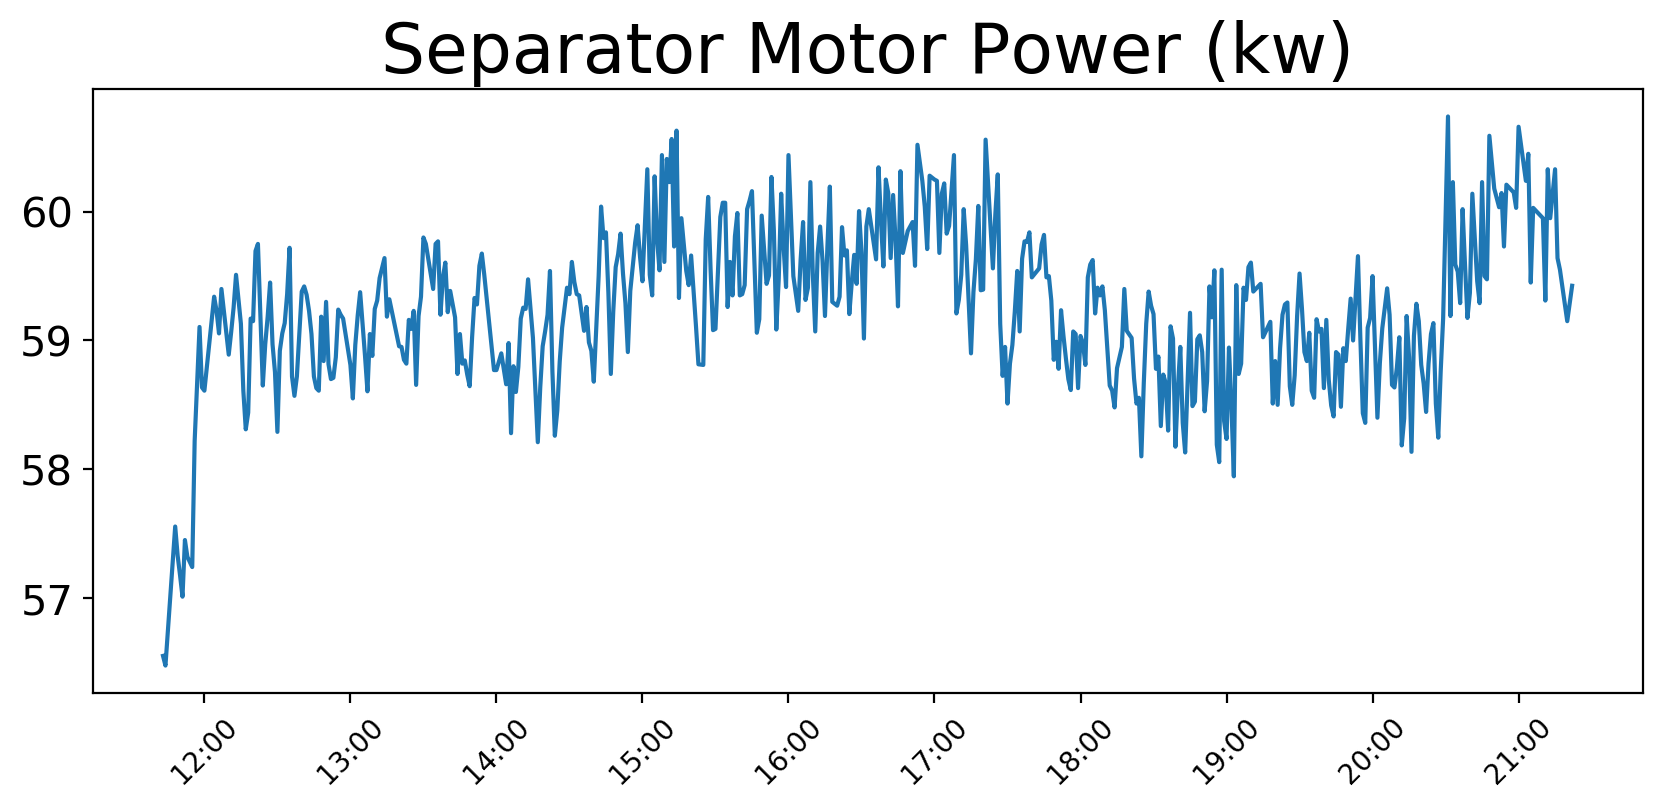

In [27]:
b1 = dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],4]
#b1r = b1.resample('300s').mean()
fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(b1.index, b1)

ax.set_title('Separator Motor Power (kw)', size=25)
ax.tick_params(labelsize=15)

import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

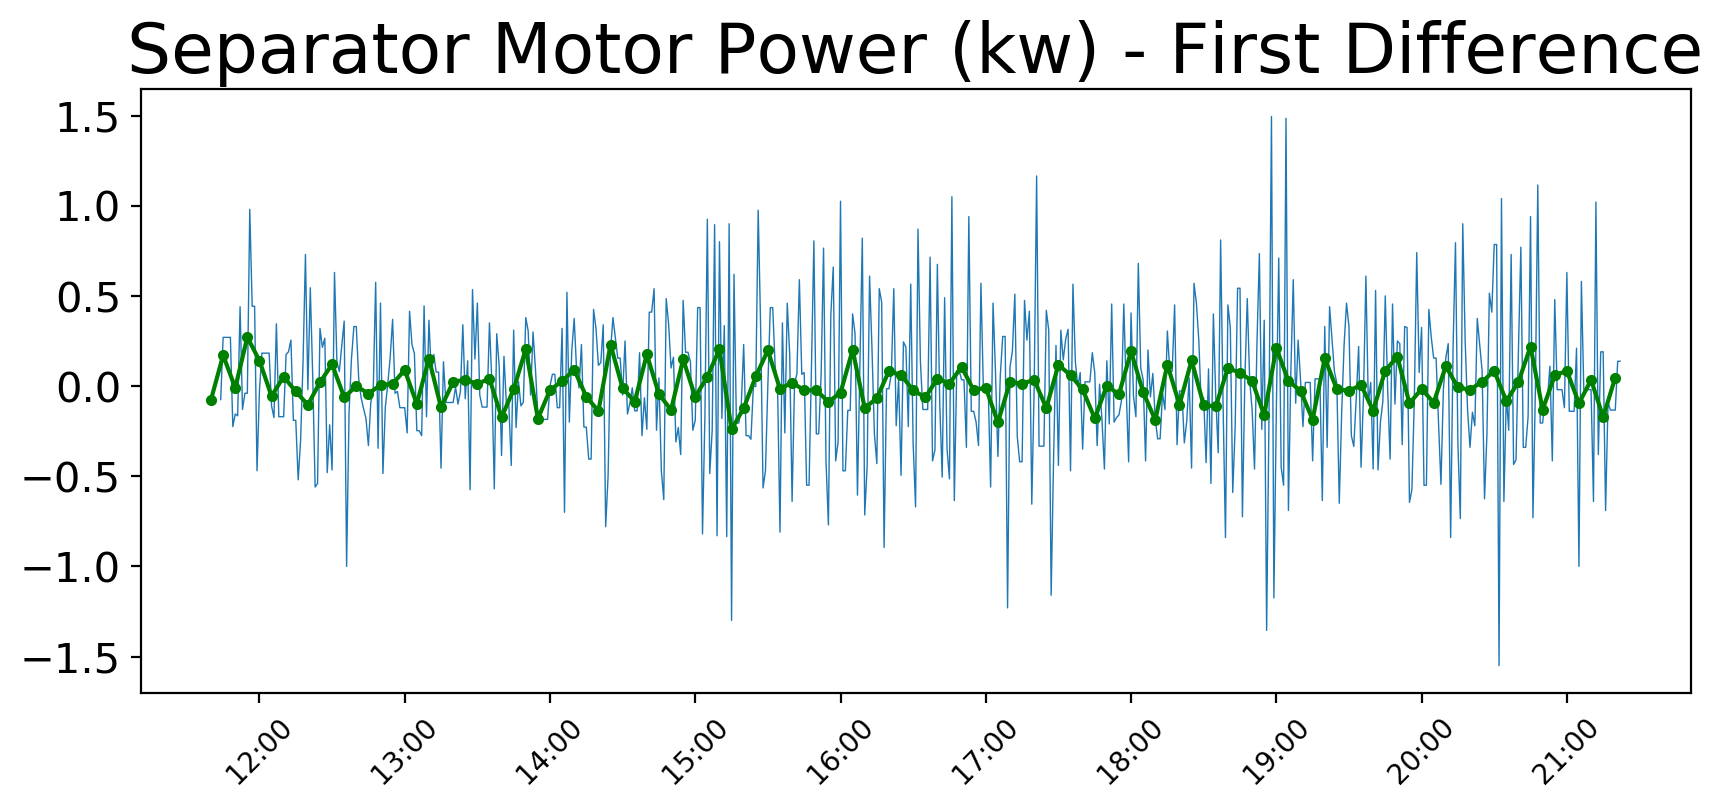

In [33]:
delta = b1.diff()
delta_r = delta.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(delta.index, delta, linewidth = 0.5)
ax.plot(delta_r.index, delta_r,linewidth = 1.5, marker = "o", markersize = 3, color = "green")
ax.set_title('Separator Motor Power (kw) - First Difference', size=25)

ax.tick_params(labelsize=15)
import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

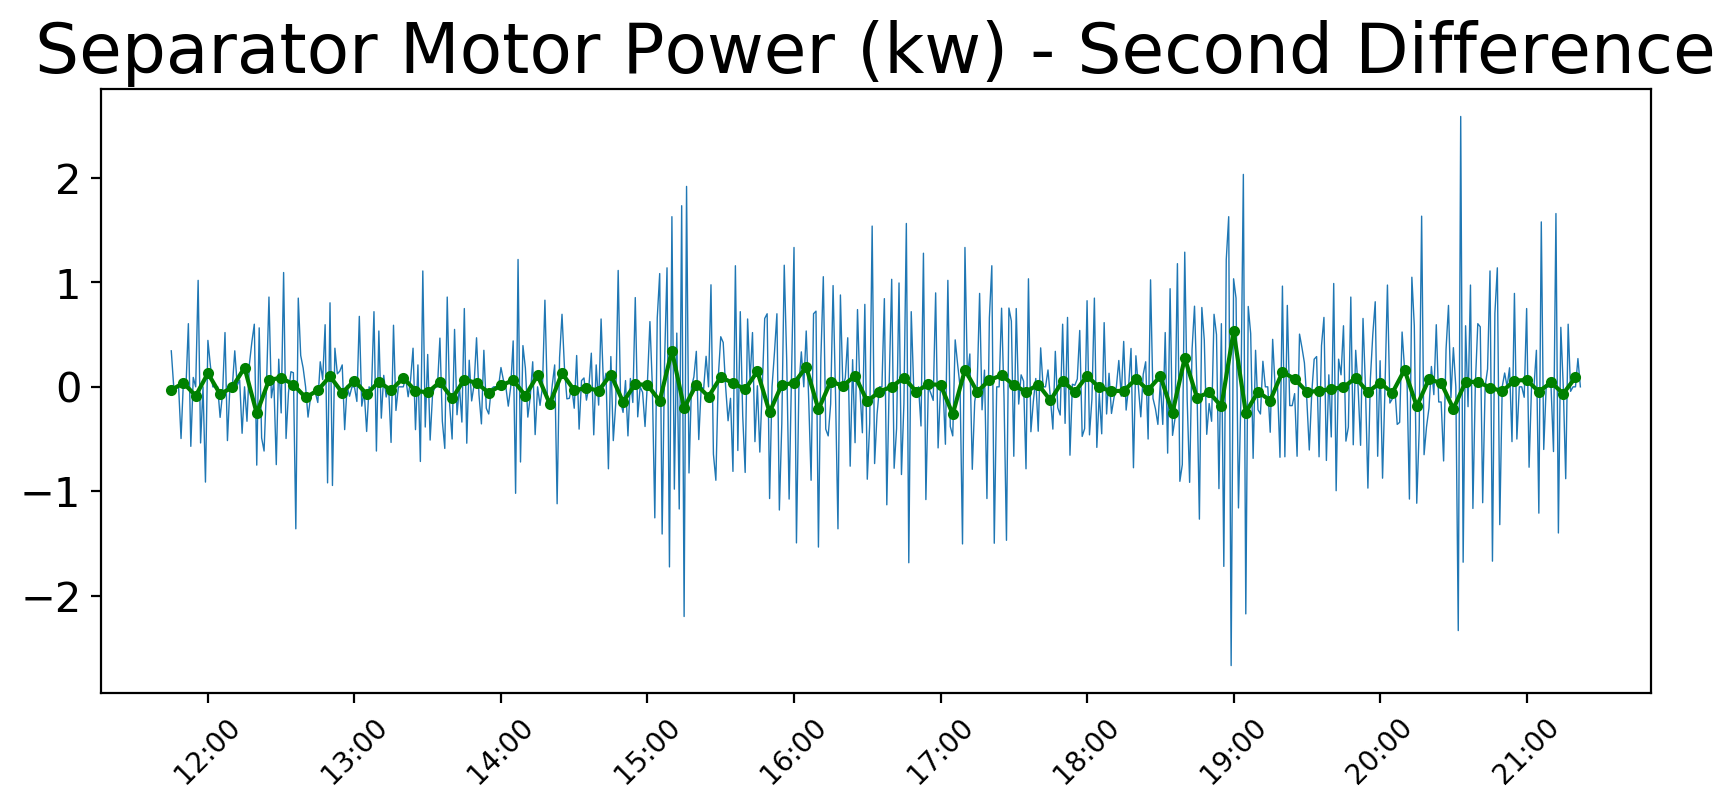

In [44]:
delta2 = delta.diff()
delta2_r = delta2.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(delta2.index, delta2, linewidth = 0.5)
ax.plot(delta2_r.index, delta2_r,linewidth = 1.5, marker = "o", markersize = 3, color = "green")
ax.set_title('Separator Motor Power (kw) - Second Difference', size=25)

ax.tick_params(labelsize=15)
import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

In [27]:
# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

#test data for stationarity using Dickey-Fuler test
#Write a function to perform a Dickey-Fuller test
def DickeyFuller(timeseries):
    
    """The input of the function must be a Pandas Series"""
    """Be careful: the input time series should not contain missing values"""
    
    #if the time series does not contain missing values then perform the test
    if timeseries.isnull().sum() == 0:
        
        print ('Results of Dickey-Fuller Test:')
        print('\n')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value','Number of Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    
    #otherwise
    else:
        print("Please remove the missing values from the input!")

In [71]:
DickeyFuller(b1[1:])

Results of Dickey-Fuller Test:


ADF Statistic                   -4.968531
p-value                          0.000026
Number of Lags Used             11.000000
Number of Observations Used    567.000000
Critical Value (1%)             -3.441936
Critical Value (5%)             -2.866651
Critical Value (10%)            -2.569492
dtype: float64


In [72]:
DickeyFuller(delta[2:])

Results of Dickey-Fuller Test:


ADF Statistic                 -9.595507e+00
p-value                        1.983350e-16
Number of Lags Used            1.100000e+01
Number of Observations Used    5.660000e+02
Critical Value (1%)           -3.441956e+00
Critical Value (5%)           -2.866660e+00
Critical Value (10%)          -2.569497e+00
dtype: float64


In [73]:
DickeyFuller(delta2[3:])

Results of Dickey-Fuller Test:


ADF Statistic                 -1.140853e+01
p-value                        7.347347e-21
Number of Lags Used            1.900000e+01
Number of Observations Used    5.570000e+02
Critical Value (1%)           -3.442145e+00
Critical Value (5%)           -2.866743e+00
Critical Value (10%)          -2.569541e+00
dtype: float64


### 2. Check for y autocorrelation

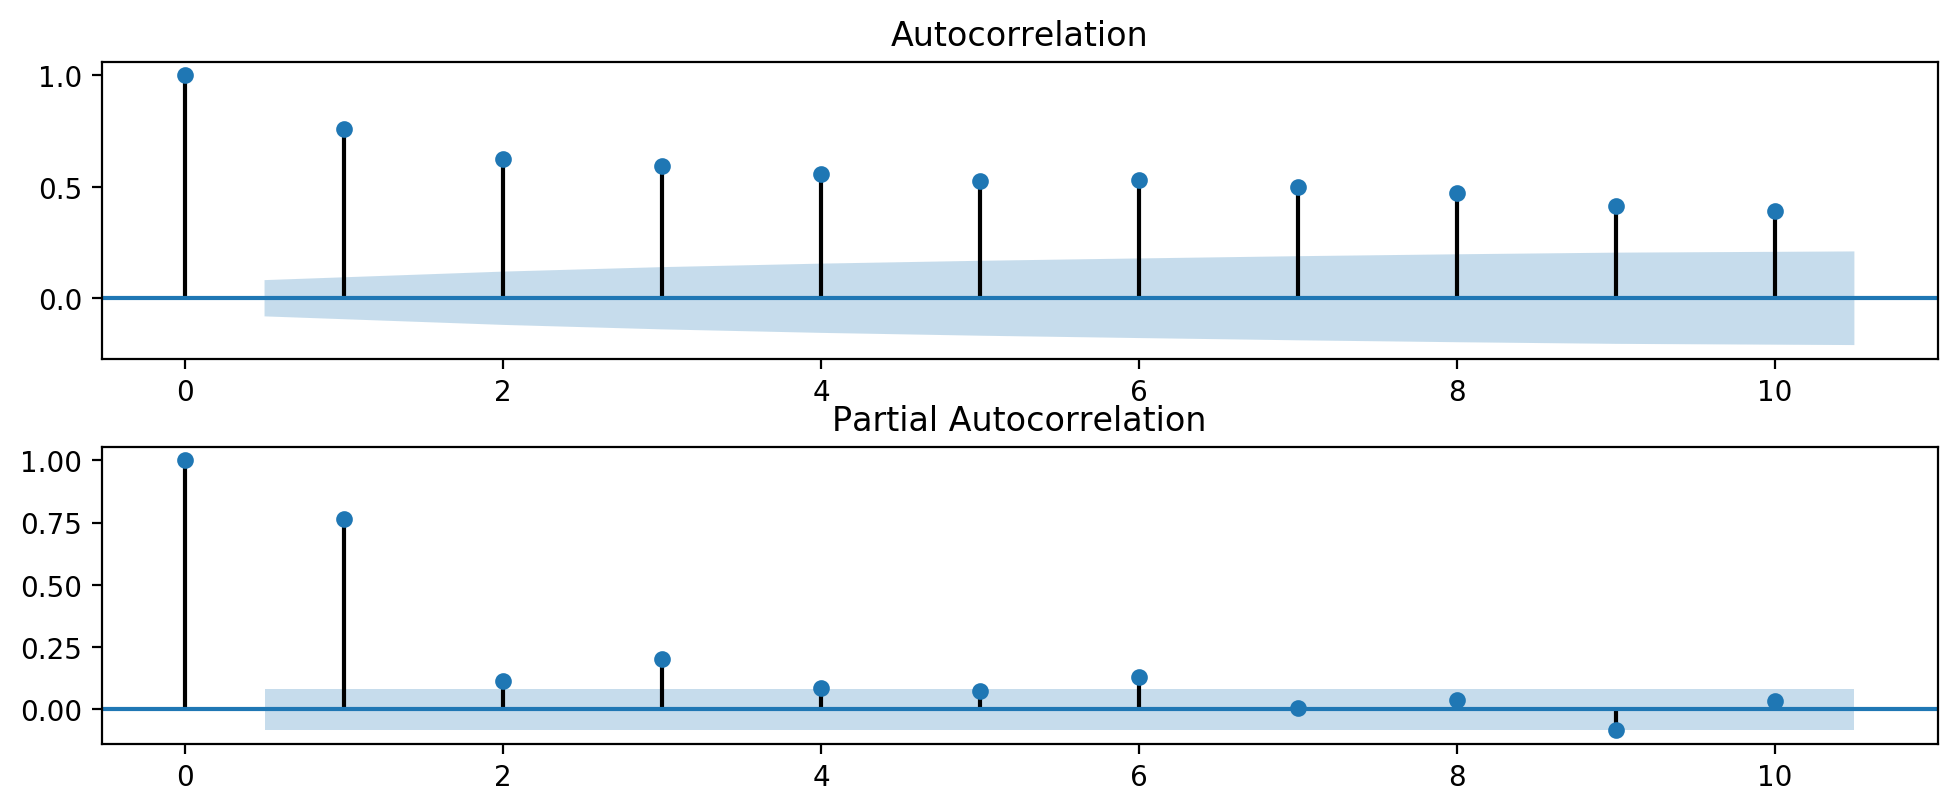

In [80]:
#import required packages
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#initialize plots
fig, axes = plt.subplots(figsize=(10,4), dpi=200, nrows = 2, ncols = 1)
plt.tight_layout()
#plot ACF& PACF
plot_acf(b1, lags = 10, ax = axes[0])
plot_pacf(b1, lags = 10, ax = axes[1])
plt.show()

In [175]:
train = b1.iloc[:500]
test = b1.iloc[500:]

In [191]:
#import required libraries 
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA

#initialize &fit the AR(1) model
ARMA_model = ARMA(train, order=(2,0))
ARMA_model_fit = ARMA_model.fit()

In [192]:
ARMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     separator_pwr_kw_pv   No. Observations:                  500
Model:                      ARMA(2, 0)   Log Likelihood                -227.379
Method:                        css-mle   S.D. of innovations              0.381
Date:                 Wed, 27 Nov 2019   AIC                            462.758
Time:                         15:27:18   BIC                            479.617
Sample:                     09-24-2019   HQIC                           469.374
                          - 09-24-2019                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        59.1699      0.094    628.094      0.000      58.985      59.355
ar.L1.separator_pwr_kw_pv     0.7052      0.045     15.834      0.000       0.618       0.792
ar.L2.separator_pwr_kw_pv     0.1153      0.045      2.534      0.012       0.026       0.204
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1875           +0.0000j            1.1875            0.0000
AR.2           -7.3053           +0.0000j            7.3053            0.5000
-----------------------------------------------------------------------------
"""

In [193]:
# Predict
ARMA_predicted = ARMA_model_fit.predict(start = test.index.min(), end = test.index.max())

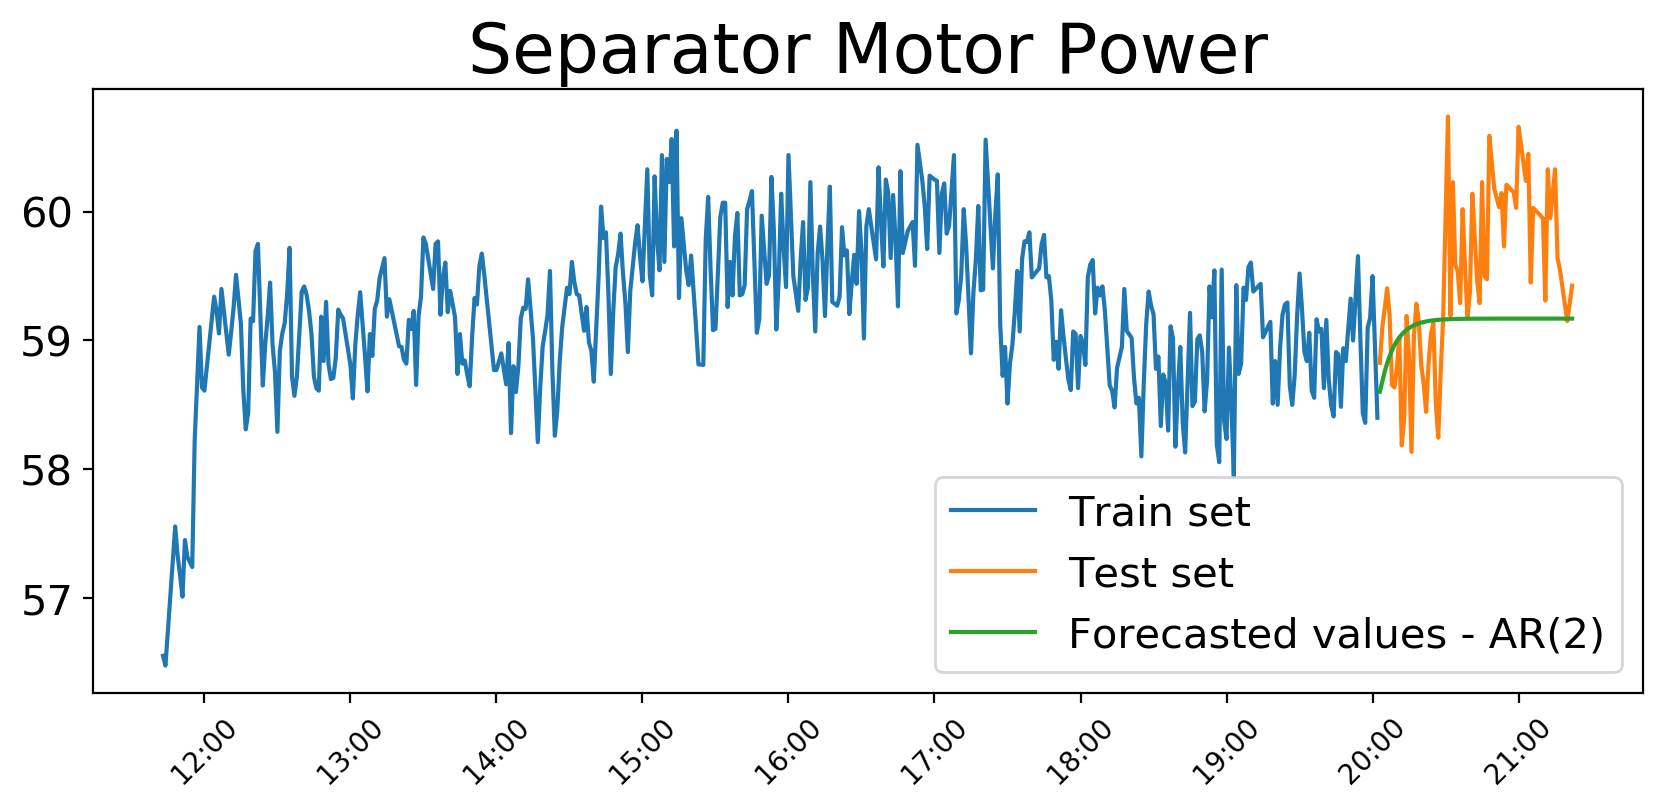

In [201]:
fig, ax = plt.subplots(figsize = (10,4), dpi = 200)

#plot the train and test data
ax.plot(train.index, train)
ax.plot(test.index, test)
ax.plot(test.index, ARMA_predicted)
ax.tick_params(labelsize=15)

#customize the plot
ax.set_title('Separator Motor Power', size = 25)
#ax.set_ylabel('')
#ax.set_xlabel('')
#ax.xaxis.set_ticks_position('bottom')
ax.legend(["Train set", "Test set", "Forecasted values - AR(2)"], prop={'size':15})

import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

#### Block 2: Mill dp

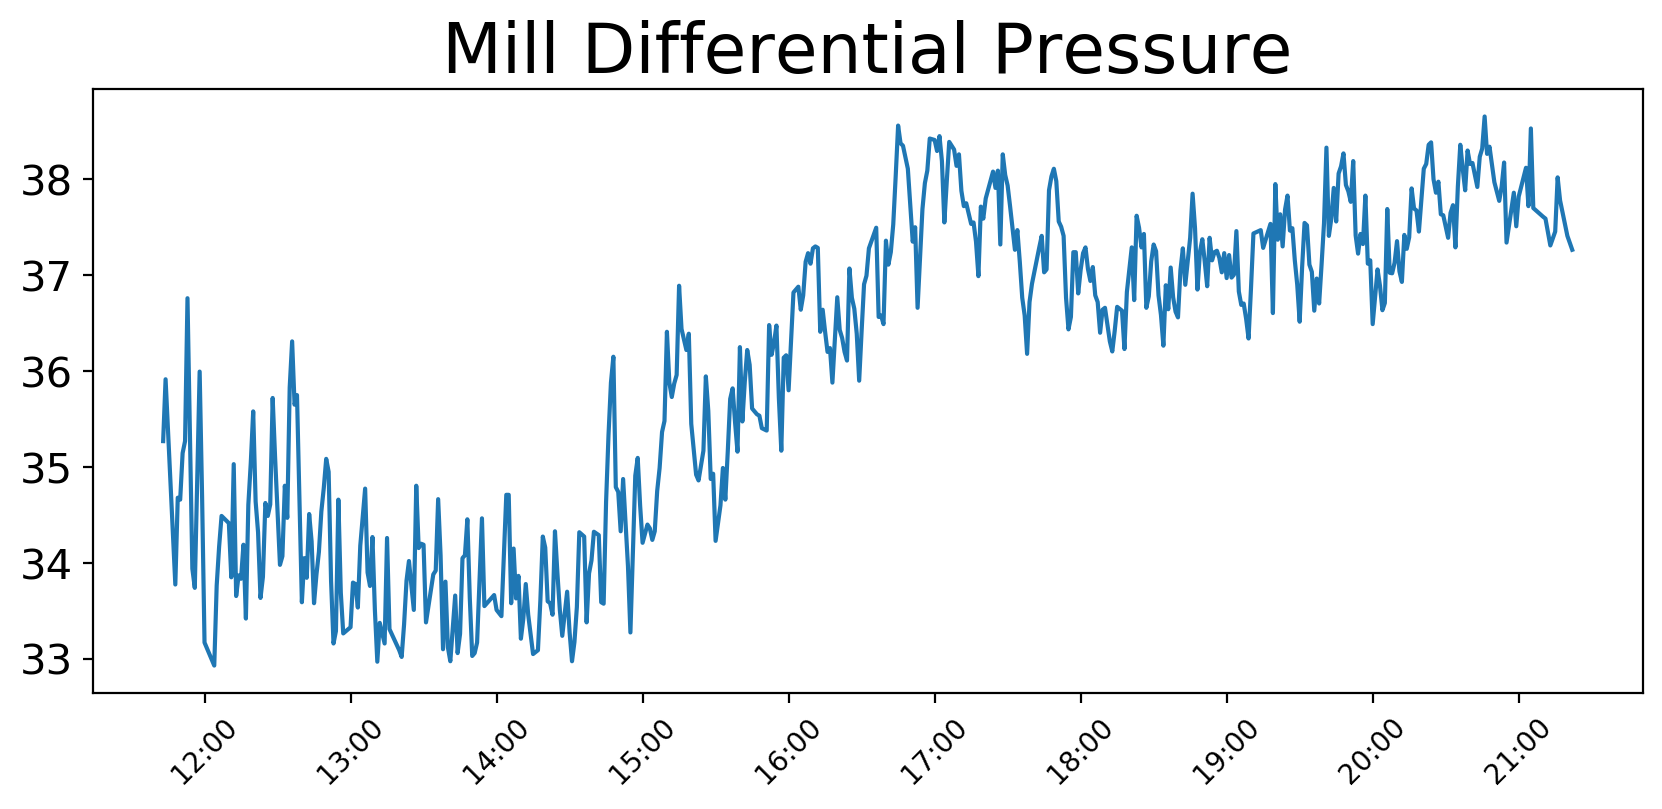

In [30]:
b2 = dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],6]
#b2r = b2.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(b2.index, b2)
ax.set_title('Mill Differential Pressure', size=25)
ax.tick_params(labelsize=15)


import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

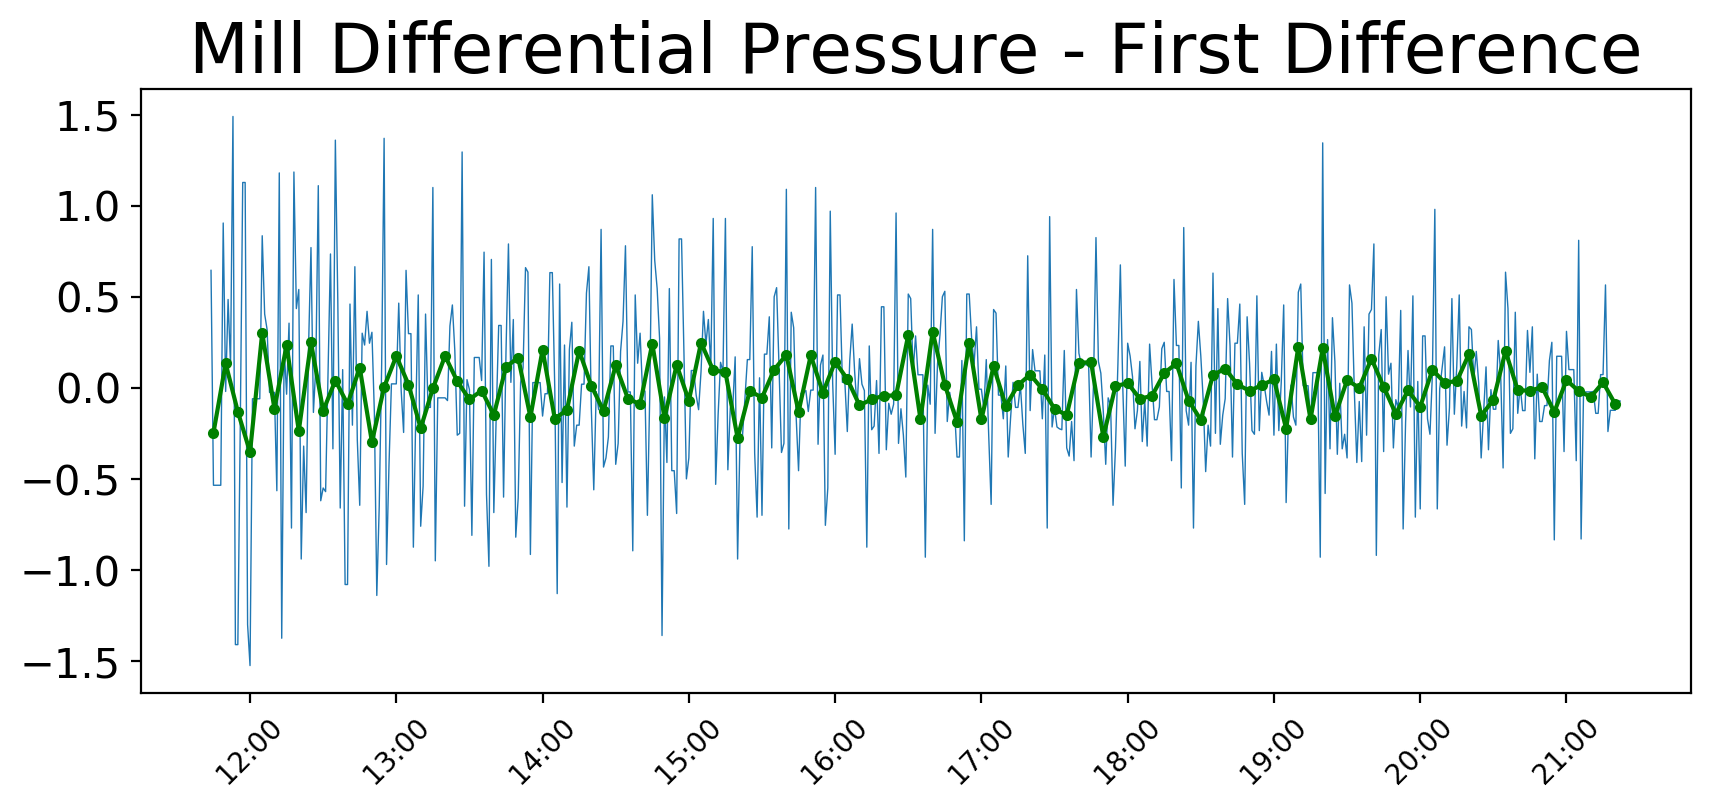

In [31]:
delta_b2 = b2.diff()
delta_b2_r = delta_b2.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(delta_b2.index[1:], delta_b2[1:], linewidth = 0.5)
ax.plot(delta_b2_r.index[1:], delta_b2_r[1:],linewidth = 1.5, marker = "o", markersize = 3, color = "green")
ax.set_title('Mill Differential Pressure - First Difference', size=25)
ax.tick_params(labelsize=15)


import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

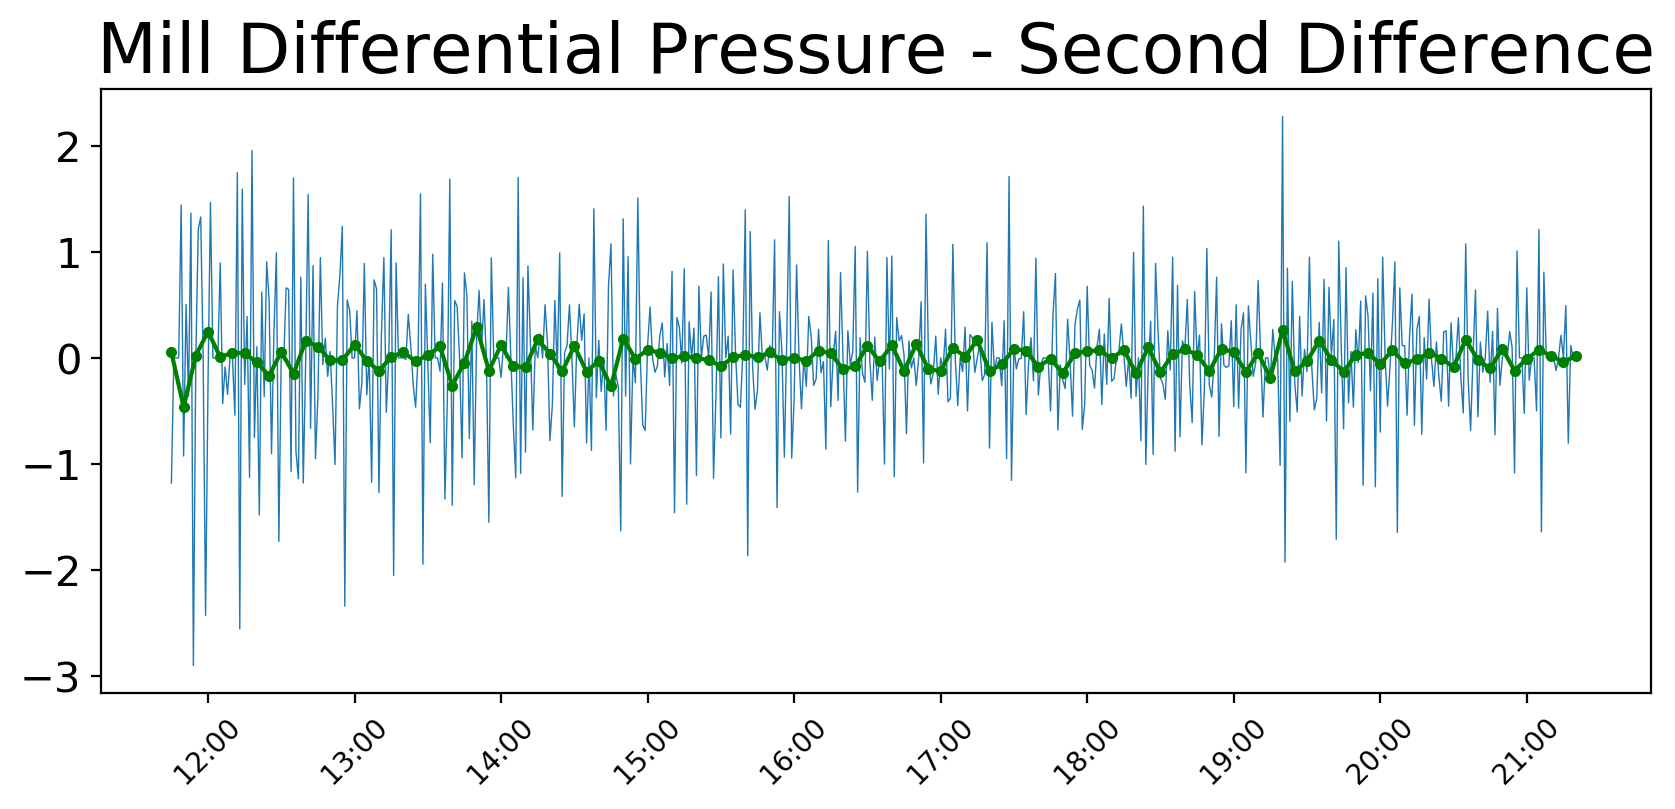

In [32]:
delta2_b2 = delta_b2.diff()
delta2_b2_r = delta2_b2.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(delta2_b2.index[1:], delta2_b2[1:], linewidth = 0.5)
ax.plot(delta2_b2_r.index, delta2_b2_r,linewidth = 1.5, marker = "o", markersize = 3, color = "green")
ax.set_title('Mill Differential Pressure - Second Difference', size=25)
ax.tick_params(labelsize=15)

import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

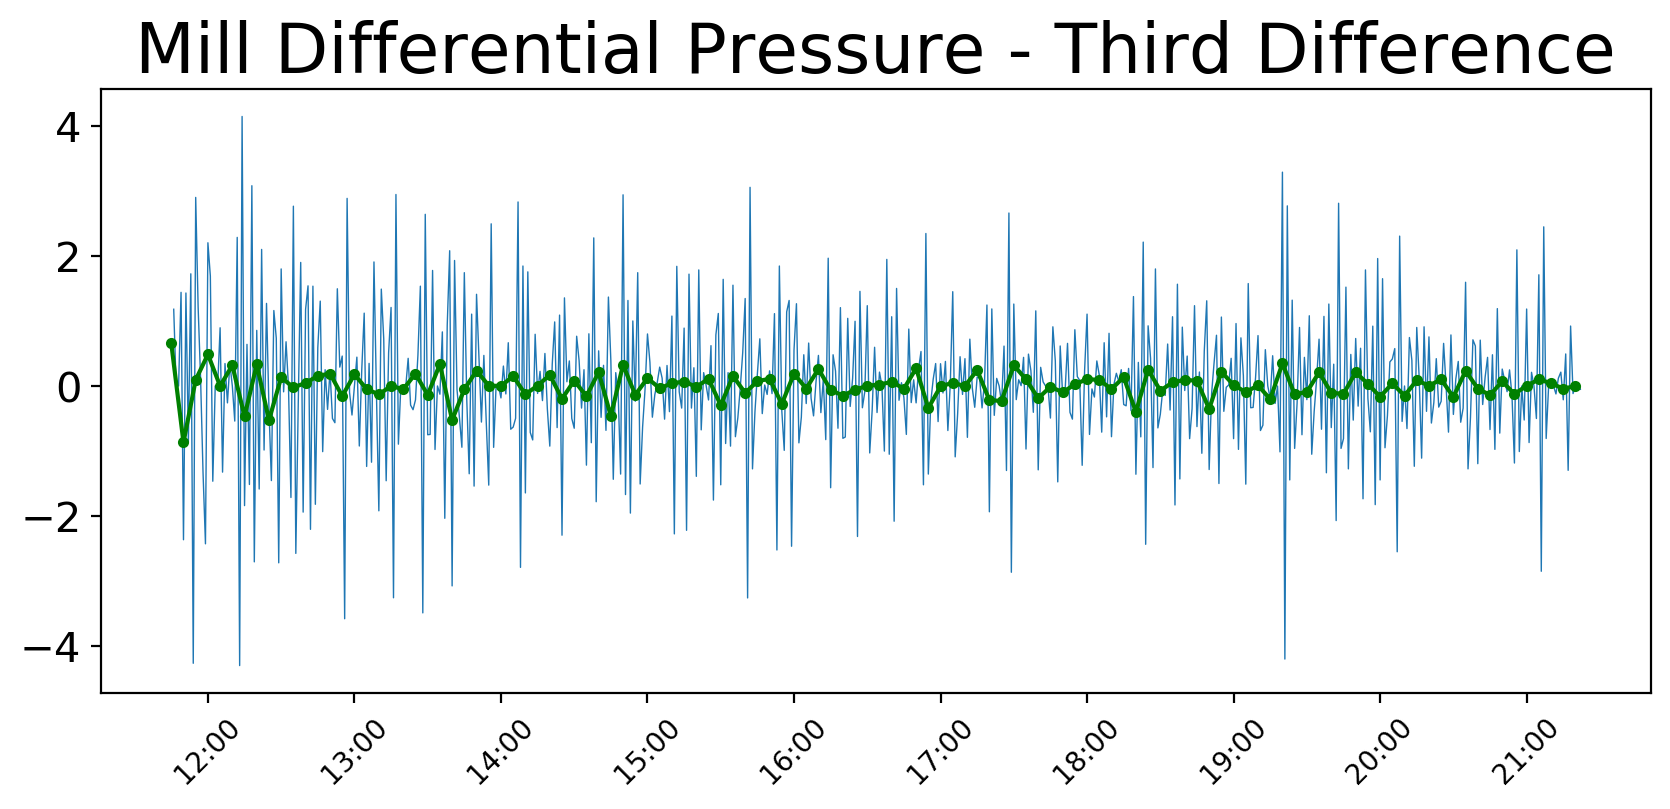

In [43]:
delta3_b2 = delta2_b2.diff()
delta3_b2_r = delta3_b2.resample('300s').mean()

fig, ax = plt.subplots(figsize = (10, 4),dpi = 200)
ax.plot(delta3_b2.index[1:], delta3_b2[1:], linewidth = 0.5)
ax.plot(delta3_b2_r.index[1:], delta3_b2_r[1:],linewidth = 1.5, marker = "o", markersize = 3, color = "green")
ax.set_title('Mill Differential Pressure - Third Difference', size=25)
ax.tick_params(labelsize=15)

import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

In [33]:
DickeyFuller(b2[1:])

Results of Dickey-Fuller Test:


ADF Statistic                   -1.321473
p-value                          0.619292
Number of Lags Used              8.000000
Number of Observations Used    570.000000
Critical Value (1%)             -3.441875
Critical Value (5%)             -2.866624
Critical Value (10%)            -2.569478
dtype: float64


In [34]:
print('First Difference')
DickeyFuller(delta_b2[2:])

First Difference
Results of Dickey-Fuller Test:


ADF Statistic                 -8.681321e+00
p-value                        4.278310e-14
Number of Lags Used            1.900000e+01
Number of Observations Used    5.580000e+02
Critical Value (1%)           -3.442124e+00
Critical Value (5%)           -2.866734e+00
Critical Value (10%)          -2.569536e+00
dtype: float64


In [76]:
DickeyFuller(delta2_b2[3:])

Results of Dickey-Fuller Test:


ADF Statistic                 -1.017387e+01
p-value                        6.974562e-18
Number of Lags Used            1.900000e+01
Number of Observations Used    5.570000e+02
Critical Value (1%)           -3.442145e+00
Critical Value (5%)           -2.866743e+00
Critical Value (10%)          -2.569541e+00
dtype: float64


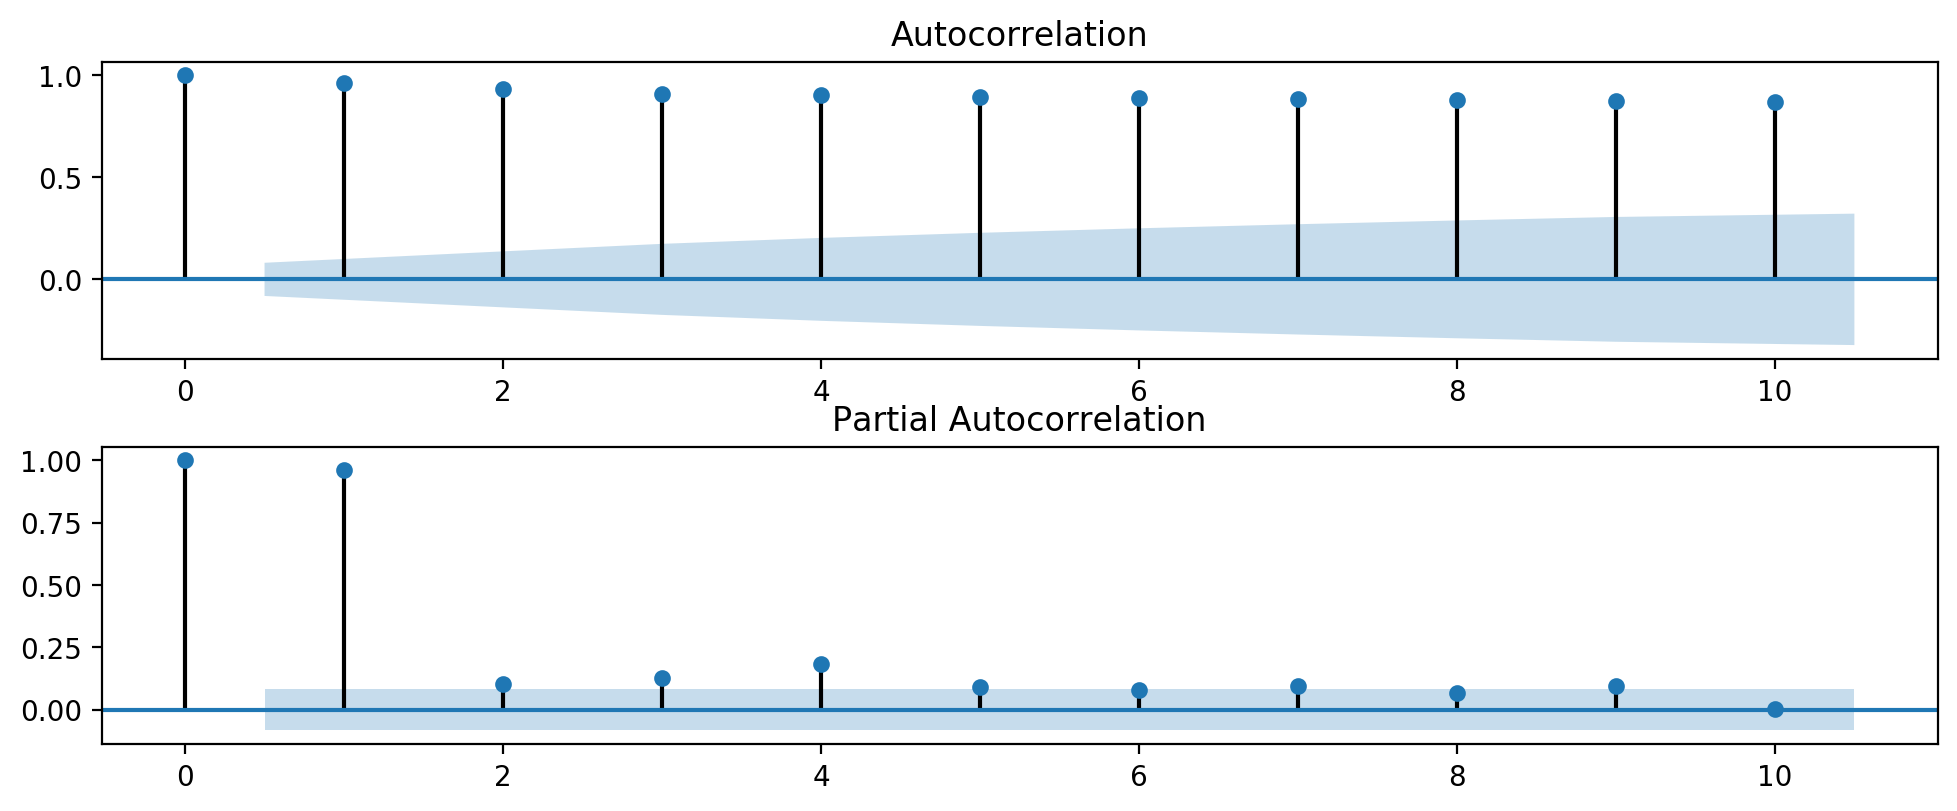

In [83]:
#initialize plots
fig, axes = plt.subplots(figsize=(10,4),dpi=200, nrows = 2, ncols = 1)
plt.tight_layout()
#plot ACF& PACF
plot_acf(b2, lags = 10, ax = axes[0])
plot_pacf(b2, lags = 10, ax = axes[1])
plt.show()


In [36]:
train = b2.iloc[:500]
test = b2.iloc[500:]


#import required libraries 
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA

#initialize &fit the AR(1) model
ARIMA_model = ARIMA(train, order=(2,1,0))
ARIMA_model_fit = ARIMA_model.fit()

In [37]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.mill_dp_mbar_pv   No. Observations:                  499
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -334.098
Method:                       css-mle   S.D. of innovations              0.473
Date:                Thu, 28 Nov 2019   AIC                            676.196
Time:                        12:08:34   BIC                            693.046
Sample:                    09-24-2019   HQIC                           682.808
                         - 09-24-2019                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0033      0.017      0.194      0.847      -0.030       0.036
ar.L1.D.mill_dp_mbar_pv    -0.1164      0.044     -2.622      0.009      -0.203      -0.029
ar.L2.D.mill_dp_mbar_pv    -0.1370      0.044     -3.085      0.002      -0.224      -0.050
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4248           -2.6681j            2.7017           -0.2751
AR.2           -0.4248           +2.6681j            2.7017            0.2751
-----------------------------------------------------------------------------
"""

In [39]:
ARIMA_predicted = ARIMA_model_fit.predict(start = test.index.min(), end = test.index.max())

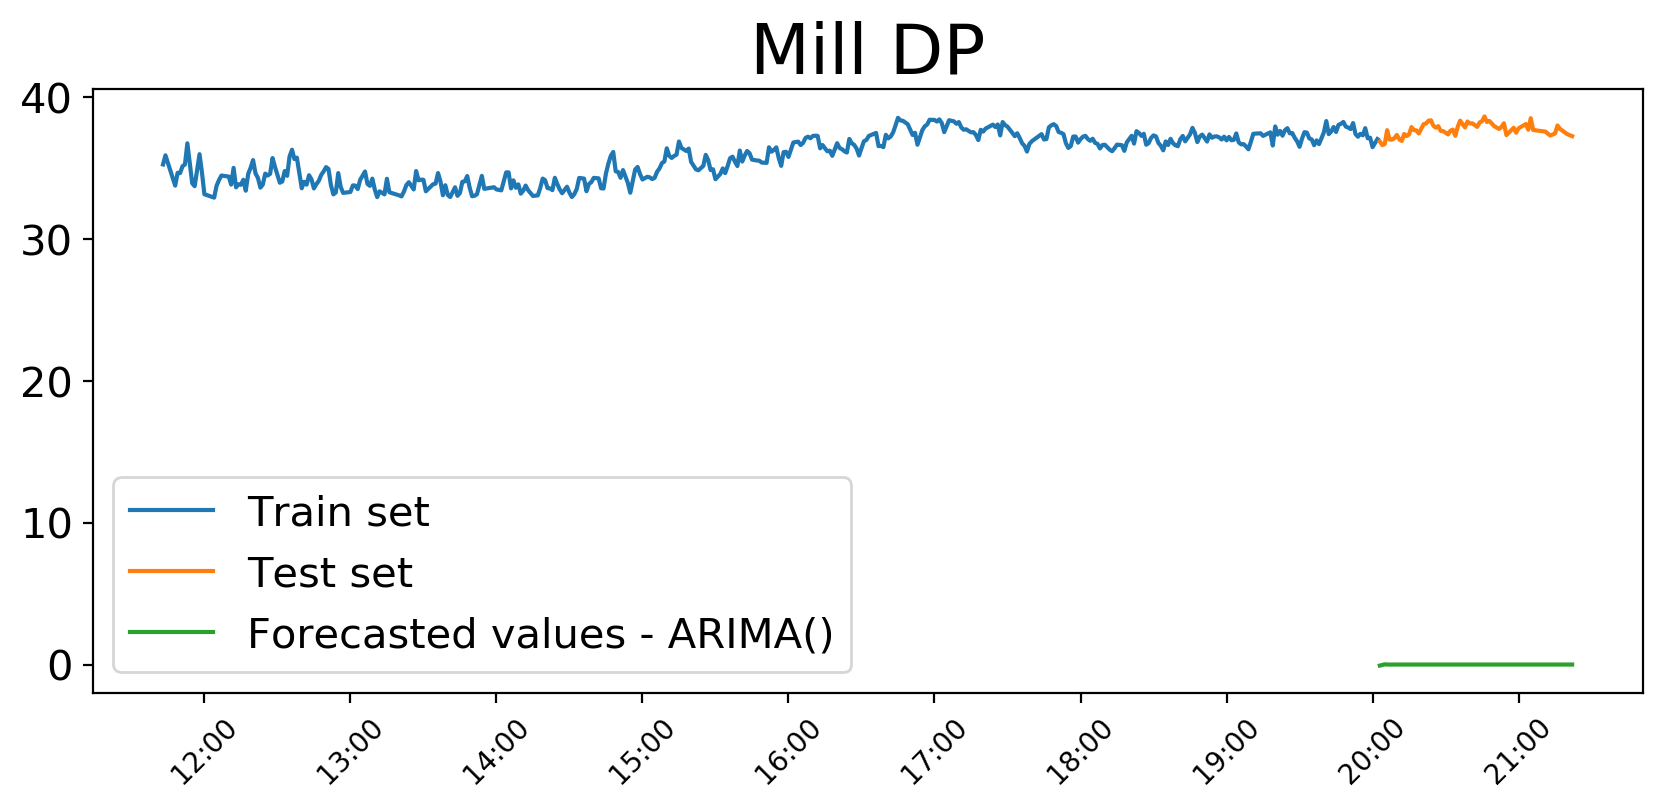

In [40]:
fig, ax = plt.subplots(figsize = (10,4), dpi = 200)

#plot the train and test data
ax.plot(train.index, train)
ax.plot(test.index, test)
ax.plot(test.index, ARIMA_predicted)
ax.tick_params(labelsize=15)

#customize the plot
ax.set_title('Mill DP', size = 25)
#ax.set_ylabel('')
#ax.set_xlabel('')
#ax.xaxis.set_ticks_position('bottom')
ax.legend(["Train set", "Test set", "Forecasted values - ARIMA()"], prop={'size':15})

import matplotlib.dates as mdates
#FOR THE YEARS
# Set x-axis major ticks to yearly intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute = 0))
# Format x-tick labels as the full year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#FOR THE MONTHS
# Set x-axis minor ticks to monthly intervals
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute = 30))
# Format x-tick labels as monthly intervals
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M:%S'))

#rotate the minor ticks and change the label size
for text in ax.get_xmajorticklabels():
    text.set_rotation(45)
    text.set_size(10)

In [127]:
dfc1r.columns[4]

'separator_pwr_kw_pv'

### 3. Create Dataframes with y lags

#### Block 1

In [134]:
# -------------------------------Cement 1----------------------------------------
varx1=[]
varx2=[]
date = []
lag1=[]
lag2=[]
lags=[lag1,lag2]

vary = []
# With for loop we store in varx1, varx2 and vary the elements corresponding to consecutive dates
# With .shift() we take the time lag for each variable
for i in range(len(c1_last_idx)-1):
    date.append(list(dfc1r.index[c1_first_idx[i]:c1_last_idx[i]]))
    varx1.append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],5].shift(1)))
    varx2.append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],6].shift(6)))
    j=1
    for lag in lags:
        lag.append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],4].shift(j)))
        j=j+1
    vary.append (list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],4]))

# Convert the list of lists to a flat list
c1_date = [item for sublist in date  for item in sublist]
c1_x1 =   [item for sublist in varx1 for item in sublist]
c1_x2 =   [item for sublist in varx2 for item in sublist]
c1_y  =   [item for sublist in vary  for item in sublist]
c1_y_lags = [0]*(len(lags))
for i in range(len(lags)): 
    c1_y_lags[i] = [item for sublist in lags[i] for item in sublist]


# -------------------------------Cement 2----------------------------------------
varx1=[]
varx2=[]
vary = []
date = []
lag1=[]
lag2=[]
lags=[lag1,lag2]


for i in range(len(c2_last_idx)-1):
    date.append(list(dfc2r.index[c2_first_idx[i]:c2_last_idx[i]]))
    varx1.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],5].shift(1)))
    varx2.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],6].shift(6)))
    j=1
    for lag in lags:
        lag.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],4].shift(j)))
        j=j+1
    vary.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],4]))

# Convert the list of lists to a flat list
c2_date = [item for sublist in date for item in sublist]
c2_x1 = [item for sublist in varx1 for item in sublist]
c2_x2 = [item for sublist in varx2 for item in sublist]
c2_y  = [item for sublist in vary  for item in sublist]
c2_y_lags = [0]*(len(lags))
for i in range(len(lags)): 
    c2_y_lags[i] = [item for sublist in lags[i] for item in sublist]

In [141]:
dfc1_b1 = pd.DataFrame(list(zip(c1_date,c1_x1,c1_x2,c1_y_lags[0],c1_y_lags[1],c1_y)),
                       columns =['date', dfc2r.columns[5], dfc2r.columns[6], 'lag1','lag2',dfc2r.columns[4]]) 
dfc2_b1 = pd.DataFrame(list(zip(c2_date,c2_x1,c2_x2,c2_y_lags[0],c2_y_lags[1],c2_y)),
                       columns =['date', dfc2r.columns[5], dfc2r.columns[6], 'lag1','lag2',dfc2r.columns[4]])  
dfc1_b1.dropna(inplace=True)
dfc2_b1.dropna(inplace=True)

dfc1_b1.set_index("date",inplace=True)
dfc2_b1.set_index("date",inplace=True)
#c1_b1_lag = dfc1_b1.reset_index().drop(['index'], axis =1)
#c2_b1_lag = dfc2_b1.reset_index().drop(['index'], axis =1)

dfc1_b1.to_csv(r'block1_c1_new.csv')
dfc2_b1.to_csv(r'block1_c2_new.csv')

In [157]:
dfc1_b1

separator_speed_rpm_pv  mill_dp_mbar_pv    lag1    lag2  \
date                                                                           
2019-05-12 20:27:00                 768.395           31.060  56.700  56.035   
2019-05-12 20:28:00                 768.580           31.240  56.155  56.700   
2019-05-12 20:29:00                 768.340           30.955  56.195  56.155   
2019-05-12 20:30:00                 778.535           30.775  56.520  56.195   
2019-05-12 20:31:00                 787.170           30.560  56.885  56.520   
...                                     ...              ...     ...     ...   
2019-10-29 20:39:00                 802.455           38.555  58.355  57.715   
2019-10-29 20:40:00                 803.885           38.550  58.000  58.355   
2019-10-29 20:41:00                 803.700           38.615  58.700  58.000   
2019-10-29 20:42:00                 803.860           38.640  58.140  58.700   
2019-10-29 20:43:00                 802.780           38.355  58.560  58.140   

                     separator_pwr_kw_pv  
date                                      
2019-05-12 20:27:00               56.155  
2019-05-12 20:28:00               56.195  
2019-05-12 20:29:00               56.520  
2019-05-12 20:30:00               56.885  
2019-05-12 20:31:00               57.290  
...                                  ...  
2019-10-29 20:39:00               58.000  
2019-10-29 20:40:00               58.700  
2019-10-29 20:41:00               58.140  
2019-10-29 20:42:00               58.560  
2019-10-29 20:43:00               58.250  

[35545 rows x 5 columns]

#### Block 2

In [161]:
shifts = [5,15,16,5,3,4,3,4]
varx_cols = [0,7,8,9,5,10,11,3]   # the number of the column of each x variable in the dfc1r and dfc2r

# --------------------------------------Cement 1---------------------------------------

vary = []
date = []
varx1=[]
varx2=[]
varx3=[]
varx4=[]
varx5=[]
varx6=[]
varx7=[]
varx8=[]
variables = [varx1, varx2, varx3, varx4, varx5, varx6, varx7, varx8]
lag1=[]
lag2=[]
lags=[lag1,lag2]

for i in range(len(c1_last_idx)-1):
    for var in range(len(variables)):
        variables[var].append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],varx_cols[var]].shift(shifts[var])))
    vary.append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],6]))
    date.append(list(dfc1r.index[c1_first_idx[i]:c1_last_idx[i]]))
    j=1
    for lag in lags:
        lag.append(list(dfc1r.iloc[c1_first_idx[i]:c1_last_idx[i],6].shift(j)))
        j=j+1

c1_y  = [item for sublist in vary  for item in sublist]
c1_date = [item for sublist in date for item in sublist]
c1 = [0]*(len(variables))
# Convert the list of lists to a flat list
for i in range(len(variables)): 
    c1[i] = [item for sublist in variables[i] for item in sublist]
c1_y_lags = [0]*(len(lags))
for i in range(len(lags)): 
    c1_y_lags[i] = [item for sublist in lags[i] for item in sublist]

# --------------------------------------Cement 2---------------------------------------
vary=[]
date=[]
varx1=[]
varx2=[]
varx3=[]
varx4=[]
varx5=[]
varx6=[]
varx7=[]
varx8=[]
variables = [varx1, varx2, varx3, varx4, varx5, varx6, varx7, varx8]
lag1=[]
lag2=[]
lags=[lag1,lag2]

for i in range(len(c2_last_idx)-1):
    for var in range(len(variables)):
        variables[var].append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],varx_cols[var]].shift(shifts[var])))
    vary.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],6]))
    date.append(list(dfc2r.index[c2_first_idx[i]:c2_last_idx[i]]))
    j=1
    for lag in lags:
        lag.append(list(dfc2r.iloc[c2_first_idx[i]:c2_last_idx[i],6].shift(j)))
        j=j+1

c2_y  = [item for sublist in vary  for item in sublist]
c2_date = [item for sublist in date for item in sublist]
c2 = [0]*(len(variables))
for i in range(len(variables)): 
    c2[i] = [item for sublist in variables[i] for item in sublist]
c2_y_lags = [0]*(len(lags))
for i in range(len(lags)): 
    c2_y_lags[i] = [item for sublist in lags[i] for item in sublist]

In [162]:
col_names = ['date']
for i in range(len(varx_cols)):
    col_names.append(dfc1r.columns[varx_cols[i]])
lag_names=['lag1','lag2']
for i in lag_names:
    col_names.append(i)
col_names.append(dfc1r.columns[6])
dfc1_b2 = pd.DataFrame(list(zip(c1_date, c1[0],c1[1],c1[2],c1[3],c1[4],c1[5],c1[6],c1[7],
                                c1_y_lags[0],c1_y_lags[1],c1_y)), columns =col_names) 
dfc2_b2 = pd.DataFrame(list(zip(c2_date, c2[0],c2[1],c2[2],c2[3],c2[4],c2[5],c2[6],c2[7],
                                c2_y_lags[0],c2_y_lags[1],c2_y)), columns =col_names) 

dfc1_b2.dropna(inplace=True)
dfc2_b2.dropna(inplace=True)
#c1_b2_lag = dfc1_b2.reset_index().drop(['index'], axis =1)
#c2_b2_lag = dfc2_b2.reset_index().drop(['index'], axis =1)

dfc1_b2.set_index('date',inplace=True)
dfc2_b2.set_index('date',inplace=True)

dfc1_b2.to_csv(r'block2_c1_new.csv')
dfc2_b2.to_csv(r'block2_c2_new.csv')

### 4. Create dataframes for graphs

#### Block 1

In [73]:

# -------------------------------Cement 1----------------------------------------
dates=[]
varx1=[]
varx2=[]
lag1y=[]
lag2y=[]
vary=[]
c1_date=[]
c1_x1=[]
c1_x2=[]
c1_lag1=[]
c1_lag2=[]
c1_y=[]

dates.append(list(dfc1r.index[c1_first_idx[-1]:c1_last_idx[-1]]))
varx1.append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],5].shift(1)))
varx2.append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],6].shift(6)))
lag1y.append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],4].shift(1)))
lag2y.append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],4].shift(2)))
vary.append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],4]))

#flat lists
c1_date = [item for sublist in dates for item in sublist]
c1_x1   = [item for sublist in varx1 for item in sublist]
c1_x2   = [item for sublist in varx2 for item in sublist]
c1_lag1 = [item for sublist in lag1y for item in sublist]
c1_lag2 = [item for sublist in lag2y for item in sublist]
c1_y    = [item for sublist in vary  for item in sublist]

# -------------------------------Cement 2----------------------------------------
dates=[]
varx1=[]
varx2=[]
lag1y=[]
lag2y=[]
vary=[]
c2_date=[]
c2_x1=[]
c2_x2=[]
c2_lag1=[]
c2_lag2=[]
c2_y=[]

dates.append(list(dfc2r.index[c2_first_idx[-1]:c2_last_idx[-1]]))
varx1.append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],5].shift(1)))
varx2.append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],6].shift(6)))
lag1y.append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],4].shift(1)))
lag2y.append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],4].shift(2)))
vary.append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],4]))

c2_date = [item for sublist in dates for item in sublist]
c2_x1   = [item for sublist in varx1 for item in sublist]
c2_x2   = [item for sublist in varx2 for item in sublist]
c2_lag1 = [item for sublist in lag1y for item in sublist]
c2_lag2 = [item for sublist in lag2y for item in sublist]
c2_y    = [item for sublist in vary  for item in sublist]

In [74]:
gr_c1_b1 = pd.DataFrame(list(zip(c1_date,c1_x1,c1_x2,c1_lag1,c1_lag2,c1_y)),
                       columns =['date', dfc2r.columns[5], dfc2r.columns[6], 'lag1','lag2',dfc2r.columns[4]]) 
gr_c2_b1 = pd.DataFrame(list(zip(c2_date,c2_x1,c2_x2,c2_lag1,c2_lag2,c2_y)),
                       columns =['date', dfc2r.columns[5], dfc2r.columns[6], 'lag1','lag2',dfc2r.columns[4]])  
gr_c1_b1.dropna(inplace=True)
gr_c2_b1.dropna(inplace=True)

gr_c1_b1.set_index("date",inplace=True)
gr_c2_b1.set_index("date",inplace=True)
#c1_b1_lag = dfc1_b1.reset_index().drop(['index'], axis =1)
#c2_b1_lag = dfc2_b1.reset_index().drop(['index'], axis =1)

gr_c1_b1.to_csv(r'block1_c1_graphs.csv')
gr_c2_b1.to_csv(r'block1_c2_graphs.csv')

In [75]:
gr_c1_b1.shape

(169, 5)

#### Block 2

In [76]:
shifts = [5,15,16,5,3,4,3,4]
varx_cols = [0,7,8,9,5,10,11,3]   # the number of the column of each x variable in the dfc1r and dfc2r

# --------------------------------------Cement 1---------------------------------------
date=[]
lag1=[]
lag2=[]
vary=[]
date = [list(dfc1r.index[c1_first_idx[-1]:c1_last_idx[-1]])]
vary = [list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],6])]
lag1 = [list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],6].shift(1))]
lag2 = [list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],6].shift(2))]

varx1=[]
varx2=[]
varx3=[]
varx4=[]
varx5=[]
varx6=[]
varx7=[]
varx8=[]
variables = [varx1, varx2, varx3, varx4, varx5, varx6, varx7, varx8]

for var in range(len(variables)):
    variables[var].append(list(dfc1r.iloc[c1_first_idx[-1]:c1_last_idx[-1],varx_cols[var]].shift(shifts[var])))

#flat lists
c1_date=[]
c1_lag1=[]
c1_lag2=[]
c1_y=[]
c1_date = [item for sublist in date for item in sublist]
c1_lag1 = [item for sublist in lag1 for item in sublist]
c1_lag2 = [item for sublist in lag2 for item in sublist]
c1_y    = [item for sublist in vary  for item in sublist]
c1 = [0]*(len(variables))
for i in range(len(variables)): 
    c1[i] = [item for sublist in variables[i] for item in sublist]

# --------------------------------------Cement 2---------------------------------------
date=[]
lag1=[]
lag2=[]
vary=[]
date = [list(dfc2r.index[c2_first_idx[-1]:c2_last_idx[-1]])]
vary = [list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],6])]
lag1 = [list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],6].shift(1))]
lag2 = [list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],6].shift(2))]

varx1=[]
varx2=[]
varx3=[]
varx4=[]
varx5=[]
varx6=[]
varx7=[]
varx8=[]
variables = [varx1, varx2, varx3, varx4, varx5, varx6, varx7, varx8]

for var in range(len(variables)):
    variables[var].append(list(dfc2r.iloc[c2_first_idx[-1]:c2_last_idx[-1],varx_cols[var]].shift(shifts[var])))

#flat lists
c2_date=[]
c2_lag1=[]
c2_lag2=[]
c2_y=[]
c2_date = [item for sublist in date for item in sublist]
c2_lag1 = [item for sublist in lag1 for item in sublist]
c2_lag2 = [item for sublist in lag2 for item in sublist]
c2_y    = [item for sublist in vary for item in sublist]
c2 = [0]*(len(variables))
for i in range(len(variables)): 
    c2[i] = [item for sublist in variables[i] for item in sublist]



In [77]:
col_names = ['date']
for i in range(len(varx_cols)):
    col_names.append(dfc1r.columns[varx_cols[i]])
lag_names=['lag1','lag2']
for i in lag_names:
    col_names.append(i)
col_names.append(dfc1r.columns[6])
gr_c1_b2 = pd.DataFrame(list(zip(c1_date, c1[0],c1[1],c1[2],c1[3],c1[4],c1[5],c1[6],c1[7],
                                c1_lag1,c1_lag2,c1_y)), columns =col_names) 
gr_c2_b2 = pd.DataFrame(list(zip(c2_date, c2[0],c2[1],c2[2],c2[3],c2[4],c2[5],c2[6],c2[7],
                                c2_lag1,c2_lag2,c2_y)), columns =col_names) 

gr_c1_b2.dropna(inplace=True)
gr_c2_b2.dropna(inplace=True)
#c1_b2_lag = dfc1_b2.reset_index().drop(['index'], axis =1)
#c2_b2_lag = dfc2_b2.reset_index().drop(['index'], axis =1)

gr_c1_b2.set_index('date',inplace=True)
gr_c2_b2.set_index('date',inplace=True)

gr_c1_b2.to_csv(r'block2_c1_graphs.csv')
gr_c2_b2.to_csv(r'block2_c2_graphs.csv')

In [80]:
gr_c2_b2.shape

(93, 11)